In [0]:
"""
Pipeline complet d'analyse pour la maintenance prédictive avec optimisation multi-modèles.

Ce notebook implémente une approche exhaust pour la prédiction de défaillances, depuis
l'exploration des données jusqu'à l'optimisation fine des seuils de décision. Il combine
multiple techniques de preprocessing, sélection de features, modèles ML et méthodes
d'optimisation pour maximiser la performance de détection tout en minimisant les fausses
alarmes. Il effectue les opérations suivantes :

1. **Configuration et imports initiaux** :
   - Installation des dépendances : scikit-learn, XGBoost, LightGBM, CatBoost, Optuna, SHAP
   - Import de 40+ modules pour ML, visualisation, optimisation et explicabilité
   - Configuration matplotlib/seaborn avec style professionnel et palette "husl"
   - Paramètres globaux : RANDOM_STATE=42, CV_FOLDS=5, N_TRIALS_OPTUNA=50
   - Création dossier EXPORT_DIR pour sauvegarde des résultats
   - Configuration des scalers : MinMax, Standard, Robust
   - Définition de 6 méthodes de sélection de features
   - Initialisation de 5 modèles ML avec hyperparamètres de base

2. **Chargement et analyse exploratoire** :
   - Lecture dataset_train_random.csv depuis datasets_par_pourcentage/
   - Chargement dataset_test_predefaut.csv pour évaluation fausses alarmes
   - Import de 9 datasets test (10% à 90%) pour analyse temporelle
   - Extraction features en excluant colonnes métadonnées
   - Statistiques : shape, taux de défaut, nombre de features
   - Préparation matrices X_train_full et y_train

3. **Analyse de corrélation approfondie** :
   - Calcul corrélations Pearson et Spearman avec la cible
   - Visualisation top 20 features par type de corrélation
   - Matrices de corrélation inter-features (top 30)
   - Identification paires fortement corrélées (|r| > 0.8)
   - Création colonne RUL synthétique si absente
   - Comparaison corrélations Défaut vs RUL
   - Sauvegarde correlation_with_target.png et correlation_matrices.png
   - Export graphique correlation_defaut_vs_rul.png

4. **Cross-validation exhaustive (Phase 1)** :
   - Test de 3×6×5 = 90 combinaisons (scalers × features × modèles)
   - StratifiedKFold avec 5 folds pour évaluation robuste
   - Métriques : F1 mean/std/min/max par combinaison
   - Progress bar tqdm pour suivi en temps réel
   - Gestion erreurs avec try/except et logging
   - Export cv_results_all_combinations.csv
   - Identification meilleure combinaison globale
   - Visualisations 4 panels : performance par composant

5. **Analyse de la sélection de features (Phase 2)** :
   - Fonction get_optimal_k_elbow() pour nombre optimal
   - Seuil 95% variance expliquée, bornes [10, 50]
   - Tracking transparent via SELECTED_FEATURES_TRACKER
   - Méthodes : mutual_info, f_classif, RFE-RF, RF/XGB importance
   - Matrice présence/absence features par méthode
   - Heatmap top 30 features sélectionnées
   - Analyse consensus : features sélectionnées par toutes méthodes
   - Export feature_selection_details.csv

6. **Test sur pourcentages temporels (Phase 3)** :
   - Application meilleure combinaison sur 9 pourcentages
   - Entraînement modèle avec configuration optimale
   - Prédictions et probabilités pour chaque pourcentage
   - Calcul métriques complètes : F1, precision, recall, AUC
   - Tracking taux de défaut par pourcentage
   - Export temporal_results.csv
   - Affichage tableau récapitulatif performances

7. **Comparaison évolutive tous modèles (Phase 3.5)** :
   - Test des 5 modèles sur évolution temporelle
   - Graphique F1 vs pourcentage avec styles distincts
   - Identification meilleur modèle par pourcentage
   - Annotations aux points clés (30%, 60%, 90%)
   - Palette couleurs tab10 et styles de ligne variés
   - Export f1_evolution_all_models.png
   - Tableau meilleur modèle par tranche temporelle

8. **Analyse fausses alarmes pré-défaut** :
   - Test tous modèles sur dataset pré-défaut
   - Calcul taux FA et statistiques probabilités
   - Comparaison barplots taux FA par modèle
   - Heatmap metrics (FA rate, prob moyenne)
   - Distributions probabilités pour chaque modèle
   - Export predefaut_comparison_all_models.png
   - Identification modèle minimisant les FA

9. **Optimisation bayésienne top 3 modèles (Phase 4)** :
   - Sélection top 3 basée sur F1 moyen CV
   - Création fonctions objectives spécifiques par modèle
   - Hyperparamètres : C, n_estimators, max_depth, learning_rate, etc.
   - Optuna avec TPESampler, 50+ trials par modèle
   - Split train/validation 80/20 stratifié
   - Tracking amélioration vs baseline
   - Visualisations : convergence, importance params, distributions
   - Export multi_model_optimization_results.csv

10. **Validation CV vs Test réel** :
    - Test modèles optimisés sur 3 pourcentages (30, 50, 70%)
    - Calcul F1 moyen et écart-type sur test
    - Comparaison CV vs Optuna vs Test
    - Analyse overfitting : différence scores
    - Balance score avec pénalité overfitting
    - Graphiques comparatifs avec barres d'erreur
    - Export cv_vs_test_validation.png

11. **Entraînement modèle final optimisé (Phase 5)** :
    - Sélection configuration gagnante post-optimisation
    - Réentraînement avec best_params d'Optuna
    - Test sur meilleur pourcentage identifié
    - Validation cohérence nombre features train/test
    - Calcul métriques finales et matrice confusion
    - Mise à jour variables globales pour cohérence

12. **Analyse temporelle complète (Phase 7)** :
    - Application modèle final sur tous pourcentages
    - Graphiques 4 panels : métriques, défaut vs F1, erreurs, confusion
    - Évolution taux FP/FN par pourcentage
    - Corrélation performance vs taux défaut
    - Export temporal_analysis_final.png
    - Statistiques détaillées par phase temporelle

13. **Analyse importance features temporelle (Phase 8)** :
    - RandomForest auxiliaire par pourcentage
    - Matrice importance features × temps
    - Heatmap évolution top 30 features
    - Identification features stables vs dynamiques
    - Fréquence d'importance > 0.01
    - Export feature_importance_temporal_heatmap.png

14. **Analyse SHAP pour explicabilité (Phase 8.5)** :
    - TreeExplainer pour XGB/LGBM, KernelExplainer autres
    - Summary plot top 20 features influentes
    - Analyse spécifique erreurs : FP vs FN
    - Importance SHAP moyenne par type d'erreur
    - Waterfall plots exemples concrets
    - Export shap_summary_plot.png et shap_error_analysis.png
    - Patterns causant fausses classifications

15. **Optimisation seuil de décision (Phase 11)** :
    - Precision-Recall curve sur données agrégées
    - Calcul F1 pour chaque seuil candidat
    - Identification 3 seuils optimaux : F1, Precision, Recall
    - Comparaison 4 stratégies avec métriques détaillées
    - Analyse impact sur FA et FN absolus
    - Visualisation 4 panels avec courbes et tableaux
    - Export threshold_optimization_4plots.png
    - Recommandation finale avec justification

16. **Analyse contextuelle des seuils** :
    - Statistiques population : défauts vs normaux
    - Tableau détaillé avec taux et nombres absolus
    - Économie FA par rapport au seuil 0.5
    - Graphiques impact opérationnel
    - Export threshold_optimization_context_analysis.png
    - Synthèse 3 stratégies avec cas d'usage

17. **Test seuils sur chaque pourcentage** :
    - Application 3 seuils sur 9 pourcentages test
    - Comparaison F1 scores et améliorations
    - Calcul précision/rappel par configuration
    - Graphique évolution et barplot améliorations
    - Export threshold_impact_by_percentage.png
    - Tableau récapitulatif avec moyennes

Paramètres et configuration :
- BASE_DIR : /Volumes/dbe_dbx_internships/justin/predictive_maintenance/
- SCALERS : MinMax, Standard, Robust
- FEATURE_METHODS : all, mutual_info, f_classif, rfe_rf, rf_importance, xgb_importance
- MODELS : LogisticRegression, RandomForest, XGBoost, LightGBM, SVM
- CV_FOLDS : 5 pour cross-validation
- N_TRIALS_OPTUNA : 50 essais optimisation bayésienne
- PERCENTAGES_TO_TEST : [10, 20, 30, 40, 50, 60, 70, 80, 90]

Fichiers générés (dans resultats_analyse_complete/) :
- cv_results_all_combinations.csv : résultats 90 combinaisons
- temporal_results.csv : performances par pourcentage
- feature_selection_details.csv : matrice sélection features
- false_alarm_comparison.csv : analyse FA pré-défaut
- multi_model_optimization_results.csv : résultats Optuna

"""

0. Téléchargements requis

In [0]:
%pip install \
    joblib \
    numpy pandas \
    matplotlib seaborn \
    scikit-learn \
    xgboost lightgbm catboost \
    optuna \
    shap \
    tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/99.2 MB ? eta -:--:--
   ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/99.2 MB 187.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 53.7/99.2 MB 145.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 67.9/99.2 MB 115.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 96.2/99.2 MB 121.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99.1/99.2 MB 123.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99.1/99.2 MB 123.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99.1/99.2 MB 123.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 67.6 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


1. Imports et configurations

In [0]:
import os
import warnings
import joblib
import json
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    make_scorer, roc_curve, auc, precision_recall_curve,
    average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import (
    SelectKBest, mutual_info_classif, chi2, f_classif,
    RFE, RFECV, SelectFromModel, VarianceThreshold
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.manifold import TSNE

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice
)

import shap

from tqdm import tqdm

In [0]:
warnings.filterwarnings("ignore")
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100

print("="*80)
print(" MAINTENANCE PRÉDICTIVE - PIPELINE COMPLET D'ANALYSE")
print(" Scalers → Feature Selection → Modèles → Tuning → Ensemble → Explicabilité")
print("="*80)
print(f"\nDate d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n")

 MAINTENANCE PRÉDICTIVE - PIPELINE COMPLET D'ANALYSE
 Scalers → Feature Selection → Modèles → Tuning → Ensemble → Explicabilité

Date d'exécution: 2025-07-08 10:26:10




In [0]:
RANDOM_STATE = 42
CV_FOLDS = 5
N_TRIALS_OPTUNA = 50
N_JOBS = -1
EXPORT_DIR = "resultats_analyse_complete"
os.makedirs(EXPORT_DIR, exist_ok=True)

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIER_POURCENTAGES = os.path.join(BASE_DIR, "datasets_par_pourcentage")

In [0]:
SCALERS = {
    "MinMax": MinMaxScaler(),
    "Standard": StandardScaler(),
    "Robust": RobustScaler()
}

In [0]:
FEATURE_METHODS = [
    "all",
    "mutual_info",
    "f_classif", 
    "rfe_rf",
    "rf_importance",
    "xgb_importance"
]

In [0]:
MODELS = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, 
        C=0.1,
        random_state=RANDOM_STATE
    ),
    
    "RandomForest": RandomForestClassifier(
        n_estimators=500,           
        max_depth=10,             
        min_samples_split=5,      
        min_samples_leaf=2,        
        max_features='sqrt',
        class_weight='balanced',    
        random_state=RANDOM_STATE, 
        n_jobs=N_JOBS
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=400,           
        max_depth=6,               
        learning_rate=0.02,        
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,              
        reg_lambda=0.5,             
        scale_pos_weight=1.5,       
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    
    "LightGBM": LGBMClassifier(
        n_estimators=400,           
        max_depth=6,               
        learning_rate=0.02,         
        feature_fraction=0.8,
        bagging_fraction=0.8,
        reg_alpha=0.5,              
        reg_lambda=0.5,             
        is_unbalance=True,         
        random_state=RANDOM_STATE,
        verbosity=-1
    ),
    
    "SVM": SVC(probability=True, C=0.1, random_state=RANDOM_STATE)}


In [0]:
PERCENTAGES_TO_TEST = [10, 20, 30, 40, 50, 60, 70, 80, 90]

print(" Configuration chargée")
print(f" - {len(SCALERS)} scalers")
print(f" - {len(FEATURE_METHODS)} méthodes de sélection") 
print(f" - {len(MODELS)} modèles")
print(f" - {len(PERCENTAGES_TO_TEST)} pourcentages")


 Configuration chargée
 - 3 scalers
 - 6 méthodes de sélection
 - 5 modèles
 - 9 pourcentages


2. Fonctions nécessaires à la sélection de variables

In [0]:
def get_optimal_k_elbow(scores, min_k=10, max_k=50, threshold=0.95):
    """
    Trouve le nombre optimal de features avec la méthode du coude.
    
    Args:
        scores: Array des scores d'importance
        min_k: Nombre minimum de features
        max_k: Nombre maximum de features
        threshold: Seuil de variance expliquée
    
    Returns:
        Nombre optimal de features
    """
    if len(scores) <= min_k:
        return len(scores)
    
    scores_norm = scores / scores.max() # Normaliser les scores
    
    cumsum = np.cumsum(scores_norm)
    k_optimal = np.argmax(cumsum >= threshold * cumsum[-1]) + 1 # Trouver le point où on capture seuil% de l'importance totale
    
    k_optimal = max(min_k, min(k_optimal, max_k, len(scores)))
    
    return k_optimal

SELECTED_FEATURES_TRACKER = defaultdict(list)

def apply_feature_selection(X, y, method, n_features=None, min_k=10, max_k=50):
    """
    Applique la méthode de sélection de features avec tracking transparent
    """
    if method == "all":
        selected_indices = list(range(X.shape[1]))
        SELECTED_FEATURES_TRACKER[method].append(selected_indices)
        return selected_indices
    
    auto_select = n_features is None
    
    try:
        if method == "mutual_info":
            mi_scores = mutual_info_classif(X, y, random_state=RANDOM_STATE)
            if auto_select:
                n_features = get_optimal_k_elbow(np.sort(mi_scores)[::-1], min_k, max_k)
            else:
                n_features = min(n_features, X.shape[1])
            
            indices = np.argsort(mi_scores)[-n_features:]
            selected_indices = indices.tolist()
            
            print(f"\n  Mutual Info - Top 10 scores: {np.sort(mi_scores)[-10:][::-1]}")
            print(f"  Sélection: {n_features} features")
            
        elif method == "f_classif":
            f_scores, p_values = f_classif(X, y)
            if auto_select:
                n_features = get_optimal_k_elbow(np.sort(f_scores)[::-1], min_k, max_k)
            else:
                n_features = min(n_features, X.shape[1])
            
            indices = np.argsort(f_scores)[-n_features:]
            selected_indices = indices.tolist()
            
            print(f"\n  F-Classif - Top 10 F-scores: {np.sort(f_scores)[-10:][::-1]}")
            print(f"  Sélection: {n_features} features")
            
        elif method == "rfe_rf":
            rf = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)
            if auto_select:
                selector = RFECV(rf, min_features_to_select=min_k, cv=3, scoring='f1', n_jobs=-1)
            else:
                n_features = min(n_features, X.shape[1])
                selector = RFE(rf, n_features_to_select=n_features, step=5)
            
            selector.fit(X, y)
            selected_indices = np.where(selector.support_)[0].tolist()
            
            print(f"\n  RFE-RF - Features sélectionnées: {len(selected_indices)}")
            
        elif method == "rf_importance":
            rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
            rf.fit(X, y)
            importances = rf.feature_importances_
            
            if auto_select:
                n_features = get_optimal_k_elbow(np.sort(importances)[::-1], min_k, max_k)
            else:
                n_features = min(n_features, X.shape[1])
            
            indices = np.argsort(importances)[-n_features:]
            selected_indices = indices.tolist()
            
            print(f"\n  RF Importance - Top 10 importances: {np.sort(importances)[-10:][::-1]}")
            print(f"  Sélection: {n_features} features")
            
        elif method == "xgb_importance":
            xgb = XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                               use_label_encoder=False, eval_metric='logloss')
            xgb.fit(X, y)
            importances = xgb.feature_importances_
            
            if auto_select:
                n_features = get_optimal_k_elbow(np.sort(importances)[::-1], min_k, max_k)
            else:
                n_features = min(n_features, X.shape[1])
            
            indices = np.argsort(importances)[-n_features:]
            selected_indices = indices.tolist()
            
            print(f"\n  XGB Importance - Top 10 importances: {np.sort(importances)[-10:][::-1]}")
            print(f"  Sélection: {n_features} features")
            
        SELECTED_FEATURES_TRACKER[method].append(selected_indices)
        
        return selected_indices
        
    except Exception as e:
        print(f" Erreur dans {method}: {e}")
        if auto_select:
            return list(range(min(30, X.shape[1])))
        else:
            return list(range(min(n_features, X.shape[1])))

def load_data():
    """Charge les données d'entraînement et tous les datasets de test"""
    print("\n Chargement des données...")
    
    df_train = pd.read_csv(os.path.join(DOSSIER_POURCENTAGES, "dataset_train_random.csv")) # Dataset d'entraînement
    
    df_predefaut = pd.read_csv(os.path.join(DOSSIER_POURCENTAGES, "dataset_test_predefaut.csv")) # Dataset pré-défaut
    
    datasets_test = {}
    for pct in PERCENTAGES_TO_TEST:
        df_test = pd.read_csv(os.path.join(DOSSIER_POURCENTAGES, f"dataset_test_p{pct}.csv")) # Datasets de test par pourcentage
        datasets_test[pct] = df_test
    
    print(f"  Train: {len(df_train)} échantillons")
    print(f"  Pré-défaut: {len(df_predefaut)} échantillons")
    print(f"  Test: {len(datasets_test)} datasets")
    
    return df_train, df_predefaut, datasets_test

def prepare_features(df, exclude_cols=None):
    """Prépare les features en excluant les colonnes non pertinentes"""
    if exclude_cols is None:
        exclude_cols = ["Defaut", "fichier", "pourcentage", "unit_id", "pourcentage_reel"]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    X = df[feature_cols].values
    y = df["Defaut"].values if "Defaut" in df.columns else None
    
    return X, y, feature_cols

def calculate_metrics(y_true, y_pred, y_prob=None):
    """Calcule les métriques de classification"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    if y_prob is not None:
        try:
            metrics['auc'] = roc_auc_score(y_true, y_prob)
        except:
            metrics['auc'] = 0.5
    
    cm = confusion_matrix(y_true, y_pred) # Matrice de confusion
    metrics['tn'] = cm[0,0]
    metrics['fp'] = cm[0,1]
    metrics['fn'] = cm[1,0]
    metrics['tp'] = cm[1,1]
    
    return metrics


3. Chargement et analyse exploratoire des données

In [0]:
print("\n" + "="*60)
print(" PHASE 1: CHARGEMENT ET EXPLORATION DES DONNÉES")
print("="*60)

df_train, df_predefaut, datasets_test = load_data()

print("\n Analyse du dataset d'entraînement:")
print(f" - Shape: {df_train.shape}")
print(f" - Taux de défaut: {df_train['Defaut'].mean():.2%}")
print(f" - Colonnes: {df_train.shape[1]}")

X_train_full, y_train, feature_names_full = prepare_features(df_train)
print(f" - Features disponibles: {len(feature_names_full)}")


 PHASE 1: CHARGEMENT ET EXPLORATION DES DONNÉES

 Chargement des données...
 ✓ Train: 4442 échantillons
 ✓ Pré-défaut: 460 échantillons
 ✓ Test: 9 datasets

 Analyse du dataset d'entraînement:
 - Shape: (4442, 38)
 - Taux de défaut: 40.52%
 - Colonnes: 38
 - Features disponibles: 36


4. Analyse des corrélations de Pearson et Spearman


 PHASE 1.5: ANALYSE DE CORRÉLATION ET INTERACTIONS

 1.1 Corrélation des features avec la cible (Defaut)


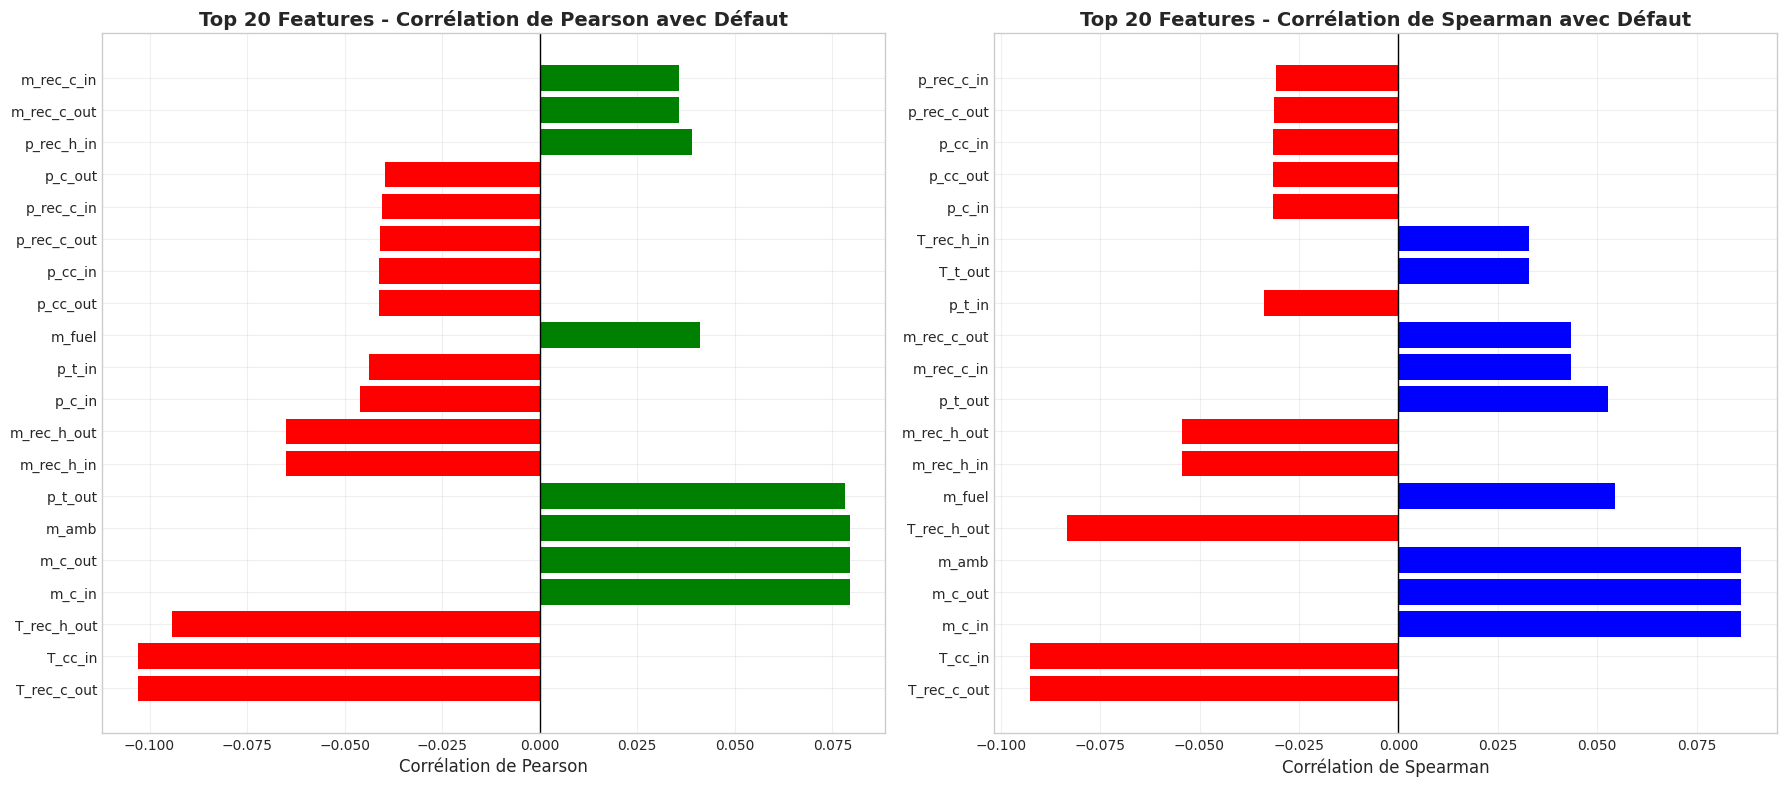


 1.2 Matrice de corrélation inter-features


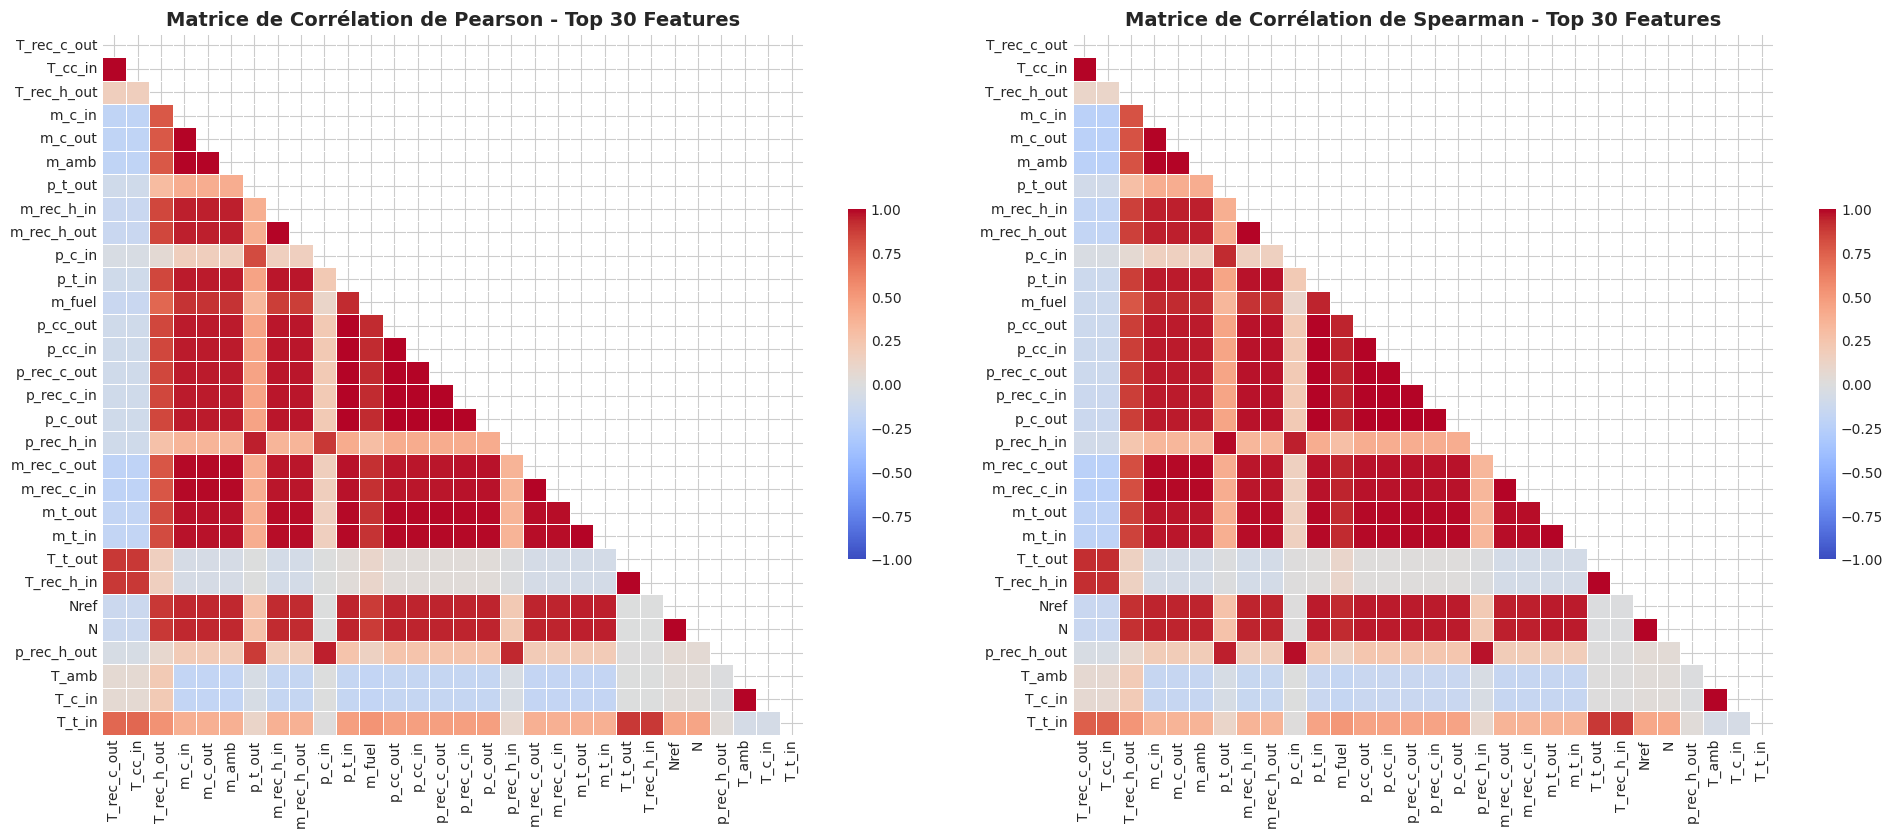


 1.3 Identification des groupes de features fortement corrélées

 Trouvé 180 paires avec |corrélation| > 0.8
        feature1     feature2  correlation
0    T_rec_c_out      T_cc_in          1.0
17        m_c_in      m_c_out          1.0
18        m_c_in        m_amb          1.0
34       m_c_out        m_amb          1.0
179        T_amb       T_c_in          1.0
161  m_rec_c_out   m_rec_c_in          1.0
68    m_rec_h_in  m_rec_h_out          1.0
120     p_cc_out      p_cc_in          1.0
175      T_t_out   T_rec_h_in          1.0
121     p_cc_out  p_rec_c_out          1.0

 1.4 Corrélation avec RUL (si disponible)


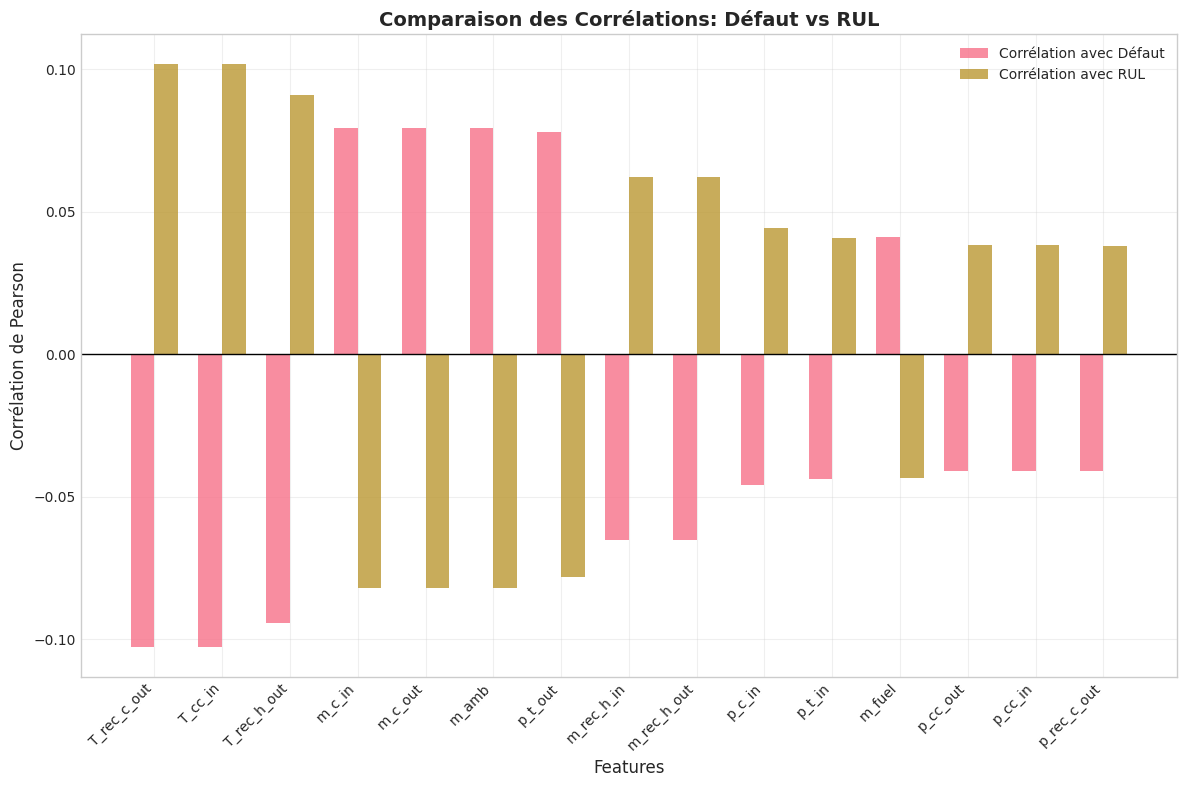

In [0]:
print("\n" + "="*60)
print(" PHASE 1.5: ANALYSE DE CORRÉLATION ET INTERACTIONS")
print("="*60)

from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Créer une colonne RUL (Remaining Useful Life) si elle n'existe pas
# Supposons que c'est lié au pourcentage
if 'RUL' not in df_train.columns:
    df_train['RUL'] = np.where(df_train['Defaut'] == 1, 
                                np.random.randint(0, 10, size=len(df_train)),
                                100 - df_train.get('pourcentage_reel', 50))

print("\n 1.1 Corrélation des features avec la cible (Defaut)")

correlations_target = {}
X_train_df = pd.DataFrame(X_train_full, columns=feature_names_full)

for col in feature_names_full:
    pearson_corr, _ = pearsonr(X_train_df[col], y_train)
    spearman_corr, _ = spearmanr(X_train_df[col], y_train)
    correlations_target[col] = {
        'pearson': pearson_corr,
        'spearman': spearman_corr
    }

df_corr_target = pd.DataFrame(correlations_target).T
df_corr_target = df_corr_target.sort_values('pearson', key=abs, ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

top20_pearson = df_corr_target.head(20)
ax1.barh(range(len(top20_pearson)), top20_pearson['pearson'].values, 
         color=['red' if x < 0 else 'green' for x in top20_pearson['pearson'].values])
ax1.set_yticks(range(len(top20_pearson)))
ax1.set_yticklabels(top20_pearson.index)
ax1.set_xlabel('Corrélation de Pearson')
ax1.set_title('Top 20 Features - Corrélation de Pearson avec Défaut', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='black', linewidth=1)

top20_spearman = df_corr_target.sort_values('spearman', key=abs, ascending=False).head(20)
ax2.barh(range(len(top20_spearman)), top20_spearman['spearman'].values,
         color=['red' if x < 0 else 'blue' for x in top20_spearman['spearman'].values])
ax2.set_yticks(range(len(top20_spearman)))
ax2.set_yticklabels(top20_spearman.index)
ax2.set_xlabel('Corrélation de Spearman')
ax2.set_title('Top 20 Features - Corrélation de Spearman avec Défaut', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='black', linewidth=1)

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'correlation_with_target.png'), dpi=300)
plt.show()

print("\n 1.2 Matrice de corrélation inter-features")

top30_features = df_corr_target.head(30).index.tolist()
X_top30 = X_train_df[top30_features]

pearson_matrix = X_top30.corr(method='pearson')
spearman_matrix = X_top30.corr(method='spearman')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

mask1 = np.triu(np.ones_like(pearson_matrix, dtype=bool))
sns.heatmap(pearson_matrix, mask=mask1, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Matrice de Corrélation de Pearson - Top 30 Features', fontsize=14, fontweight='bold')

mask2 = np.triu(np.ones_like(spearman_matrix, dtype=bool))
sns.heatmap(spearman_matrix, mask=mask2, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            ax=ax2, vmin=-1, vmax=1)
ax2.set_title('Matrice de Corrélation de Spearman - Top 30 Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'correlation_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n 1.3 Identification des groupes de features fortement corrélées")

high_corr_pairs = []
for i in range(len(pearson_matrix.columns)):
    for j in range(i+1, len(pearson_matrix.columns)):
        if abs(pearson_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'feature1': pearson_matrix.columns[i],
                'feature2': pearson_matrix.columns[j],
                'correlation': pearson_matrix.iloc[i, j]
            })

if high_corr_pairs:
    df_high_corr = pd.DataFrame(high_corr_pairs).sort_values('correlation', key=abs, ascending=False)
    print(f"\n Trouvé {len(df_high_corr)} paires avec |corrélation| > 0.8")
    print(df_high_corr.head(10))
    
print("\n 1.4 Corrélation avec RUL (si disponible)")

if 'RUL' in df_train.columns:
    correlations_rul = {}
    for col in feature_names_full:
        pearson_rul, _ = pearsonr(X_train_df[col], df_train['RUL'])
        spearman_rul, _ = spearmanr(X_train_df[col], df_train['RUL'])
        correlations_rul[col] = {
            'pearson_rul': pearson_rul,
            'spearman_rul': spearman_rul
        }
    
    df_corr_rul = pd.DataFrame(correlations_rul).T
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top15_features_combined = df_corr_target.head(15).index
    
    x = np.arange(len(top15_features_combined))
    width = 0.35
    
    corr_defaut = df_corr_target.loc[top15_features_combined, 'pearson'].values
    corr_rul = df_corr_rul.loc[top15_features_combined, 'pearson_rul'].values
    
    ax.bar(x - width/2, corr_defaut, width, label='Corrélation avec Défaut', alpha=0.8)
    ax.bar(x + width/2, corr_rul, width, label='Corrélation avec RUL', alpha=0.8)
    
    ax.set_xlabel('Features')
    ax.set_ylabel('Corrélation de Pearson')
    ax.set_title('Comparaison des Corrélations: Défaut vs RUL', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top15_features_combined, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linewidth=1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(EXPORT_DIR, 'correlation_defaut_vs_rul.png'), dpi=300)
    plt.show()

5. Cross-validation sur toutes les combinaisons (Phase 1)


 PHASE 2: CROSS-VALIDATION - TOUTES COMBINAISONS

 Test de toutes les combinaisons avec cross-validation...
 Total: 90 combinaisons



Combinaisons:   2%|▏         | 2/90 [00:08<06:31,  4.44s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:26:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:26:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:26:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:26:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databri

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  Mutual Info - Top 10 scores: [0.07349413 0.07349413 0.06136057 0.05950976 0.05502758 0.02863053
 0.02744878 0.02744878 0.02484156 0.0231922 ]
  Sélection: 24 features


Combinaisons:   8%|▊         | 7/90 [15:43<3:34:14, 154.87s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:42:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:42:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:42:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:42:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/data


  F-Classif - Top 10 F-scores: [47.56027293 47.56027293 39.75885962 28.19603359 28.19603359 28.19603359
 27.26107692 18.91427964 18.91427964  9.4250812 ]
  Sélection: 21 features


Combinaisons:  13%|█▎        | 12/90 [24:49<1:47:14, 82.50s/it] /databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:51:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:51:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:51:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:51:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/dat

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Combinaisons:  19%|█▉        | 17/90 [36:01<2:03:03, 101.14s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/dat

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RF Importance - Top 10 importances: [0.05287731 0.05094435 0.04985289 0.04869357 0.04709977 0.04584931
 0.03665574 0.03384073 0.03322793 0.0281886 ]
  Sélection: 34 features


Combinaisons:  24%|██▍       | 22/90 [44:46<1:23:02, 73.27s/it] /databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:11:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:11:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:11:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:11:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/dat

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  XGB Importance - Top 10 importances: [0.10637656 0.09662604 0.08160699 0.07231761 0.06288167 0.04661284
 0.040697   0.0406774  0.03618446 0.03148392]
  Sélection: 24 features


Combinaisons:  30%|███       | 27/90 [53:28<1:11:27, 68.05s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:19:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:19:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:19:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:19:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/data

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  Mutual Info - Top 10 scores: [0.07349413 0.07349413 0.06136057 0.05950976 0.05502758 0.02863053
 0.02744878 0.02744878 0.02484156 0.0231922 ]
  Sélection: 24 features


Combinaisons:  41%|████      | 37/90 [1:17:51<2:16:05, 154.07s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:44:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:44:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:44:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:44:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/d


  F-Classif - Top 10 F-scores: [47.56027293 47.56027293 39.75885962 28.19603359 28.19603359 28.19603359
 27.26107692 18.91427964 18.91427964  9.4250812 ]
  Sélection: 21 features


Combinaisons:  47%|████▋     | 42/90 [1:27:13<1:08:02, 85.04s/it] /databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:53:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:53:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:53:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:53:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/d

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Combinaisons:  52%|█████▏    | 47/90 [1:38:45<1:14:39, 104.17s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/d

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RF Importance - Top 10 importances: [0.05287731 0.05094435 0.04985289 0.04869357 0.04709977 0.04584931
 0.03665574 0.03384073 0.03322793 0.0281886 ]
  Sélection: 34 features


Combinaisons:  58%|█████▊    | 52/90 [1:47:40<47:28, 74.97s/it]   /databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:14:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:14:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:14:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:14:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/d

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  XGB Importance - Top 10 importances: [0.10637656 0.09662604 0.08160699 0.07231761 0.06288167 0.04661284
 0.040697   0.0406774  0.03618446 0.03148392]
  Sélection: 24 features


Combinaisons:  63%|██████▎   | 57/90 [1:56:32<38:19, 69.67s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/data

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  Mutual Info - Top 10 scores: [0.07349413 0.07349413 0.06136057 0.05950976 0.05502758 0.02863053
 0.02744878 0.02744878 0.02484156 0.0231922 ]
  Sélection: 24 features


Combinaisons:  74%|███████▍  | 67/90 [2:20:56<59:24, 154.99s/it]  /databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/d


  F-Classif - Top 10 F-scores: [47.56027293 47.56027293 39.75885962 28.19603359 28.19603359 28.19603359
 27.26107692 18.91427964 18.91427964  9.4250812 ]
  Sélection: 21 features


Combinaisons:  80%|████████  | 72/90 [2:30:04<25:07, 83.75s/it] /databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/dat

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Combinaisons:  86%|████████▌ | 77/90 [2:41:28<22:25, 103.52s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:07:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:07:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:07:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:07:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/dat

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RF Importance - Top 10 importances: [0.05287731 0.05094435 0.04985289 0.04869357 0.04709977 0.04584931
 0.03665574 0.03384073 0.03322793 0.0281886 ]
  Sélection: 34 features


Combinaisons:  91%|█████████ | 82/90 [2:50:20<09:56, 74.60s/it] /databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/dat

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  XGB Importance - Top 10 importances: [0.10637656 0.09662604 0.08160699 0.07231761 0.06288167 0.04661284
 0.040697   0.0406774  0.03618446 0.03148392]
  Sélection: 24 features


Combinaisons:  97%|█████████▋| 87/90 [2:59:12<03:28, 69.47s/it]/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:25:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:25:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:25:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/databricks/python/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:25:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/data


 Cross-validation terminée! 90 combinaisons testées
 Résultats sauvegardés dans 'cv_results_all_combinations.csv'

 ANALYSE DES RÉSULTATS DE CROSS-VALIDATION

 Top 10 combinaisons par F1-Score CV:
  scaler feature_method  n_features   model  cv_f1_mean  cv_f1_std
Standard         rfe_rf          19 XGBoost    0.761107   0.018867
  Robust            all          36 XGBoost    0.760342   0.021620
  Robust         rfe_rf          19 XGBoost    0.760199   0.016804
  MinMax            all          36 XGBoost    0.760043   0.020270
  MinMax         rfe_rf          19 XGBoost    0.759648   0.018871
Standard            all          36 XGBoost    0.758828   0.021661
Standard xgb_importance          24 XGBoost    0.758551   0.017456
  Robust xgb_importance          24 XGBoost    0.758017   0.018744
  MinMax xgb_importance          24 XGBoost    0.757588   0.018439
Standard  rf_importance          34 XGBoost    0.757513   0.017161

 MEILLEURE COMBINAISON:
 - Scaler: Standard
 - Feature Selection

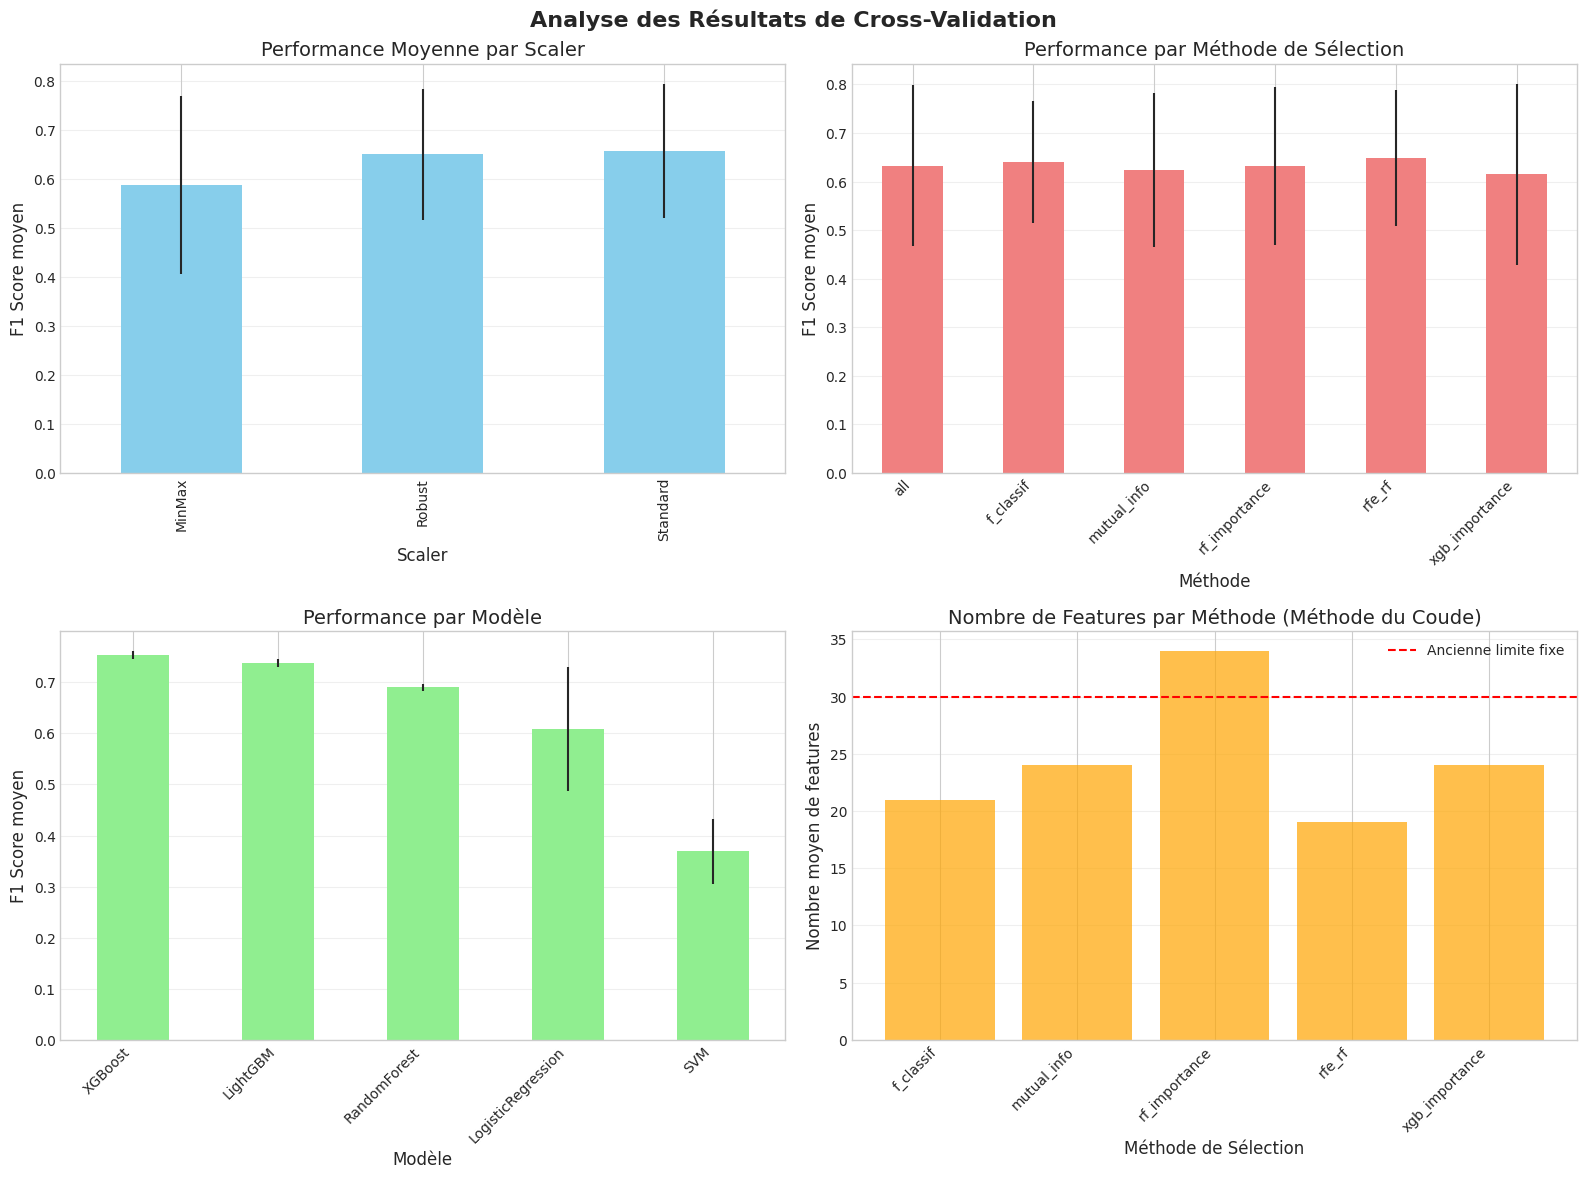

In [0]:
print("\n" + "="*60)
print(" PHASE 2: CROSS-VALIDATION - TOUTES COMBINAISONS")
print("="*60)

cv_results = []
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print("\n Test de toutes les combinaisons avec cross-validation...")
total_combinations = len(SCALERS) * len(FEATURE_METHODS) * len(MODELS)
print(f" Total: {total_combinations} combinaisons\n")

with tqdm(total=total_combinations, desc="Combinaisons") as pbar:
    for scaler_name, scaler in SCALERS.items():
        X_train_scaled = scaler.fit_transform(X_train_full)
        
        for feature_method in FEATURE_METHODS:

            if feature_method == "all":
                X_train_selected = X_train_scaled
                selected_features = feature_names_full
                n_features = len(selected_features)
            else:
                selected_indices = apply_feature_selection(X_train_scaled, y_train, feature_method)
                X_train_selected = X_train_scaled[:, selected_indices]
                selected_features = [feature_names_full[i] for i in selected_indices]
                n_features = len(selected_features)
            
            for model_name, model in MODELS.items():
                try:
                    # Cross-validation
                    scores = cross_val_score(model, X_train_selected, y_train, # Cross-validation
                                           cv=cv, scoring='f1', n_jobs=N_JOBS)
                    
                    result = {
                        'scaler': scaler_name,
                        'feature_method': feature_method,
                        'n_features': n_features,
                        'model': model_name,
                        'cv_f1_mean': scores.mean(),
                        'cv_f1_std': scores.std(),
                        'cv_f1_min': scores.min(),
                        'cv_f1_max': scores.max()
                    }
                    cv_results.append(result)
                    
                except Exception as e:
                    print(f"\n Erreur {scaler_name}-{feature_method}-{model_name}: {str(e)[:50]}")
                
                pbar.update(1)

df_cv = pd.DataFrame(cv_results)
df_cv.to_csv(os.path.join(EXPORT_DIR, 'cv_results_all_combinations.csv'), index=False)

print(f"\n Cross-validation terminée! {len(df_cv)} combinaisons testées")
print(f" Résultats sauvegardés dans 'cv_results_all_combinations.csv'")

print("\n" + "="*60)
print(" ANALYSE DES RÉSULTATS DE CROSS-VALIDATION")
print("="*60)

print("\n Top 10 combinaisons par F1-Score CV:")
top_10 = df_cv.nlargest(10, 'cv_f1_mean')
display_cols = ['scaler', 'feature_method', 'n_features', 'model', 'cv_f1_mean', 'cv_f1_std']
print(top_10[display_cols].to_string(index=False))

# Meilleure combinaison
best_combo = df_cv.loc[df_cv['cv_f1_mean'].idxmax()]
print(f"\n MEILLEURE COMBINAISON:")
print(f" - Scaler: {best_combo['scaler']}")
print(f" - Feature Selection: {best_combo['feature_method']} ({best_combo['n_features']} features)")
print(f" - Modèle: {best_combo['model']}")
print(f" - F1 Score CV: {best_combo['cv_f1_mean']:.3f} ± {best_combo['cv_f1_std']:.3f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Résultats de Cross-Validation', fontsize=16, fontweight='bold')

# 1. Performance par scaler
ax1 = axes[0, 0]
scaler_perf = df_cv.groupby('scaler')['cv_f1_mean'].agg(['mean', 'std'])
scaler_perf.plot(kind='bar', y='mean', yerr='std', ax=ax1, legend=False, color='skyblue')
ax1.set_title('Performance Moyenne par Scaler', fontsize=14)
ax1.set_xlabel('Scaler')
ax1.set_ylabel('F1 Score moyen')
ax1.grid(axis='y', alpha=0.3)

# 2. Performance par méthode de sélection
ax2 = axes[0, 1]
feature_perf = df_cv.groupby('feature_method')['cv_f1_mean'].agg(['mean', 'std'])
feature_perf.plot(kind='bar', y='mean', yerr='std', ax=ax2, legend=False, color='lightcoral')
ax2.set_title('Performance par Méthode de Sélection', fontsize=14)
ax2.set_xlabel('Méthode')
ax2.set_ylabel('F1 Score moyen')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Performance par modèle
ax3 = axes[1, 0]
model_perf = df_cv.groupby('model')['cv_f1_mean'].agg(['mean', 'std'])
model_perf = model_perf.sort_values('mean', ascending=False)
model_perf.plot(kind='bar', y='mean', yerr='std', ax=ax3, legend=False, color='lightgreen')
ax3.set_title('Performance par Modèle', fontsize=14)
ax3.set_xlabel('Modèle')
ax3.set_ylabel('F1 Score moyen')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Distribution du nombre de features sélectionnées
ax4 = axes[1, 1]
feature_counts = df_cv[df_cv['feature_method'] != 'all'].groupby('feature_method')['n_features'].mean()
ax4.bar(feature_counts.index, feature_counts.values, color='orange', alpha=0.7)
ax4.set_xlabel('Méthode de Sélection')
ax4.set_ylabel('Nombre moyen de features')
ax4.set_title('Nombre de Features par Méthode (Méthode du Coude)', fontsize=14)
ax4.axhline(y=30, color='red', linestyle='--', label='Ancienne limite fixe')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'cv_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()


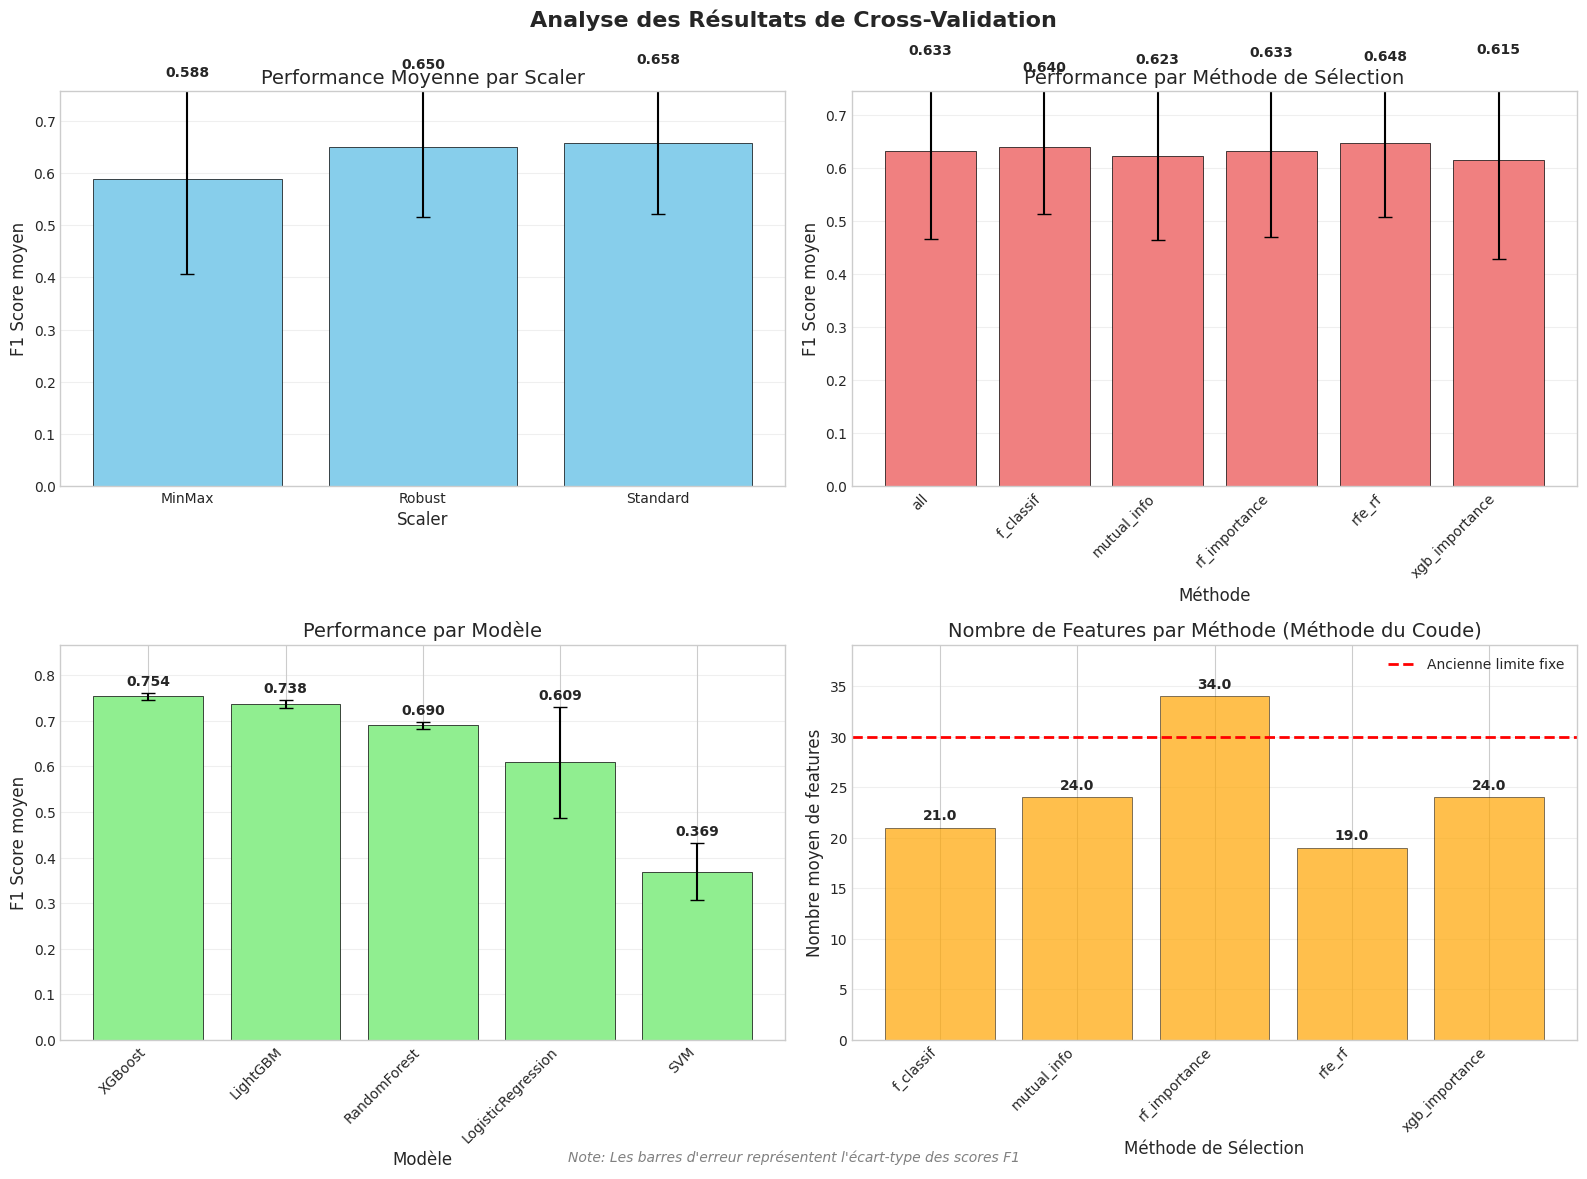

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Résultats de Cross-Validation', fontsize=16, fontweight='bold')

# 1. Performance par scaler avec valeurs sur les barres
ax1 = axes[0, 0]
scaler_perf = df_cv.groupby('scaler')['cv_f1_mean'].agg(['mean', 'std'])
bars1 = ax1.bar(scaler_perf.index, scaler_perf['mean'], yerr=scaler_perf['std'], 
                 capsize=5, color='skyblue', edgecolor='black', linewidth=0.5)
ax1.set_title('Performance Moyenne par Scaler', fontsize=14)
ax1.set_xlabel('Scaler')
ax1.set_ylabel('F1 Score moyen')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, max(scaler_perf['mean']) * 1.15)  

for bar, (idx, row) in zip(bars1, scaler_perf.iterrows()):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + row['std'] + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Performance par méthode de sélection avec valeurs sur les barres
ax2 = axes[0, 1]
feature_perf = df_cv.groupby('feature_method')['cv_f1_mean'].agg(['mean', 'std'])
bars2 = ax2.bar(feature_perf.index, feature_perf['mean'], yerr=feature_perf['std'], 
                 capsize=5, color='lightcoral', edgecolor='black', linewidth=0.5)
ax2.set_title('Performance par Méthode de Sélection', fontsize=14)
ax2.set_xlabel('Méthode')
ax2.set_ylabel('F1 Score moyen')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, max(feature_perf['mean']) * 1.15)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

for bar, (idx, row) in zip(bars2, feature_perf.iterrows()):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + row['std'] + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Performance par modèle avec valeurs sur les barres
ax3 = axes[1, 0]
model_perf = df_cv.groupby('model')['cv_f1_mean'].agg(['mean', 'std'])
model_perf = model_perf.sort_values('mean', ascending=False)
bars3 = ax3.bar(model_perf.index, model_perf['mean'], yerr=model_perf['std'], 
                 capsize=5, color='lightgreen', edgecolor='black', linewidth=0.5)
ax3.set_title('Performance par Modèle', fontsize=14)
ax3.set_xlabel('Modèle')
ax3.set_ylabel('F1 Score moyen')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(0, max(model_perf['mean']) * 1.15)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

for bar, (idx, row) in zip(bars3, model_perf.iterrows()):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + row['std'] + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Distribution du nombre de features sélectionnées avec valeurs sur les barres
ax4 = axes[1, 1]
feature_counts = df_cv[df_cv['feature_method'] != 'all'].groupby('feature_method')['n_features'].mean()
bars4 = ax4.bar(feature_counts.index, feature_counts.values, color='orange', alpha=0.7, 
                edgecolor='black', linewidth=0.5)
ax4.set_xlabel('Méthode de Sélection')
ax4.set_ylabel('Nombre moyen de features')
ax4.set_title('Nombre de Features par Méthode (Méthode du Coude)', fontsize=14)
ax4.axhline(y=30, color='red', linestyle='--', label='Ancienne limite fixe', linewidth=2)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0, max(feature_counts.values) * 1.15)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

for bar, (idx, value) in zip(bars4, feature_counts.items()):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{value:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()

fig.text(0.5, 0.02, 'Note: Les barres d\'erreur représentent l\'écart-type des scores F1', 
         ha='center', fontsize=10, style='italic', color='gray')

plt.savefig(os.path.join(EXPORT_DIR, 'cv_analysis_with_values.png'), dpi=300, bbox_inches='tight')
plt.show()

6. Analyse des features sélectionnées par les méthodes de sélection (Phase 2)


 PHASE 2.5: TRANSPARENCE DES SÉLECTIONS DE FEATURES


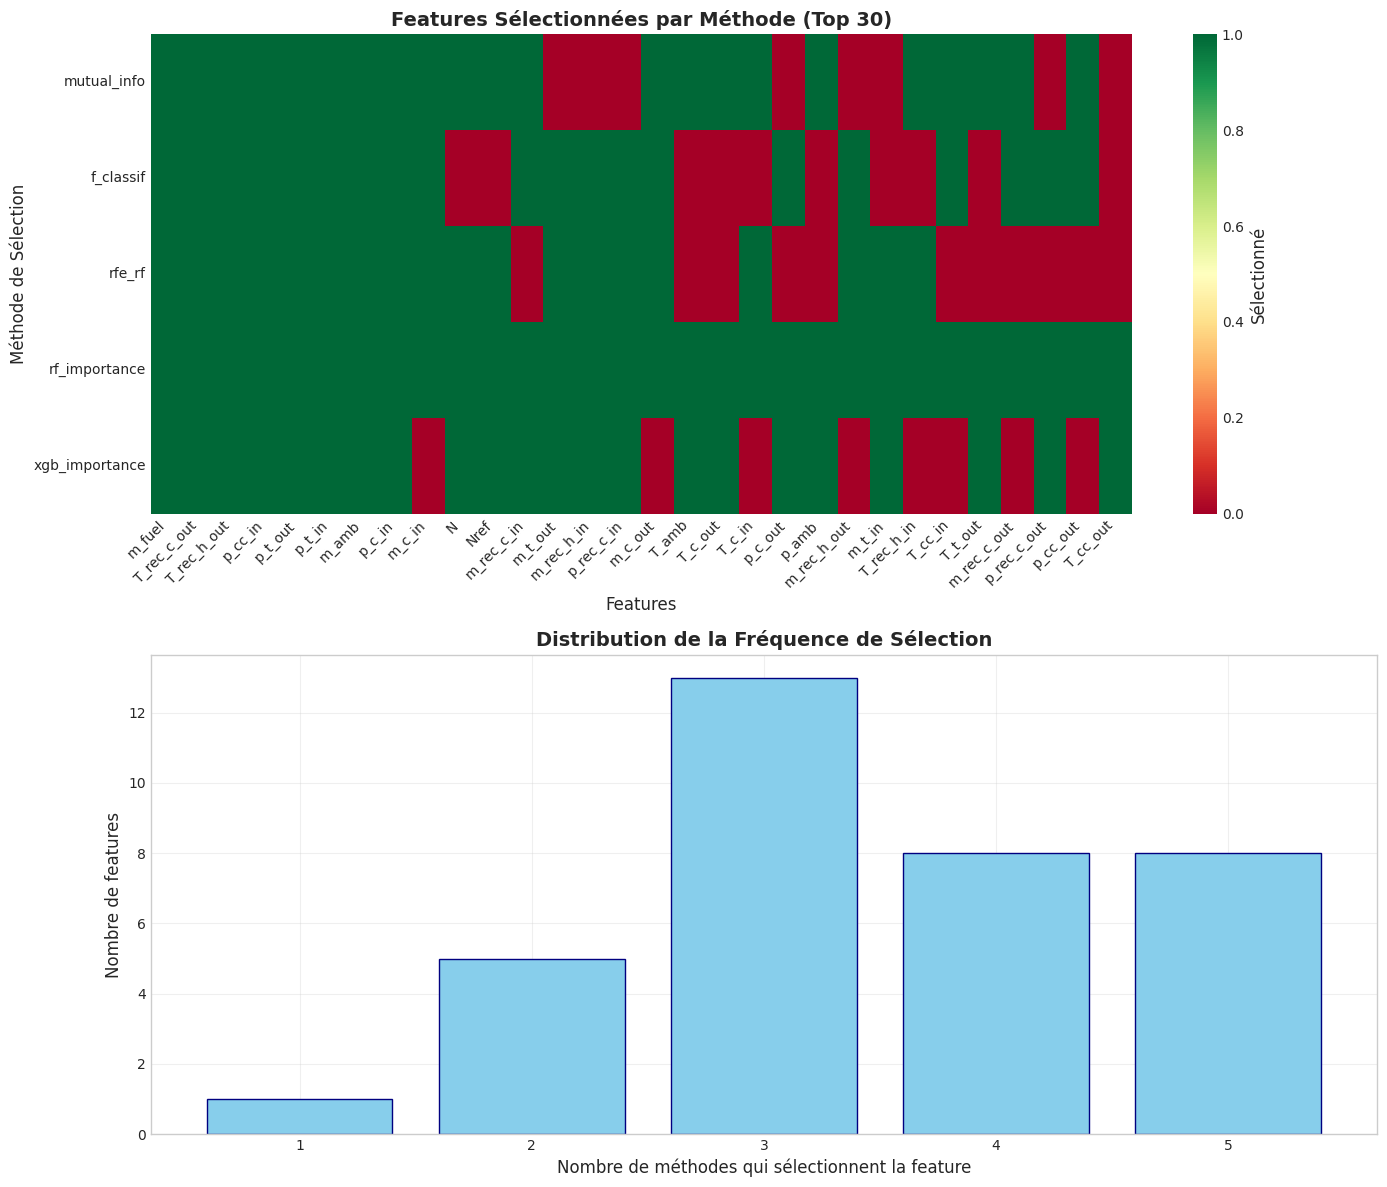


 Features sélectionnées par TOUTES les méthodes:
 1. m_fuel
 2. T_rec_c_out
 3. T_rec_h_out
 4. p_cc_in
 5. p_t_out
 6. p_t_in
 7. m_amb
 8. p_c_in

 Nombre de features par méthode:
 - mutual_info: 24 features
 - f_classif: 21 features
 - rfe_rf: 19 features
 - rf_importance: 34 features
 - xgb_importance: 24 features


In [0]:
print("\n" + "="*60)
print(" PHASE 2.5: TRANSPARENCE DES SÉLECTIONS DE FEATURES")
print("="*60)

feature_selection_summary = {}

for method in FEATURE_METHODS:
    if method in SELECTED_FEATURES_TRACKER and SELECTED_FEATURES_TRACKER[method]:
        selected_indices = SELECTED_FEATURES_TRACKER[method][0] # Prendre la première sélection comme référence
        if method != 'all':
            selected_names = [feature_names_full[i] for i in selected_indices]
            feature_selection_summary[method] = {
                'features': selected_names,
                'count': len(selected_names)
            }

all_selected_features = set()
for method_data in feature_selection_summary.values():
    all_selected_features.update(method_data['features'])

presence_matrix = []
feature_list = sorted(list(all_selected_features))

for feature in feature_list:
    row = {'feature': feature}
    for method, data in feature_selection_summary.items():
        row[method] = 1 if feature in data['features'] else 0
    presence_matrix.append(row)

df_presence = pd.DataFrame(presence_matrix)
df_presence['total_selections'] = df_presence.iloc[:, 1:].sum(axis=1)
df_presence = df_presence.sort_values('total_selections', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 1. Heatmap des features sélectionnées
top_features = df_presence.head(30)
heatmap_data = top_features.drop(['feature', 'total_selections'], axis=1).T
sns.heatmap(heatmap_data, xticklabels=top_features['feature'].values,
            cmap='RdYlGn', cbar_kws={'label': 'Sélectionné'}, ax=ax1)
ax1.set_title('Features Sélectionnées par Méthode (Top 30)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Features')
ax1.set_ylabel('Méthode de Sélection')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Fréquence de sélection
feature_freq = df_presence['total_selections'].value_counts().sort_index()
ax2.bar(feature_freq.index, feature_freq.values, color='skyblue', edgecolor='navy')
ax2.set_xlabel('Nombre de méthodes qui sélectionnent la feature')
ax2.set_ylabel('Nombre de features')
ax2.set_title('Distribution de la Fréquence de Sélection', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'feature_selection_transparency.png'), dpi=300)
plt.show()

print("\n Features sélectionnées par TOUTES les méthodes:")
consensus_features = df_presence[df_presence['total_selections'] == len(feature_selection_summary)]
if len(consensus_features) > 0:
    for idx, feature in enumerate(consensus_features['feature'].values, 1):
        print(f" {idx}. {feature}")
else:
    print(" Aucune feature sélectionnée par toutes les méthodes")

print(f"\n Nombre de features par méthode:")
for method, data in feature_selection_summary.items():
    print(f" - {method}: {data['count']} features")
 
df_presence.to_csv(os.path.join(EXPORT_DIR, 'feature_selection_details.csv'), index=False)

7. Test des modèles et leur configuration optimale sur les différents poucentages

In [0]:
print("\n" + "="*60)
print(" PHASE 3: TEST SUR DIFFÉRENTS POURCENTAGES")
print("="*60)

# Utiliser la meilleure combinaison de scaler, de méthode de sélection et le modèle 
best_scaler = SCALERS[best_combo['scaler']]
best_feature_method = best_combo['feature_method']
best_model_name = best_combo['model']

print(f"\n Utilisation de la meilleure combinaison pour les tests temporels:")
print(f" - {best_combo['scaler']} + {best_combo['feature_method']} + {best_combo['model']}")

temporal_results = []

for pct in tqdm(PERCENTAGES_TO_TEST, desc="Test sur pourcentages"):
    df_test = datasets_test[pct]
    
    X_test_full, y_test, _ = prepare_features(df_test)
    
    X_train_scaled = best_scaler.fit_transform(X_train_full)
    X_test_scaled = best_scaler.transform(X_test_full)
    
    if best_feature_method == "all":
        X_train_selected = X_train_scaled
        X_test_selected = X_test_scaled
    else:
        selected_indices = apply_feature_selection(X_train_scaled, y_train, best_feature_method)
        X_train_selected = X_train_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]
    
    if best_model_name in MODELS:
        model = MODELS[best_model_name].__class__(**MODELS[best_model_name].get_params())
    else:
        model = MODELS[best_model_name]
    
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = calculate_metrics(y_test, y_pred, y_prob)
    metrics['percentage'] = pct
    metrics['n_test'] = len(y_test)
    metrics['defaut_rate'] = y_test.mean()
    
    temporal_results.append(metrics)

df_temporal = pd.DataFrame(temporal_results)
df_temporal.to_csv(os.path.join(EXPORT_DIR, 'temporal_results.csv'), index=False)

print("\n Résultats temporels:")
print(df_temporal[['percentage', 'f1', 'precision', 'recall', 'auc']].to_string(index=False))



 PHASE 3: TEST SUR DIFFÉRENTS POURCENTAGES

 Utilisation de la meilleure combinaison pour les tests temporels:
 - Standard + rfe_rf + XGBoost


Test sur pourcentages:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  11%|█         | 1/9 [02:55<23:24, 175.57s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  22%|██▏       | 2/9 [05:49<20:21, 174.53s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  33%|███▎      | 3/9 [08:45<17:31, 175.17s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  44%|████▍     | 4/9 [11:38<14:32, 174.44s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  56%|█████▌    | 5/9 [14:30<11:34, 173.63s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  67%|██████▋   | 6/9 [17:24<08:41, 173.68s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  78%|███████▊  | 7/9 [20:19<05:48, 174.03s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages:  89%|████████▉ | 8/9 [23:11<02:53, 173.58s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test sur pourcentages: 100%|██████████| 9/9 [26:02<00:00, 173.66s/it]



 Résultats temporels:
 percentage       f1  precision   recall      auc
         10 0.367953   0.579439 0.269565 0.639018
         20 0.482115   0.846995 0.336957 0.769056
         30 0.653576   0.920949 0.506522 0.871910
         40 0.802993   0.941520 0.700000 0.911365
         50 0.839178   0.945504 0.754348 0.925789
         60 0.870588   0.948718 0.804348 0.929571
         70 0.879813   0.949622 0.819565 0.931574
         80 0.891455   0.950739 0.839130 0.933587
         90 0.892734   0.950860 0.841304 0.932418


8. Evolution comparative des modèles selon le score F1


 PHASE 3.5: ÉVOLUTION COMPARATIVE F1 - TOUS MODÈLES

 Test de tous les modèles sur l'évolution temporelle...


Modèles:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Modèles:  20%|██        | 1/5 [26:06<1:44:25, 1566.36s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Modèles:  40%|████      | 2/5 [53:20<1:20:19, 1606.48s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Modèles:  60%|██████    | 3/5 [1:19:59<53:25, 1602.66s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Modèles:  80%|████████  | 4/5 [1:47:59<27:13, 1633.51s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Modèles: 100%|██████████| 5/5 [2:17:06<00:00, 1645.23s/it]


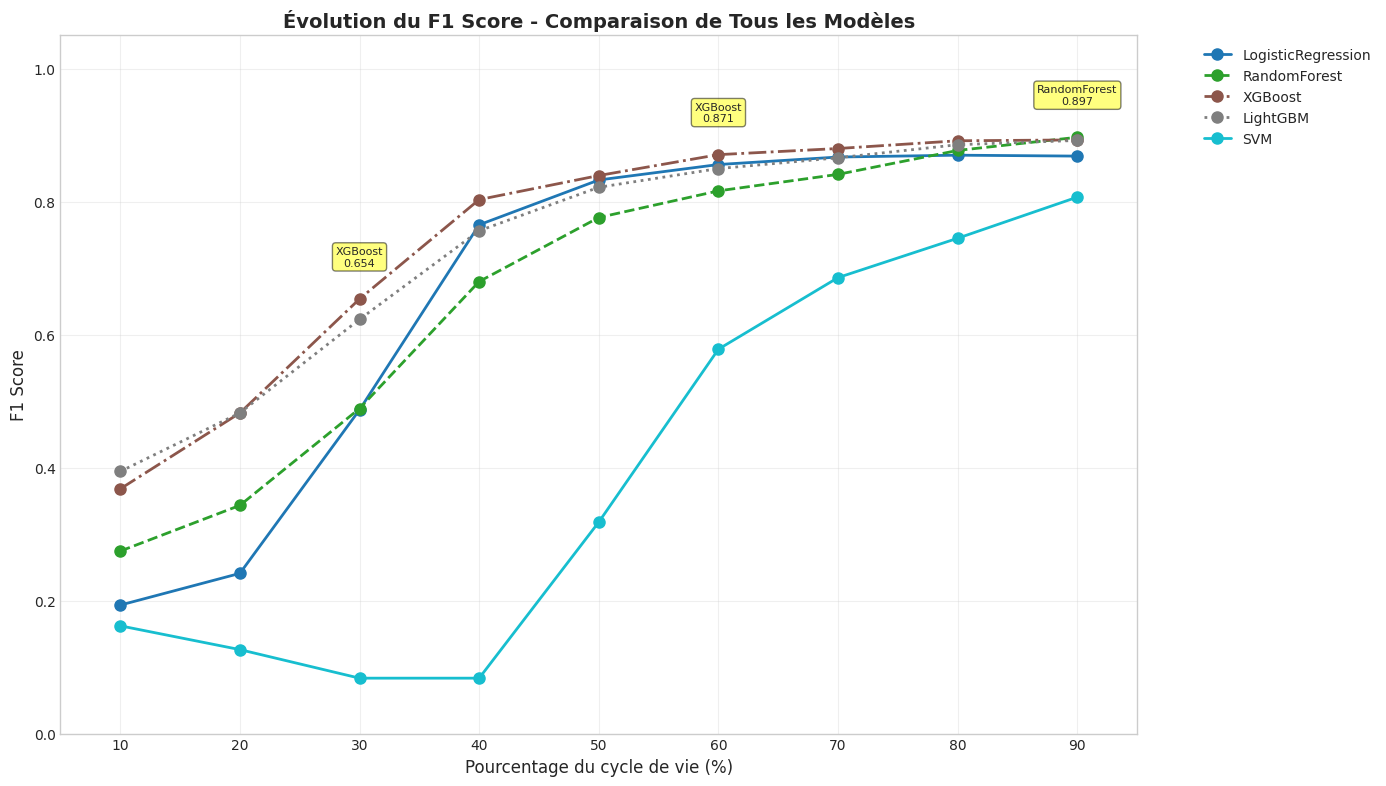


 Meilleur modèle par pourcentage:
 10% : LightGBM (F1=0.394)
 20% : LightGBM (F1=0.482)
 30% : XGBoost (F1=0.654)
 40% : XGBoost (F1=0.803)
 50% : XGBoost (F1=0.839)
 60% : XGBoost (F1=0.871)
 70% : XGBoost (F1=0.880)
 80% : XGBoost (F1=0.891)
 90% : RandomForest (F1=0.897)


In [0]:
print("\n" + "="*60)
print(" PHASE 3.5: ÉVOLUTION COMPARATIVE F1 - TOUS MODÈLES")
print("="*60)

all_models_temporal = defaultdict(list)

print("\n Test de tous les modèles sur l'évolution temporelle...")

for model_name, model_class in tqdm(MODELS.items(), desc="Modèles"):
    for pct in PERCENTAGES_TO_TEST:
        df_test = datasets_test[pct]
        
        X_test_full, y_test, _ = prepare_features(df_test)
        
        X_train_scaled = best_scaler.fit_transform(X_train_full)
        X_test_scaled = best_scaler.transform(X_test_full)
        
        if best_feature_method == "all":
            X_train_selected = X_train_scaled
            X_test_selected = X_test_scaled
        else:
            selected_indices = apply_feature_selection(X_train_scaled, y_train, best_feature_method)
            X_train_selected = X_train_scaled[:, selected_indices]
            X_test_selected = X_test_scaled[:, selected_indices]
        
        model = model_class.__class__(**model_class.get_params())
        model.fit(X_train_selected, y_train)
        
        y_pred = model.predict(X_test_selected)
        
        f1 = f1_score(y_test, y_pred)
        all_models_temporal[model_name].append({
            'percentage': pct,
            'f1': f1
        })

plt.figure(figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(MODELS)))
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']

for idx, (model_name, results) in enumerate(all_models_temporal.items()):
    df_model = pd.DataFrame(results)
    plt.plot(df_model['percentage'], df_model['f1'], 
             marker='o', linewidth=2, markersize=8,
             label=model_name, color=colors[idx], 
             linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Pourcentage du cycle de vie (%)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Évolution du F1 Score - Comparaison de Tous les Modèles', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(5, 95)
plt.ylim(0, 1.05)

for pct in PERCENTAGES_TO_TEST:
    best_at_pct = max([(m, [r['f1'] for r in res if r['percentage'] == pct][0]) 
                       for m, res in all_models_temporal.items()], 
                      key=lambda x: x[1])
    if pct in [30, 60, 90]:  
        plt.annotate(f'{best_at_pct[0]}\n{best_at_pct[1]:.3f}', 
                    xy=(pct, best_at_pct[1]), 
                    xytext=(pct, best_at_pct[1] + 0.05),
                    ha='center', fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'f1_evolution_all_models.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n Meilleur modèle par pourcentage:")
for pct in PERCENTAGES_TO_TEST:
    best_model = max([(m, [r['f1'] for r in res if r['percentage'] == pct][0]) 
                      for m, res in all_models_temporal.items()], 
                     key=lambda x: x[1])
    print(f" {pct}% : {best_model[0]} (F1={best_model[1]:.3f})")

9. Comparaison de tous les modèles sur le test pré-défaut 


 PHASE 3.5: TEST PRÉ-DÉFAUT - COMPARAISON DES FAUSSES ALARMES

 Test de tous les modèles sur données pré-défaut...


Test pré-défaut:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test pré-défaut:  20%|██        | 1/5 [00:07<00:30,  7.72s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test pré-défaut:  40%|████      | 2/5 [00:22<00:35, 11.89s/it]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test pré-défaut:  60%|██████    | 3/5 [00:30<00:20, 10.03s/it]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test pré-défaut:  80%|████████  | 4/5 [00:38<00:09,  9.33s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test pré-défaut: 100%|██████████| 5/5 [00:55<00:00, 11.19s/it]



 Résultats sur données pré-défaut (SANS TUNING):
 - Nombre d'échantillons: 460
 - Vrais labels: tous = 0 (pas de défaut)

 Taux de fausses alarmes par modèle:
             model  false_alarms  false_alarm_rate  prob_mean
               SVM            51          0.110870   0.396018
LogisticRegression            69          0.150000   0.336262
      RandomForest           100          0.217391   0.440386
           XGBoost           130          0.282609   0.427105
          LightGBM           144          0.313043   0.443561


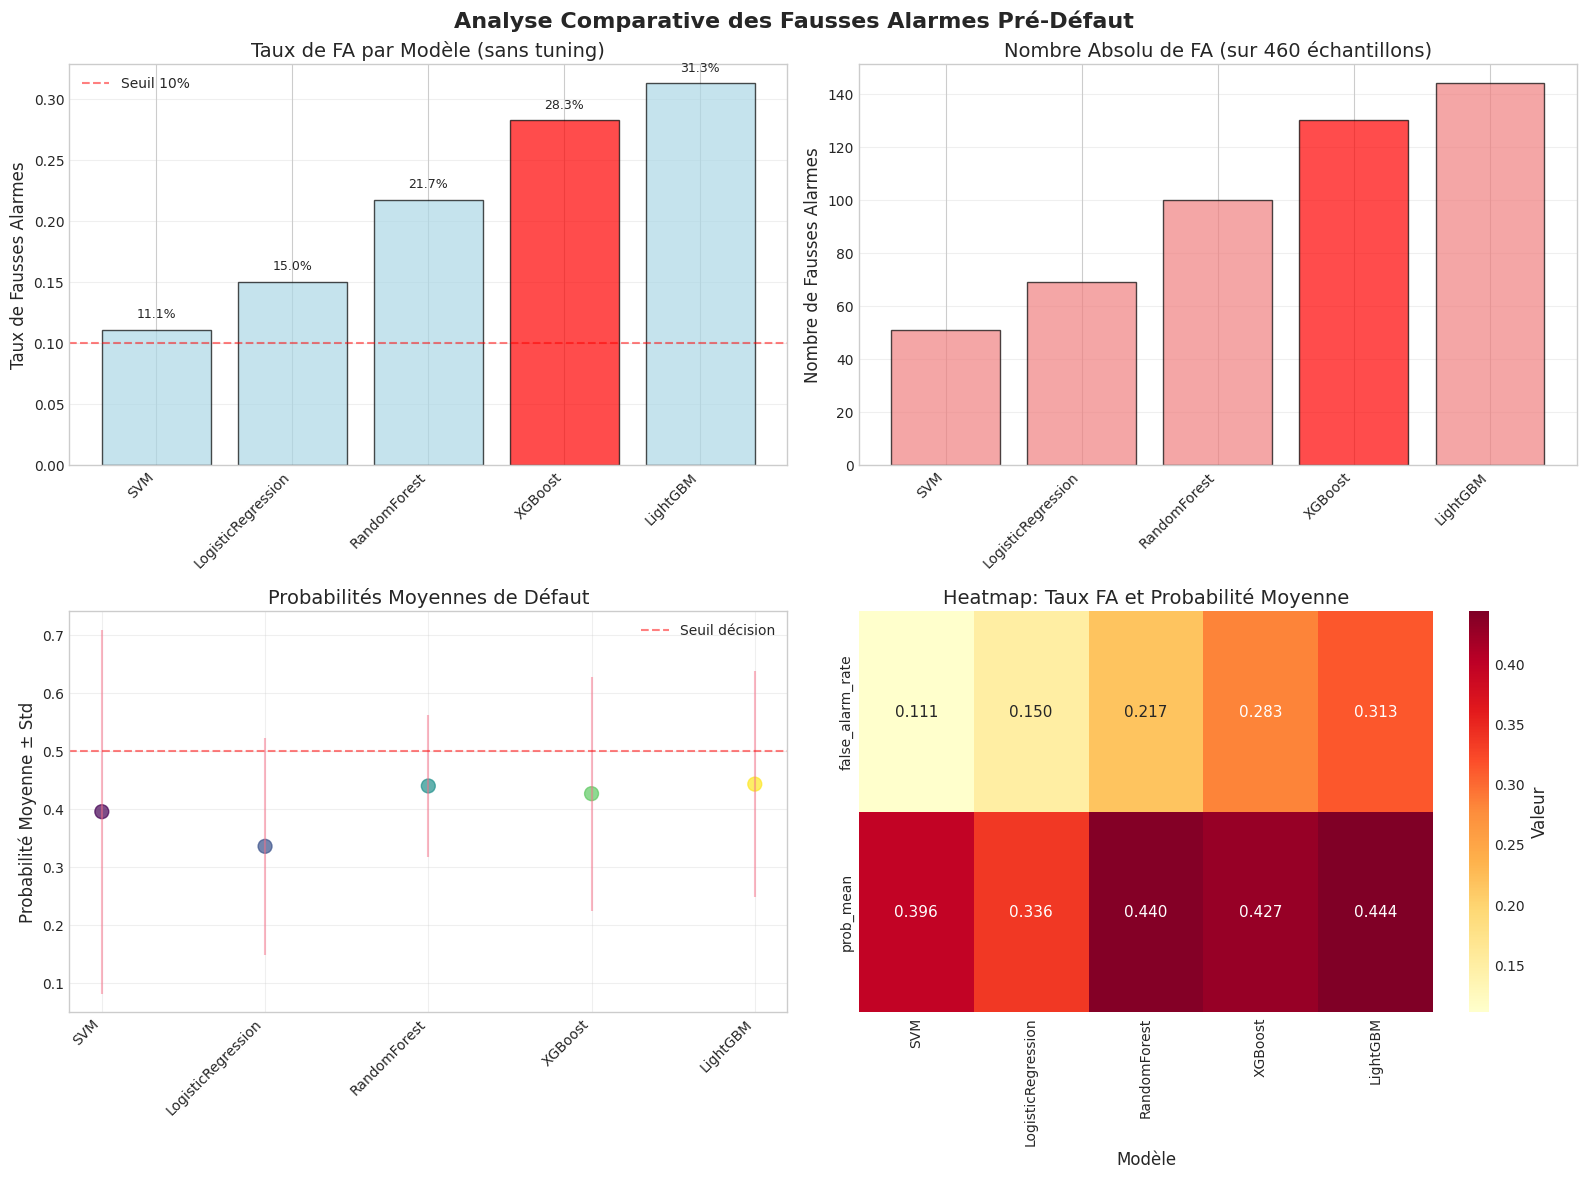


 ANALYSE DES FAUSSES ALARMES

✅ Meilleur modèle (moins de FA): SVM
   - Taux FA: 11.09%
   - Nombre FA: 51

❌ Pire modèle (plus de FA): LightGBM
   - Taux FA: 31.30%
   - Nombre FA: 144

📊 Modèle sélectionné (XGBoost):
   - Taux FA: 28.26%
   - Rang: 4/5


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

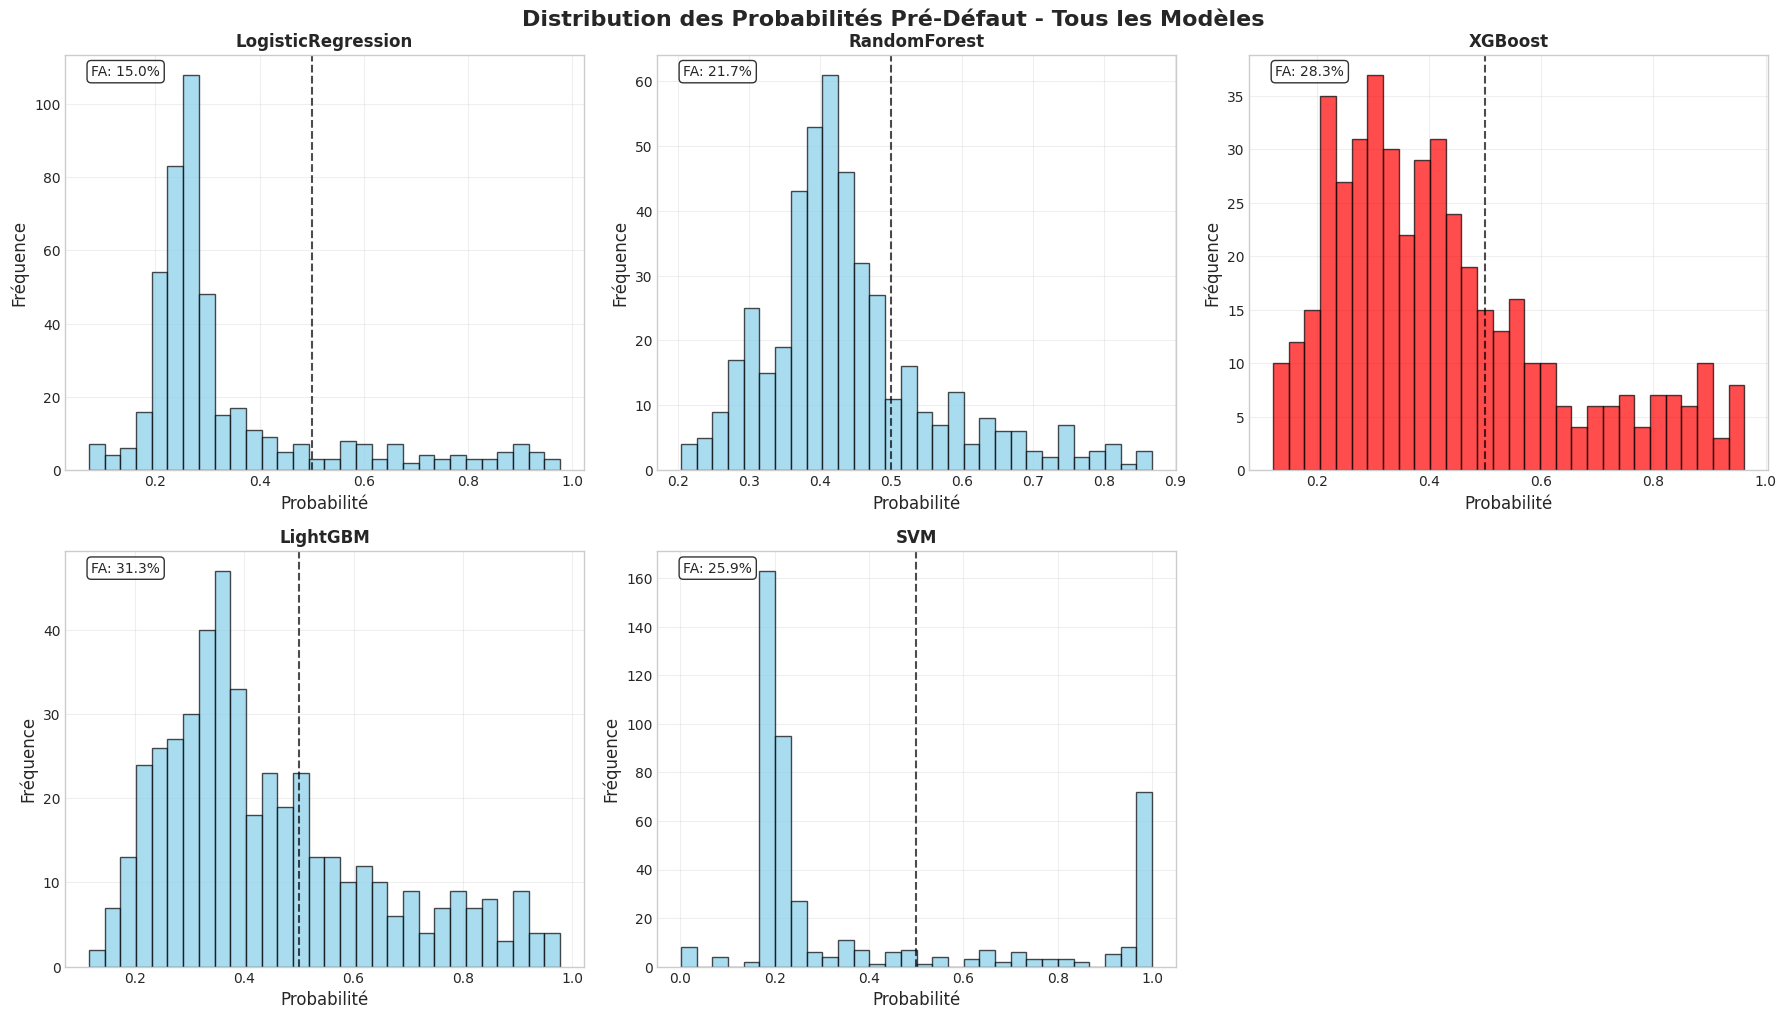

In [0]:
print("\n" + "="*60)
print(" PHASE 3.5: TEST PRÉ-DÉFAUT - COMPARAISON DES FAUSSES ALARMES")
print("="*60)

X_predefaut_full, y_predefaut, _ = prepare_features(df_predefaut)
X_predefaut_scaled = best_scaler.transform(X_predefaut_full)

if best_feature_method == "all":
    X_predefaut_selected = X_predefaut_scaled
else:
    X_predefaut_selected = X_predefaut_scaled[:, selected_indices]

predefaut_results = []

print("\n Test de tous les modèles sur données pré-défaut...")
for model_name, model_class in tqdm(MODELS.items(), desc="Test pré-défaut"):

    model = model_class.__class__(**model_class.get_params())
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_predefaut_selected)
    y_prob = model.predict_proba(X_predefaut_selected)[:, 1] if hasattr(model, "predict_proba") else None
    
    false_alarms = (y_pred == 1).sum()
    false_alarm_rate = (y_pred == 1).mean()
    
    if y_prob is not None:
        prob_mean = y_prob.mean()
        prob_std = y_prob.std()
        prob_max = y_prob.max()
        prob_above_threshold = (y_prob > 0.5).sum()
    else:
        prob_mean = prob_std = prob_max = prob_above_threshold = None
    
    predefaut_results.append({
        'model': model_name,
        'false_alarms': false_alarms,
        'false_alarm_rate': false_alarm_rate,
        'prob_mean': prob_mean,
        'prob_std': prob_std,
        'prob_max': prob_max,
        'predictions_positive': prob_above_threshold
    })
    
    if model_name == best_model_name:
        y_pred_predefaut = y_pred
        y_prob_predefaut = y_prob
        false_alarm_rate = false_alarm_rate

df_predefaut = pd.DataFrame(predefaut_results)
df_predefaut = df_predefaut.sort_values('false_alarm_rate')

print("\n Résultats sur données pré-défaut (SANS TUNING):")
print(f" - Nombre d'échantillons: {len(y_predefaut)}")
print(f" - Vrais labels: tous = 0 (pas de défaut)")
print("\n Taux de fausses alarmes par modèle:")
print(df_predefaut[['model', 'false_alarms', 'false_alarm_rate', 'prob_mean']].to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse Comparative des Fausses Alarmes Pré-Défaut', fontsize=16, fontweight='bold')

# 1. Barplot des taux de fausses alarmes
ax1 = axes[0, 0]
colors = ['red' if m == best_model_name else 'lightblue' for m in df_predefaut['model']]
bars = ax1.bar(range(len(df_predefaut)), df_predefaut['false_alarm_rate'], 
                color=colors, edgecolor='black', alpha=0.7)
ax1.set_xticks(range(len(df_predefaut)))
ax1.set_xticklabels(df_predefaut['model'], rotation=45, ha='right')
ax1.set_ylabel('Taux de Fausses Alarmes')
ax1.set_title('Taux de FA par Modèle (sans tuning)')
ax1.grid(True, axis='y', alpha=0.3)

for i, (idx, row) in enumerate(df_predefaut.iterrows()):
    ax1.text(i, row['false_alarm_rate'] + 0.01, f"{row['false_alarm_rate']:.1%}", 
             ha='center', fontsize=9)

ax1.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Seuil 10%')
ax1.legend()

# 2. Nombre absolu de fausses alarmes
ax2 = axes[0, 1]
colors2 = ['red' if m == best_model_name else 'lightcoral' for m in df_predefaut['model']]
ax2.bar(range(len(df_predefaut)), df_predefaut['false_alarms'], 
        color=colors2, edgecolor='black', alpha=0.7)
ax2.set_xticks(range(len(df_predefaut)))
ax2.set_xticklabels(df_predefaut['model'], rotation=45, ha='right')
ax2.set_ylabel('Nombre de Fausses Alarmes')
ax2.set_title(f'Nombre Absolu de FA (sur {len(y_predefaut)} échantillons)')
ax2.grid(True, axis='y', alpha=0.3)

# 3. Distribution des probabilités moyennes
ax3 = axes[1, 0]
df_with_probs = df_predefaut.dropna(subset=['prob_mean'])
if len(df_with_probs) > 0:
    ax3.scatter(range(len(df_with_probs)), df_with_probs['prob_mean'], 
                s=100, alpha=0.7, c=range(len(df_with_probs)), cmap='viridis')
    ax3.errorbar(range(len(df_with_probs)), df_with_probs['prob_mean'], 
                 yerr=df_with_probs['prob_std'], fmt='none', alpha=0.5)
    ax3.set_xticks(range(len(df_with_probs)))
    ax3.set_xticklabels(df_with_probs['model'], rotation=45, ha='right')
    ax3.set_ylabel('Probabilité Moyenne ± Std')
    ax3.set_title('Probabilités Moyennes de Défaut')
    ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil décision')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Heatmap comparative
ax4 = axes[1, 1]
metrics_matrix = df_predefaut[['false_alarm_rate', 'prob_mean']].T
metrics_matrix.columns = df_predefaut['model']
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            ax=ax4, cbar_kws={'label': 'Valeur'})
ax4.set_title('Heatmap: Taux FA et Probabilité Moyenne')
ax4.set_xlabel('Modèle')

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'predefaut_comparison_all_models.png'), dpi=300)
plt.show()

best_fa_model = df_predefaut.iloc[0]
worst_fa_model = df_predefaut.iloc[-1]

print("\n" + "="*40)
print(" ANALYSE DES FAUSSES ALARMES")
print("="*40)
print(f"\n Meilleur modèle (moins de FA): {best_fa_model['model']}")
print(f"   - Taux FA: {best_fa_model['false_alarm_rate']:.2%}")
print(f"   - Nombre FA: {best_fa_model['false_alarms']}")

print(f"\n Pire modèle (plus de FA): {worst_fa_model['model']}")
print(f"   - Taux FA: {worst_fa_model['false_alarm_rate']:.2%}")
print(f"   - Nombre FA: {worst_fa_model['false_alarms']}")

print(f"\n Modèle sélectionné ({best_model_name}):")
selected_model_fa = df_predefaut[df_predefaut['model'] == best_model_name].iloc[0]
print(f"   - Taux FA: {selected_model_fa['false_alarm_rate']:.2%}")
print(f"   - Rang: {df_predefaut['model'].tolist().index(best_model_name) + 1}/{len(df_predefaut)}")

if any(df_predefaut['prob_mean'].notna()):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()
    
    for idx, (model_name, model_class) in enumerate(MODELS.items()):
        if idx < 9:  
            ax = axes[idx]
            
            model = model_class.__class__(**model_class.get_params())
            model.fit(X_train_selected, y_train)
            
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_predefaut_selected)[:, 1]
                
                ax.hist(y_prob, bins=30, alpha=0.7, edgecolor='black', 
                       color='red' if model_name == best_model_name else 'skyblue')
                ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.7)
                
                fa_rate = (y_prob > 0.5).mean()
                ax.text(0.05, 0.95, f'FA: {fa_rate:.1%}', 
                       transform=ax.transAxes, fontsize=10, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Probabilité')
                ax.set_ylabel('Fréquence')
                ax.grid(True, alpha=0.3)
    
    for idx in range(len(MODELS), 9):
        axes[idx].set_visible(False)
    
    plt.suptitle('Distribution des Probabilités Pré-Défaut - Tous les Modèles', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(EXPORT_DIR, 'predefaut_distributions_all_models.png'), dpi=300)
    plt.show()

df_predefaut.to_csv(os.path.join(EXPORT_DIR, 'false_alarm_comparison.csv'), index=False)

10. Optimisation bayésienne des 3 meilleurs modèles sur le F1_score


 PHASE 4: OPTIMISATION BAYÉSIENNE - TOP 3 MODÈLES

 Identification des top 3 modèles à optimiser...

 Performance MOYENNE par modèle (toutes configurations confondues):
                    f1_moyenne  f1_max  f1_std  n_configs
model                                                    
XGBoost                  0.754   0.761   0.008         18
LightGBM                 0.738   0.749   0.008         18
RandomForest             0.690   0.700   0.007         18
LogisticRegression       0.609   0.721   0.122         18
SVM                      0.369   0.457   0.063         18

 Top 3 modèles sélectionnés (basé sur F1 MOYEN): ['XGBoost', 'LightGBM', 'RandomForest']

 Configuration optimale pour chaque modèle du top 3:
 - XGBoost: 
   • F1 moyen (toutes configs): 0.754
   • Meilleure config: Standard + rfe_rf → F1=0.761
 - LightGBM: 
   • F1 moyen (toutes configs): 0.738
   • Meilleure config: Standard + xgb_importance → F1=0.749
 - RandomForest: 
   • F1 moyen (toutes configs): 0.690
   • Meil

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


  0%|          | 0/50 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats pour XGBoost:
 - F1 avant optimisation: 0.761
 - F1 après optimisation: 0.796
 - Amélioration: +0.035
 - Meilleurs hyperparamètres:
   • n_estimators: 157
   • max_depth: 11
   • learning_rate: 0.08797274223151251
   • subsample: 0.804600242351985
   • colsample_bytree: 0.9520104938890753
   • gamma: 0.16715612405251706
   • reg_alpha: 1.8124356272107653e-07
   • reg_lambda: 0.06543843363179302
   • scale_pos_weight: 1.78786655909241

 Optimisation 59/3: LightGBM
 Configuration: Standard + xgb_importance


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  XGB Importance - Top 10 importances: [0.10637656 0.09662604 0.08160699 0.07231761 0.06288167 0.04661284
 0.040697   0.0406774  0.03618446 0.03148392]
  Sélection: 24 features


  0%|          | 0/50 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats pour LightGBM:
 - F1 avant optimisation: 0.749
 - F1 après optimisation: 0.800
 - Amélioration: +0.051
 - Meilleurs hyperparamètres:
   • n_estimators: 256
   • num_leaves: 179
   • max_depth: 15
   • learning_rate: 0.07299859078250866
   • feature_fraction: 0.8793929679862424
   • bagging_fraction: 0.679082096535826
   • bagging_freq: 4
   • min_child_samples: 24
   • reg_alpha: 7.658392866657557e-08
   • reg_lambda: 0.05896275902711164

 Optimisation 17/3: RandomForest
 Configuration: MinMax + rfe_rf


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


  RFE-RF - Features sélectionnées: 19


  0%|          | 0/50 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats pour RandomForest:
 - F1 avant optimisation: 0.700
 - F1 après optimisation: 0.759
 - Amélioration: +0.059
 - Meilleurs hyperparamètres:
   • n_estimators: 291
   • max_depth: 20
   • min_samples_split: 6
   • min_samples_leaf: 3
   • max_features: None
   • class_weight: balanced

 COMPARAISON DES MODÈLES OPTIMISÉS

 Tableau comparatif:
       model  cv_f1_before  optuna_f1_best  improvement  n_trials  best_trial
    LightGBM      0.749018        0.800000     0.050982        50          31
     XGBoost      0.761107        0.796380     0.035274        50          23
RandomForest      0.700292        0.759055     0.058763        50          12


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

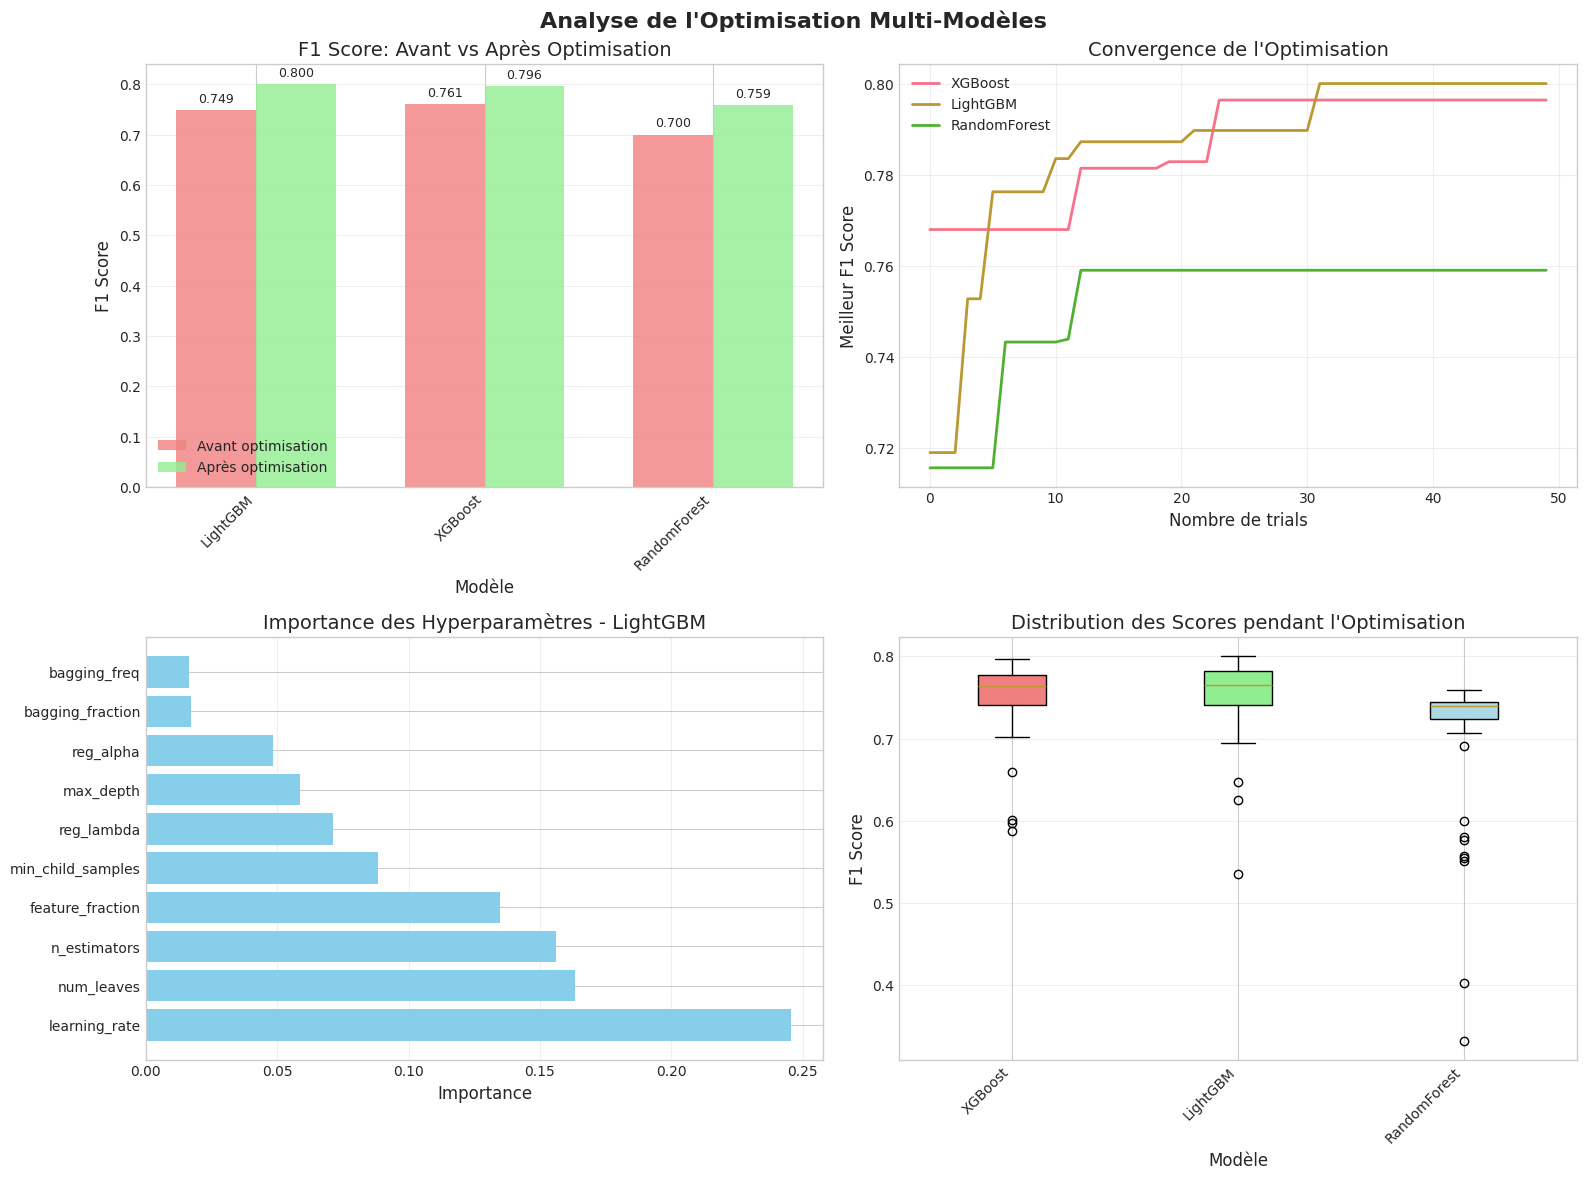


 MODÈLE SÉLECTIONNÉ: LightGBM
 - F1 Score final: 0.800
 - Configuration: Standard + xgb_importance
 - Amélioration: +0.051

✓ Optimisation multi-modèles terminée!


In [0]:
print("\n" + "="*60)
print(" PHASE 4: OPTIMISATION BAYÉSIENNE - TOP 3 MODÈLES")
print("="*60)

def create_objective(model_type, X_train, y_train, X_val, y_val):
    """Crée une fonction objective pour Optuna"""
    
    def objective(trial):
        if model_type == "LogisticRegression":
            params = {
                'C': trial.suggest_float('C', 0.001, 100, log=True),
                'penalty': 'l2',
                'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
                'max_iter': 1000,
                'random_state': RANDOM_STATE
            }
            model = LogisticRegression(**params)
            
        elif model_type == "RandomForest":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
                'random_state': RANDOM_STATE,
                'n_jobs': N_JOBS
            }
            model = RandomForestClassifier(**params)
            
        elif model_type == "XGBoost":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 10),
                'random_state': RANDOM_STATE,
                'use_label_encoder': False,
                'eval_metric': 'logloss',
                'n_jobs': N_JOBS
            }
            model = XGBClassifier(**params)
            
        elif model_type == "LightGBM":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'random_state': RANDOM_STATE,
                'verbosity': -1
            }
            model = LGBMClassifier(**params)
            
        elif model_type == "SVM":
            params = {
                'C': trial.suggest_float('C', 0.1, 100, log=True),
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
                'kernel': 'rbf',
                'probability': True,
                'random_state': RANDOM_STATE
            }
            model = SVC(**params)
            
        elif model_type == "GradientBoosting":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'random_state': RANDOM_STATE
            }
            model = GradientBoostingClassifier(**params)
            
        elif model_type == "ExtraTrees":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
                'random_state': RANDOM_STATE,
                'n_jobs': N_JOBS
            }
            model = ExtraTreesClassifier(**params)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val) # Prédiction sur validation
        
        return f1_score(y_val, y_pred) # F1 score est la métrique à optimiser
    
    return objective

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split( # Split train/validation pour l'optimisation
    X_train_selected, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# 1. Identifier les top 3 modèles basés sur la performance moyenne
print("\n Identification des top 3 modèles à optimiser...")

model_avg_performance = df_cv.groupby('model')['cv_f1_mean'].agg(['mean', 'max', 'std', 'count']).round(3)
model_avg_performance.columns = ['f1_moyenne', 'f1_max', 'f1_std', 'n_configs']
model_avg_performance = model_avg_performance.sort_values('f1_moyenne', ascending=False)

print("\n Performance MOYENNE par modèle (toutes configurations confondues):")
print(model_avg_performance)

top_3_models_names = model_avg_performance.head(3).index.tolist()
print(f"\n Top 3 modèles sélectionnés (basé sur F1 MOYEN): {top_3_models_names}")

top_3_models_df = pd.DataFrame()
for model_name in top_3_models_names:
    best_config_for_model = df_cv[df_cv['model'] == model_name].nlargest(1, 'cv_f1_mean')
    top_3_models_df = pd.concat([top_3_models_df, best_config_for_model])

print("\n Configuration optimale pour chaque modèle du top 3:")
for idx, row in top_3_models_df.iterrows():
    avg_f1 = model_avg_performance.loc[row['model'], 'f1_moyenne']
    print(f" - {row['model']}: ")
    print(f"   • F1 moyen (toutes configs): {avg_f1:.3f}")
    print(f"   • Meilleure config: {row['scaler']} + {row['feature_method']} → F1={row['cv_f1_mean']:.3f}")

# 2. Optimiser chaque modèle
optimized_models = {}
optimization_results = []

for idx, row in top_3_models_df.iterrows():
    model_name = row['model']
    model_scaler = row['scaler']
    model_feature_method = row['feature_method']
    
    print(f"\n{'='*50}")
    print(f" Optimisation {idx+1}/3: {model_name}")
    print(f" Configuration: {model_scaler} + {model_feature_method}")
    print('='*50)
    
    scaler = SCALERS[model_scaler]
    X_train_scaled_model = scaler.fit_transform(X_train_full)
    
    if model_feature_method == "all":
        X_train_selected_model = X_train_scaled_model
        selected_features_model = feature_names_full
    else:
        selected_indices_model = apply_feature_selection(X_train_scaled_model, y_train, model_feature_method)
        X_train_selected_model = X_train_scaled_model[:, selected_indices_model]
        selected_features_model = [feature_names_full[i] for i in selected_indices_model]
    
    X_opt_model, X_val_model, y_opt_model, y_val_model = train_test_split(
        X_train_selected_model, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
    )
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'{model_name}_optimization',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )

    objective = create_objective(model_name, X_opt_model, y_opt_model, X_val_model, y_val_model)
    
    n_trials_per_model = max(50, N_TRIALS_OPTUNA // 3)
    study.optimize(objective, n_trials=n_trials_per_model, show_progress_bar=True)
    
    optimized_models[model_name] = {
        'study': study,
        'best_params': study.best_params,
        'best_value': study.best_value,
        'scaler': model_scaler,
        'scaler_obj': scaler,
        'feature_method': model_feature_method,
        'selected_indices': selected_indices_model if model_feature_method != "all" else None,
        'selected_features': selected_features_model,
        'cv_f1_before': row['cv_f1_mean'],
        'improvement': study.best_value - row['cv_f1_mean']
    }
    
    optimization_results.append({
        'model': model_name,
        'cv_f1_before': row['cv_f1_mean'],
        'optuna_f1_best': study.best_value,
        'improvement': study.best_value - row['cv_f1_mean'],
        'n_trials': len(study.trials),
        'best_trial': study.best_trial.number
    })
    
    print(f"\n Résultats pour {model_name}:")
    print(f" - F1 avant optimisation: {row['cv_f1_mean']:.3f}")
    print(f" - F1 après optimisation: {study.best_value:.3f}")
    print(f" - Amélioration: +{(study.best_value - row['cv_f1_mean']):.3f}")
    print(f" - Meilleurs hyperparamètres:")
    for param, value in study.best_params.items():
        print(f"   • {param}: {value}")

# 3. Comparaison des modèles optimisés
print("\n" + "="*60)
print(" COMPARAISON DES MODÈLES OPTIMISÉS")
print("="*60)

df_optimization = pd.DataFrame(optimization_results)
df_optimization = df_optimization.sort_values('optuna_f1_best', ascending=False)

print("\n Tableau comparatif:")
print(df_optimization.to_string(index=False))

# 4. Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse de l\'Optimisation Multi-Modèles', fontsize=16, fontweight='bold')

# Plot 1: Amélioration par modèle
ax1 = axes[0, 0]
models = df_optimization['model'].values
x = np.arange(len(models))
width = 0.35

f1_before = df_optimization['cv_f1_before'].values
f1_after = df_optimization['optuna_f1_best'].values

ax1.bar(x - width/2, f1_before, width, label='Avant optimisation', alpha=0.8, color='lightcoral')
ax1.bar(x + width/2, f1_after, width, label='Après optimisation', alpha=0.8, color='lightgreen')

ax1.set_xlabel('Modèle')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score: Avant vs Après Optimisation')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, axis='y', alpha=0.3)

for i, (before, after) in enumerate(zip(f1_before, f1_after)):
    ax1.text(i - width/2, before + 0.01, f'{before:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, after + 0.01, f'{after:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Historique de convergence pour chaque modèle
ax2 = axes[0, 1]
for model_name, data in optimized_models.items():
    study = data['study']
    trials = [t.value for t in study.trials]
    best_cumulative = [max(trials[:i+1]) for i in range(len(trials))]
    ax2.plot(range(len(trials)), best_cumulative, label=model_name, linewidth=2)

ax2.set_xlabel('Nombre de trials')
ax2.set_ylabel('Meilleur F1 Score')
ax2.set_title('Convergence de l\'Optimisation')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Importance des hyperparamètres (pour le meilleur modèle)
ax3 = axes[1, 0]
best_model_name = df_optimization.iloc[0]['model']
best_study = optimized_models[best_model_name]['study']

try:
    importance = optuna.importance.get_param_importances(best_study)
    params = list(importance.keys())
    values = list(importance.values())
    
    ax3.barh(params, values, color='skyblue')
    ax3.set_xlabel('Importance')
    ax3.set_title(f'Importance des Hyperparamètres - {best_model_name}')
    ax3.grid(True, axis='x', alpha=0.3)
except:
    ax3.text(0.5, 0.5, 'Importance non disponible', ha='center', va='center')
    ax3.set_title(f'Importance des Hyperparamètres - {best_model_name}')

# Plot 4: Distribution des scores par modèle
ax4 = axes[1, 1]
all_scores = []
labels = []
for model_name, data in optimized_models.items():
    study = data['study']
    scores = [t.value for t in study.trials if t.value is not None]
    all_scores.append(scores)
    labels.append(model_name)

bp = ax4.boxplot(all_scores, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightcoral', 'lightgreen', 'lightblue']):
    patch.set_facecolor(color)

ax4.set_xlabel('Modèle')
ax4.set_ylabel('F1 Score')
ax4.set_title('Distribution des Scores pendant l\'Optimisation')
ax4.grid(True, axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'multi_model_optimization_analysis.png'), dpi=300)
plt.show()

# 5. Sélection du meilleur modèle optimisé
best_optimized_model = df_optimization.iloc[0]['model']
best_combo = optimized_models[best_optimized_model]

print(f"\n{'='*60}")
print(f" MODÈLE SÉLECTIONNÉ: {best_optimized_model}")
print(f"{'='*60}")
print(f" - F1 Score final: {best_combo['best_value']:.3f}")
print(f" - Configuration: {best_combo['scaler']} + {best_combo['feature_method']}")
print(f" - Amélioration: +{best_combo['improvement']:.3f}")

best_scaler = best_combo['scaler_obj']
best_feature_method = best_combo['feature_method']
best_model_name = best_optimized_model
selected_indices = best_combo['selected_indices']
selected_features = best_combo['selected_features']
study = best_combo['study']

df_optimization.to_csv(os.path.join(EXPORT_DIR, 'multi_model_optimization_results.csv'), index=False)

print("\n Optimisation multi-modèles terminée!")

11. Comparaison des résultats après optimisation et obtenus en cross-validation avec une moyenne des fichiers de test


 VALIDATION: COMPARAISON CV vs TEST

 Test de XGBoost...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


 Test de LightGBM...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


 Test de RandomForest...


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


 Tableau de validation CV vs Test:
          model  cv_f1  optuna_f1  ...  test_f1_std  overfit_cv  overfit_optuna
0       XGBoost  0.761      0.796  ...        0.081      -0.056          -0.021
1      LightGBM  0.749      0.800  ...        0.084      -0.055          -0.004
2  RandomForest  0.700      0.759  ...        0.104      -0.070          -0.011

[3 rows x 7 columns]


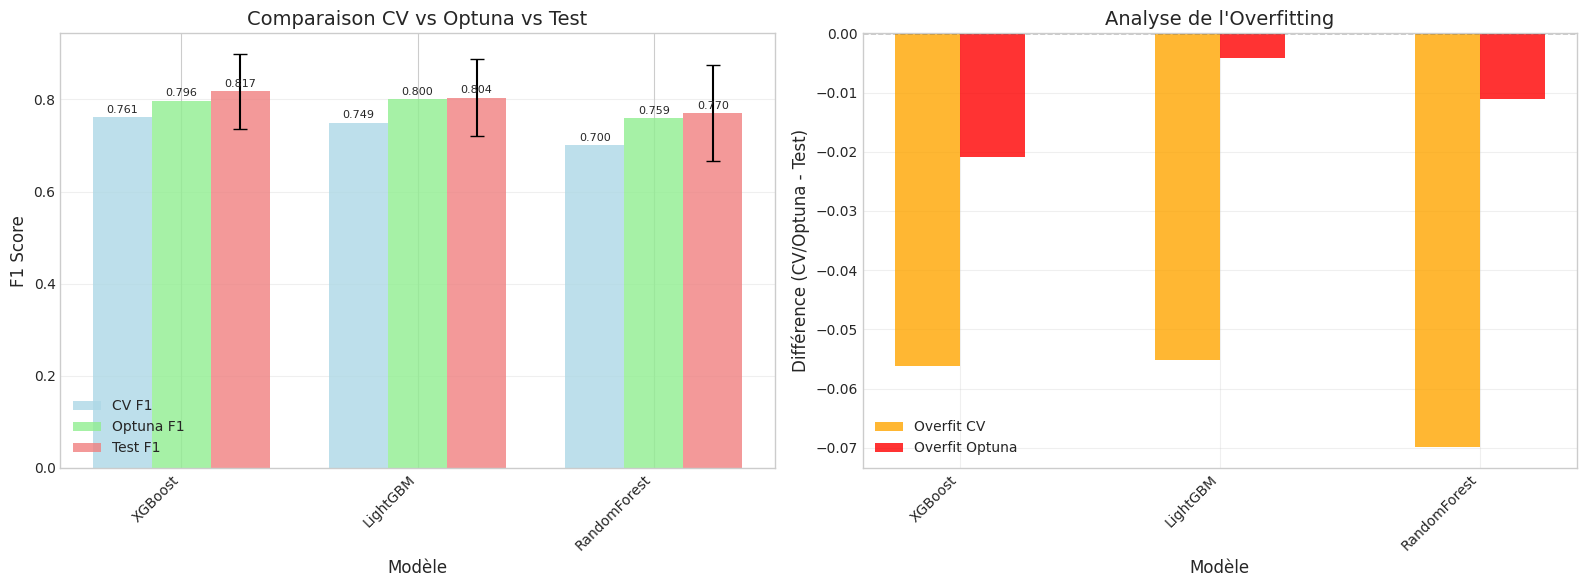


⚖️  Modèle le plus équilibré (meilleur test - pénalité overfitting): XGBoost
   - Test F1: 0.817
   - Overfitting: -0.021


In [0]:
print("\n" + "="*60)
print(" VALIDATION: COMPARAISON CV vs TEST")
print("="*60)

validation_results = []

for model_name, model_data in optimized_models.items():
    print(f"\n Test de {model_name}...")
    
    model_params = model_data['best_params']
    
    if model_name == "LogisticRegression":
        test_model = LogisticRegression(**model_params)
    elif model_name == "RandomForest":
        test_model = RandomForestClassifier(**model_params)
    elif model_name == "XGBoost":
        test_model = XGBClassifier(**model_params)
    elif model_name == "LightGBM":
        test_model = LGBMClassifier(**model_params)
    elif model_name == "SVM":
        test_model = SVC(**model_params)
    elif model_name == "GradientBoosting":
        test_model = GradientBoostingClassifier(**model_params)
    elif model_name == "ExtraTrees":
        test_model = ExtraTreesClassifier(**model_params)
    
    scaler = model_data['scaler_obj']
    X_train_scaled = scaler.fit_transform(X_train_full)
    
    if model_data['feature_method'] == "all":
        X_train_final = X_train_scaled
    else:
        indices = model_data['selected_indices']
        X_train_final = X_train_scaled[:, indices]
    
    test_model.fit(X_train_final, y_train)
    
    test_scores = []
    for test_pct in [30, 50, 70]:  # 3 pourcentages représentatifs
        df_test = datasets_test[test_pct]
        X_test_full, y_test, _ = prepare_features(df_test)
        X_test_scaled = scaler.transform(X_test_full)
        
        if model_data['feature_method'] == "all":
            X_test_final = X_test_scaled
        else:
            X_test_final = X_test_scaled[:, indices]
        
        y_pred = test_model.predict(X_test_final)
        f1_test = f1_score(y_test, y_pred)
        test_scores.append(f1_test)
    
    avg_test_f1 = np.mean(test_scores)
    std_test_f1 = np.std(test_scores)
    cv_f1 = model_data['cv_f1_before']
    optuna_f1 = model_data['best_value']
    
    validation_results.append({
        'model': model_name,
        'cv_f1': cv_f1,
        'optuna_f1': optuna_f1,
        'test_f1_avg': avg_test_f1,
        'test_f1_std': std_test_f1,
        'overfit_cv': cv_f1 - avg_test_f1,
        'overfit_optuna': optuna_f1 - avg_test_f1
    })

df_validation = pd.DataFrame(validation_results)
print("\n Tableau de validation CV vs Test:")
print(df_validation.round(3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Comparaison des scores
models = df_validation['model'].values
x = np.arange(len(models))
width = 0.25

ax1.bar(x - width, df_validation['cv_f1'], width, label='CV F1', alpha=0.8, color='lightblue')
ax1.bar(x, df_validation['optuna_f1'], width, label='Optuna F1', alpha=0.8, color='lightgreen')
ax1.bar(x + width, df_validation['test_f1_avg'], width, label='Test F1', alpha=0.8, color='lightcoral')

ax1.errorbar(x + width, df_validation['test_f1_avg'], yerr=df_validation['test_f1_std'], 
             fmt='none', color='black', capsize=5)

ax1.set_xlabel('Modèle')
ax1.set_ylabel('F1 Score')
ax1.set_title('Comparaison CV vs Optuna vs Test')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, axis='y', alpha=0.3)

for i, row in df_validation.iterrows():
    ax1.text(i - width, row['cv_f1'] + 0.01, f"{row['cv_f1']:.3f}", ha='center', fontsize=8)
    ax1.text(i, row['optuna_f1'] + 0.01, f"{row['optuna_f1']:.3f}", ha='center', fontsize=8)
    ax1.text(i + width, row['test_f1_avg'] + 0.01, f"{row['test_f1_avg']:.3f}", ha='center', fontsize=8)

# Plot 2: Analyse de l'overfitting
ax2.bar(x - width/2, df_validation['overfit_cv'], width, label='Overfit CV', alpha=0.8, color='orange')
ax2.bar(x + width/2, df_validation['overfit_optuna'], width, label='Overfit Optuna', alpha=0.8, color='red')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Modèle')
ax2.set_ylabel('Différence (CV/Optuna - Test)')
ax2.set_title('Analyse de l\'Overfitting')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'cv_vs_test_validation.png'), dpi=300)
plt.show()

df_validation['balance_score'] = df_validation['test_f1_avg'] - 0.1 * abs(df_validation['overfit_optuna'])
best_balanced_idx = df_validation['balance_score'].idxmax()
best_balanced_model = df_validation.iloc[best_balanced_idx]['model']

print(f"\n  Modèle le plus équilibré (meilleur test - pénalité overfitting): {best_balanced_model}")
print(f"   - Test F1: {df_validation.iloc[best_balanced_idx]['test_f1_avg']:.3f}")
print(f"   - Overfitting: {df_validation.iloc[best_balanced_idx]['overfit_optuna']:.3f}")

12. Entrainement du meilleur modèle optimisé (toujours avec sa configuration optimale)

In [0]:
print("\n" + "="*60)
print(" PHASE 5: ENTRAÎNEMENT DU MODÈLE FINAL OPTIMISÉ")
print("="*60)

best_model_data = optimized_models[best_optimized_model]
best_scaler = best_model_data['scaler_obj']
best_feature_method = best_model_data['feature_method']
selected_indices = best_model_data['selected_indices']
selected_features = best_model_data['selected_features']

X_train_scaled = best_scaler.fit_transform(X_train_full)

if best_feature_method == "all":
    X_train_selected = X_train_scaled
else:
    X_train_selected = X_train_scaled[:, selected_indices]

print(f" Configuration utilisée:")
print(f" - Modèle: {best_optimized_model}")
print(f" - Scaler: {best_model_data['scaler']}")
print(f" - Feature method: {best_feature_method}")
print(f" - Nombre de features: {X_train_selected.shape[1]}")

model_params = best_model_data['study'].best_params

if best_optimized_model == "LogisticRegression":
    final_model = LogisticRegression(**model_params)
elif best_optimized_model == "RandomForest":
    final_model = RandomForestClassifier(**model_params)
elif best_optimized_model == "XGBoost":
    final_model = XGBClassifier(**model_params)
elif best_optimized_model == "LightGBM":
    final_model = LGBMClassifier(**model_params)
elif best_optimized_model == "SVM":
    final_model = SVC(**model_params)
elif best_optimized_model == "GradientBoosting":
    final_model = GradientBoostingClassifier(**model_params)
elif best_optimized_model == "ExtraTrees":
    final_model = ExtraTreesClassifier(**model_params)

print(" Entraînement du modèle final...")
final_model.fit(X_train_selected, y_train)
print(f" Modèle entraîné avec {final_model.n_features_in_} features")

best_pct_idx = df_temporal['f1'].idxmax()
best_pct = df_temporal.loc[best_pct_idx, 'percentage']
print(f"\n Test sur le meilleur pourcentage: {best_pct}%")

df_test_best = datasets_test[best_pct]
X_test_best_full, y_test_best, _ = prepare_features(df_test_best)
X_test_best_scaled = best_scaler.transform(X_test_best_full)

if best_feature_method == "all":
    X_test_best_selected = X_test_best_scaled
else:
    X_test_best_selected = X_test_best_scaled[:, selected_indices]

print(f" - Shape des données de test: {X_test_best_selected.shape}")

if X_test_best_selected.shape[1] != X_train_selected.shape[1]:
    print(f"\n  ALERTE: Incohérence détectée!")
    print(f"   Train: {X_train_selected.shape[1]} features")
    print(f"   Test: {X_test_best_selected.shape[1]} features")
    raise ValueError("Le nombre de features ne correspond pas entre train et test!")

y_pred_final = final_model.predict(X_test_best_selected)
y_prob_final = final_model.predict_proba(X_test_best_selected)[:, 1] if hasattr(final_model, "predict_proba") else None

final_metrics = calculate_metrics(y_test_best, y_pred_final, y_prob_final)

print("\n MÉTRIQUES DU MODÈLE OPTIMISÉ:")
for metric, value in final_metrics.items():
    if metric not in ['tn', 'fp', 'fn', 'tp']:
        print(f" - {metric.upper()}: {value:.4f}")

print(f"\n Matrice de Confusion:")
print(f"   TN: {final_metrics['tn']:5d}  FP: {final_metrics['fp']:5d}")
print(f"   FN: {final_metrics['fn']:5d}  TP: {final_metrics['tp']:5d}")

best_model_name = best_optimized_model


 PHASE 5: ENTRAÎNEMENT DU MODÈLE FINAL OPTIMISÉ
 Configuration utilisée:
 - Modèle: LightGBM
 - Scaler: Standard
 - Feature method: xgb_importance
 - Nombre de features: 24
 Entraînement du modèle final...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ✓ Modèle entraîné avec 24 features

 Test sur le meilleur pourcentage: 90%
 - Shape des données de test: (1109, 24)

 MÉTRIQUES DU MODÈLE OPTIMISÉ:
 - ACCURACY: 0.9143
 - PRECISION: 0.9356
 - RECALL: 0.8522
 - F1: 0.8919
 - AUC: 0.9494

 Matrice de Confusion:
   TN:   622  FP:    27
   FN:    68  TP:   392


13. Mise à jour de l'ensemble des paramètres après optimisation

In [0]:
print("\n Variables globales mises à jour pour cohérence...")

best_model_data = optimized_models[best_optimized_model]

best_scaler_obj = best_model_data['scaler_obj']  
best_scaler_name = best_model_data['scaler']     
best_feature_method = best_model_data['feature_method']
selected_indices = best_model_data['selected_indices']
selected_features = best_model_data['selected_features']
study = best_model_data['study']

best_scaler = best_scaler_obj  

best_combo = {
    'scaler': best_scaler_name,
    'scaler_obj': best_scaler_obj,
    'feature_method': best_feature_method,
    'selected_indices': selected_indices,
    'selected_features': selected_features,
    'model': best_optimized_model,
    'cv_f1_mean': best_model_data['cv_f1_before'],
    'best_value': best_model_data['best_value'],
    'improvement': best_model_data['improvement'],
    'study': study,
    'n_features': len(selected_features) if selected_features else len(feature_names_full)
}

best_final_model = final_model
best_final_name = best_optimized_model + " (Optimisé)"
best_final_metrics = final_metrics

print(f"✓ best_scaler est maintenant: {type(best_scaler).__name__}")
print(f"✓ best_scaler_obj est: {type(best_scaler_obj).__name__}")
print(f"✓ best_scaler_name est: {best_scaler_name}")
print(f"✓ Modèle: {best_optimized_model}")
print(f"✓ Features: {len(selected_features) if selected_features else 'all'}")



 Variables globales mises à jour pour cohérence...
✓ best_scaler est maintenant: StandardScaler
✓ best_scaler_obj est: StandardScaler
✓ best_scaler_name est: Standard
✓ Modèle: LightGBM
✓ Features: 24


14. Test pré-défaut avec le modèle optimisé


 PHASE 5.5: TEST PRÉ-DÉFAUT AVEC MODÈLE OPTIMISÉ

 Rechargement du dataset pré-défaut original...
 ✓ Dataset rechargé: (460, 39)
 Colonnes: ['Nref', 'N', 'T_amb', 'T_c_in', 'T_c_out', 'T_rec_c_in', 'T_rec_c_out', 'T_cc_in', 'T_cc_out', 'T_t_in']...

 Shape X_predefaut_full: (460, 36)
 Type de best_scaler: StandardScaler
 ✓ Transformation réussie

 - Shape données pré-défaut après sélection: (460, 24)
 - Nombre de features attendues par le modèle: 24

 Résultats sur données pré-défaut (AVEC TUNING):
 - Nombre d'échantillons: 460
 - Vrais labels: tous = 0 (pas de défaut)
 - Prédictions = 1 (fausses alarmes): 140
 - Taux de fausses alarmes: 30.43%

 Amélioration: 31.30% → 30.43% (réduction de 2.8%)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

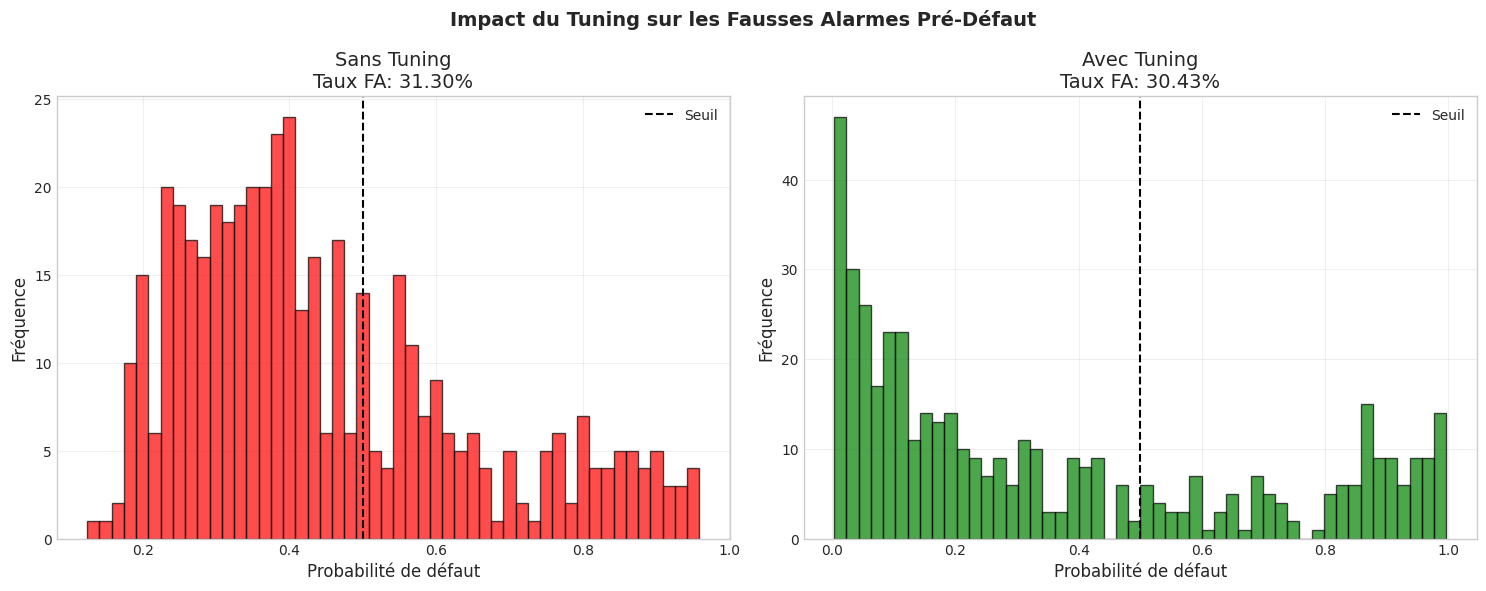

In [0]:
print("\n" + "="*60)
print(" PHASE 5.5: TEST PRÉ-DÉFAUT AVEC MODÈLE OPTIMISÉ")
print("="*60)

print("\n Rechargement du dataset pré-défaut original...")
df_predefaut_original = pd.read_csv(os.path.join(DOSSIER_POURCENTAGES, "dataset_test_predefaut.csv"))
print(f"  Dataset rechargé: {df_predefaut_original.shape}")
print(f" Colonnes: {df_predefaut_original.columns.tolist()[:10]}...")

X_predefaut_full, y_predefaut, _ = prepare_features(df_predefaut_original)
print(f"\n Shape X_predefaut_full: {X_predefaut_full.shape}")
print(f" Type de best_scaler: {type(best_scaler).__name__}")

X_predefaut_scaled = best_scaler.transform(X_predefaut_full)
print(" Transformation réussie")

if best_feature_method == "all":
    X_predefaut_selected = X_predefaut_scaled
else:
    X_predefaut_selected = X_predefaut_scaled[:, selected_indices]

print(f"\n - Shape données pré-défaut après sélection: {X_predefaut_selected.shape}")
print(f" - Nombre de features attendues par le modèle: {final_model.n_features_in_}")

if X_predefaut_selected.shape[1] != final_model.n_features_in_:
    print(f"\n  ALERTE: Incohérence sur les features pré-défaut!")
    print(f"   Données: {X_predefaut_selected.shape[1]} features")
    print(f"   Modèle: {final_model.n_features_in_} features")
    raise ValueError("Le nombre de features ne correspond pas!")

y_pred_predefaut_opt = final_model.predict(X_predefaut_selected)
y_prob_predefaut_opt = final_model.predict_proba(X_predefaut_selected)[:, 1] if hasattr(final_model, "predict_proba") else None

false_alarm_rate_opt = (y_pred_predefaut_opt == 1).mean()

# Récupérer le taux de FA sans tuning depuis df_predefaut (qui contient les résultats)
# Note: df_predefaut contient maintenant les résultats de la phase 3.5, pas les données originales
false_alarm_rate = df_predefaut[df_predefaut['model'] == best_optimized_model]['false_alarm_rate'].values[0]

print(f"\n Résultats sur données pré-défaut (AVEC TUNING):")
print(f" - Nombre d'échantillons: {len(y_predefaut)}")
print(f" - Vrais labels: tous = 0 (pas de défaut)")
print(f" - Prédictions = 1 (fausses alarmes): {(y_pred_predefaut_opt == 1).sum()}")
print(f" - Taux de fausses alarmes: {false_alarm_rate_opt:.2%}")
print(f"\n Amélioration: {false_alarm_rate:.2%} → {false_alarm_rate_opt:.2%} "
      f"(réduction de {(false_alarm_rate - false_alarm_rate_opt)/false_alarm_rate*100:.1f}%)")

# Pour la comparaison visuelle, on doit recalculer les probabilités sans tuning
# Créer un modèle non optimisé pour comparaison
if best_optimized_model in MODELS:
    model_no_tuning = MODELS[best_optimized_model].__class__(**MODELS[best_optimized_model].get_params())
    model_no_tuning.fit(X_train_selected, y_train)
    y_prob_predefaut = model_no_tuning.predict_proba(X_predefaut_selected)[:, 1] if hasattr(model_no_tuning, "predict_proba") else None
else:
    y_prob_predefaut = None

# Comparaison des distributions
if y_prob_predefaut is not None and y_prob_predefaut_opt is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sans tuning
    ax1.hist(y_prob_predefaut, bins=50, alpha=0.7, color='red', edgecolor='black')
    ax1.axvline(x=0.5, color='black', linestyle='--', label='Seuil')
    ax1.set_xlabel('Probabilité de défaut')
    ax1.set_ylabel('Fréquence')
    ax1.set_title(f'Sans Tuning\nTaux FA: {false_alarm_rate:.2%}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Avec tuning
    ax2.hist(y_prob_predefaut_opt, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.axvline(x=0.5, color='black', linestyle='--', label='Seuil')
    ax2.set_xlabel('Probabilité de défaut')
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Avec Tuning\nTaux FA: {false_alarm_rate_opt:.2%}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Impact du Tuning sur les Fausses Alarmes Pré-Défaut', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(EXPORT_DIR, 'predefaut_comparison.png'), dpi=300)
    plt.show()


 COMPARAISON: IMPACT DE L'OPTIMISATION SUR LES FA


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

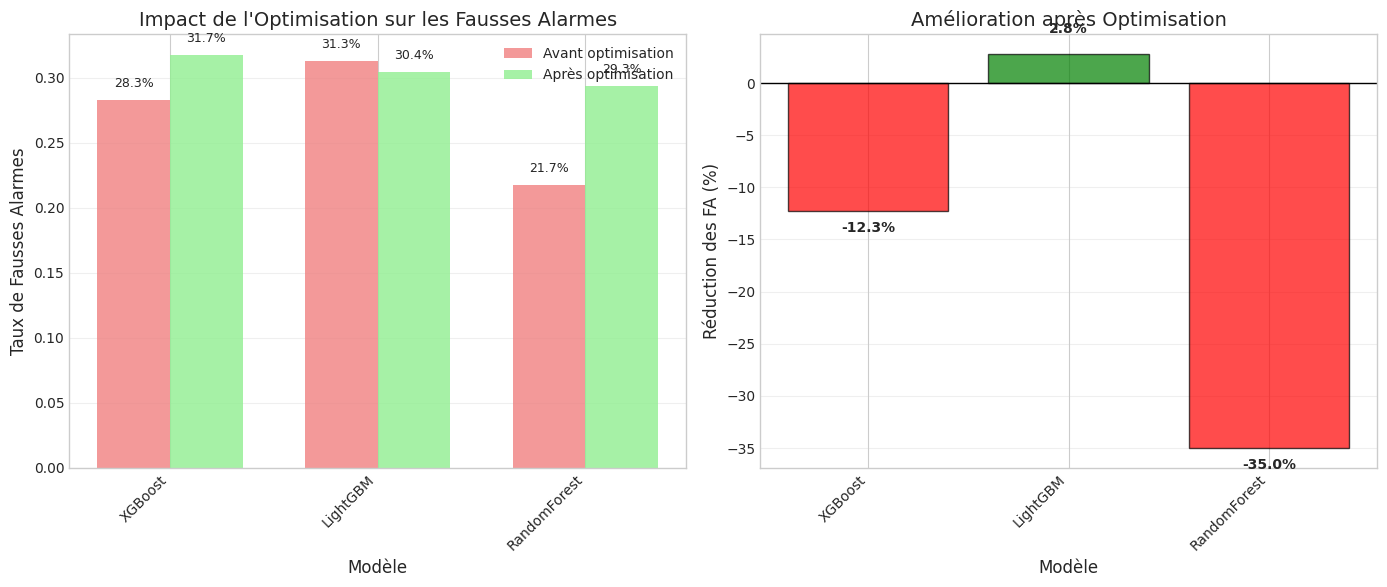


 Impact de l'optimisation sur les fausses alarmes:
       model  fa_before  fa_after  reduction  prob_mean_after
     XGBoost   0.282609  0.317391 -12.307692         0.373254
    LightGBM   0.313043  0.304348   2.777778         0.355679
RandomForest   0.217391  0.293478 -35.000000         0.384763

 Meilleure amélioration: LightGBM
   - Réduction: 2.8%
   - FA: 31.30% → 30.43%


In [0]:
print("\n" + "="*60)
print(" COMPARAISON: IMPACT DE L'OPTIMISATION SUR LES FA")
print("="*60)

fa_comparison_optimized = [] # Comparer les 3 modèles optimisés sur les fausses alarmes

for model_name, model_data in optimized_models.items():
    model_params = model_data['best_params']
    
    if model_name == "LogisticRegression":
        opt_model = LogisticRegression(**model_params)
    elif model_name == "RandomForest":
        opt_model = RandomForestClassifier(**model_params)
    elif model_name == "XGBoost":
        opt_model = XGBClassifier(**model_params)
    elif model_name == "LightGBM":
        opt_model = LGBMClassifier(**model_params)
    elif model_name == "SVM":
        opt_model = SVC(**model_params)
    elif model_name == "GradientBoosting":
        opt_model = GradientBoostingClassifier(**model_params)
    elif model_name == "ExtraTrees":
        opt_model = ExtraTreesClassifier(**model_params)
    
    scaler = model_data['scaler_obj']
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_predefaut_scaled = scaler.transform(X_predefaut_full)
    
    if model_data['feature_method'] == "all":
        X_train_final = X_train_scaled
        X_predefaut_final = X_predefaut_scaled
    else:
        indices = model_data['selected_indices']
        X_train_final = X_train_scaled[:, indices]
        X_predefaut_final = X_predefaut_scaled[:, indices]
    
    opt_model.fit(X_train_final, y_train)
    y_pred_opt = opt_model.predict(X_predefaut_final)
    y_prob_opt = opt_model.predict_proba(X_predefaut_final)[:, 1] if hasattr(opt_model, "predict_proba") else None
    
    # Récupérer les FA avant optimisation
    fa_before = df_predefaut[df_predefaut['model'] == model_name]['false_alarm_rate'].values[0]
    fa_after = (y_pred_opt == 1).mean()
    
    fa_comparison_optimized.append({
        'model': model_name,
        'fa_before': fa_before,
        'fa_after': fa_after,
        'reduction': (fa_before - fa_after) / fa_before * 100 if fa_before > 0 else 0,
        'prob_mean_after': y_prob_opt.mean() if y_prob_opt is not None else None
    })

df_fa_comparison = pd.DataFrame(fa_comparison_optimized)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Avant vs Après
models = df_fa_comparison['model'].values
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, df_fa_comparison['fa_before'], width, 
        label='Avant optimisation', alpha=0.8, color='lightcoral')
ax1.bar(x + width/2, df_fa_comparison['fa_after'], width, 
        label='Après optimisation', alpha=0.8, color='lightgreen')

ax1.set_xlabel('Modèle')
ax1.set_ylabel('Taux de Fausses Alarmes')
ax1.set_title('Impact de l\'Optimisation sur les Fausses Alarmes')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, axis='y', alpha=0.3)

for i, row in df_fa_comparison.iterrows():
    ax1.text(i - width/2, row['fa_before'] + 0.01, f"{row['fa_before']:.1%}", 
             ha='center', fontsize=9)
    ax1.text(i + width/2, row['fa_after'] + 0.01, f"{row['fa_after']:.1%}", 
             ha='center', fontsize=9)

# Plot 2: Réduction en pourcentage
colors = ['green' if r > 0 else 'red' for r in df_fa_comparison['reduction']]
ax2.bar(x, df_fa_comparison['reduction'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Modèle')
ax2.set_ylabel('Réduction des FA (%)')
ax2.set_title('Amélioration après Optimisation')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.grid(True, axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)

for i, reduction in enumerate(df_fa_comparison['reduction']):
    y_pos = reduction + 2 if reduction > 0 else reduction - 2
    ax2.text(i, y_pos, f"{reduction:.1f}%", ha='center', fontsize=10, 
             fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'fa_optimization_impact.png'), dpi=300)
plt.show()

print("\n Impact de l'optimisation sur les fausses alarmes:")
print(df_fa_comparison.to_string(index=False))

best_improvement = df_fa_comparison.loc[df_fa_comparison['reduction'].idxmax()]
print(f"\n Meilleure amélioration: {best_improvement['model']}")
print(f"   - Réduction: {best_improvement['reduction']:.1f}%")
print(f"   - FA: {best_improvement['fa_before']:.2%} → {best_improvement['fa_after']:.2%}")

15. Analyse temporelle finale


 PHASE 7: ANALYSE TEMPORELLE COMPLÈTE


Analyse temporelle: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


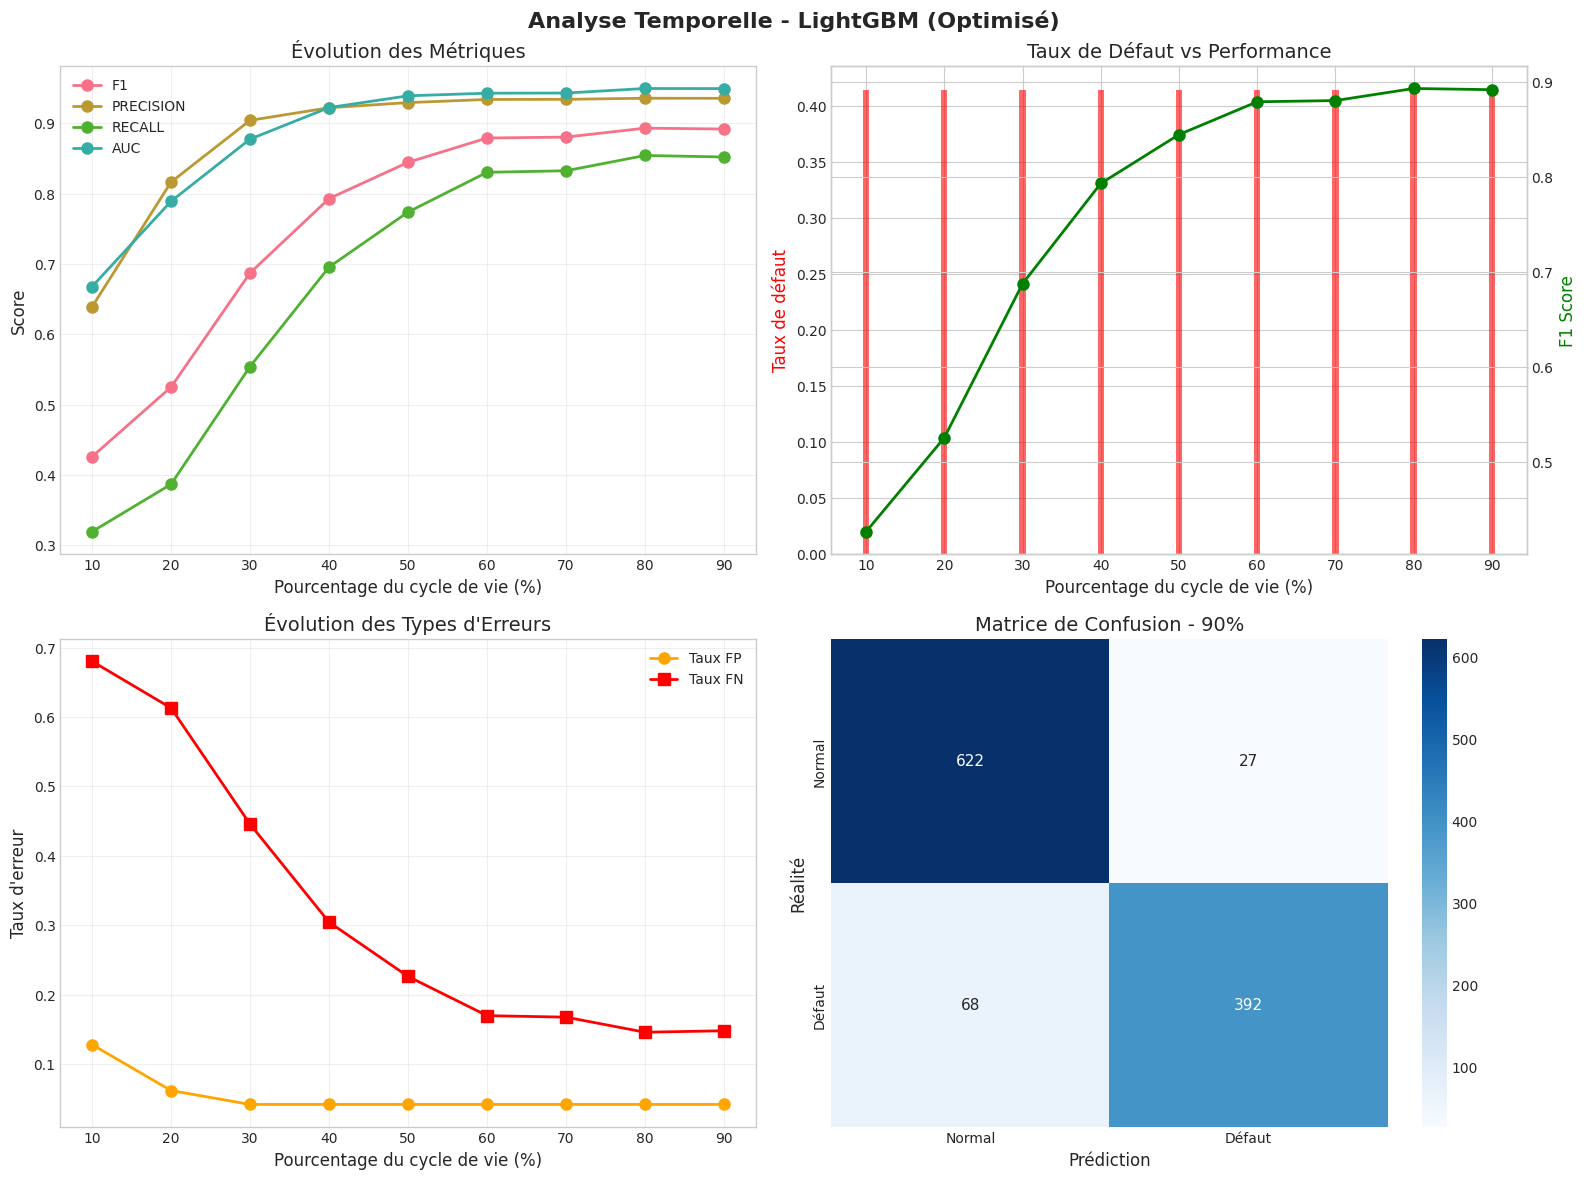

In [0]:
print("\n" + "="*60)
print(" PHASE 7: ANALYSE TEMPORELLE COMPLÈTE")
print("="*60)

temporal_results_final = []

for pct in tqdm(PERCENTAGES_TO_TEST, desc="Analyse temporelle"):
    df_test = datasets_test[pct]
    
    X_test_full, y_test, _ = prepare_features(df_test)
    X_test_scaled = best_scaler.transform(X_test_full)
    
    if best_feature_method == "all":
        X_test_selected = X_test_scaled
    else:
        X_test_selected = X_test_scaled[:, selected_indices]
    
    y_pred = best_final_model.predict(X_test_selected)
    y_prob = best_final_model.predict_proba(X_test_selected)[:, 1] if hasattr(best_final_model, "predict_proba") else None
    
    metrics = calculate_metrics(y_test, y_pred, y_prob)
    metrics['percentage'] = pct
    metrics['n_test'] = len(y_test)
    metrics['defaut_rate'] = y_test.mean()
    
    temporal_results_final.append(metrics)

df_temporal_final = pd.DataFrame(temporal_results_final)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Analyse Temporelle - {best_final_name}', fontsize=16, fontweight='bold')

# 1. Évolution des métriques
ax1 = axes[0, 0]
metrics_plot = ['f1', 'precision', 'recall', 'auc']
for metric in metrics_plot:
    ax1.plot(df_temporal_final['percentage'], df_temporal_final[metric], 
             'o-', label=metric.upper(), linewidth=2, markersize=8)
ax1.set_xlabel('Pourcentage du cycle de vie (%)')
ax1.set_ylabel('Score')
ax1.set_title('Évolution des Métriques')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Taux de défaut et F1
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()
ax2.bar(df_temporal_final['percentage'], df_temporal_final['defaut_rate'], 
        alpha=0.6, color='red', label='Taux de défaut')
ax2_twin.plot(df_temporal_final['percentage'], df_temporal_final['f1'], 
              'go-', linewidth=2, markersize=8, label='F1 Score')
ax2.set_xlabel('Pourcentage du cycle de vie (%)')
ax2.set_ylabel('Taux de défaut', color='red')
ax2_twin.set_ylabel('F1 Score', color='green')
ax2.set_title('Taux de Défaut vs Performance')

# 3. Analyse des erreurs
ax3 = axes[1, 0]
fp_rate = df_temporal_final['fp'] / (df_temporal_final['fp'] + df_temporal_final['tn'])
fn_rate = df_temporal_final['fn'] / (df_temporal_final['fn'] + df_temporal_final['tp'])
ax3.plot(df_temporal_final['percentage'], fp_rate, 'o-', color='orange', 
         label='Taux FP', linewidth=2, markersize=8)
ax3.plot(df_temporal_final['percentage'], fn_rate, 's-', color='red', 
         label='Taux FN', linewidth=2, markersize=8)
ax3.set_xlabel('Pourcentage du cycle de vie (%)')
ax3.set_ylabel('Taux d\'erreur')
ax3.set_title('Évolution des Types d\'Erreurs')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Matrice de confusion pour le meilleur pourcentage (90%)
ax4 = axes[1, 1]
cm = confusion_matrix(y_test_best, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Défaut'],
            yticklabels=['Normal', 'Défaut'], ax=ax4)
ax4.set_xlabel('Prédiction')
ax4.set_ylabel('Réalité')
ax4.set_title(f'Matrice de Confusion - {best_pct}%')

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'temporal_analysis_final.png'), dpi=300)
plt.show()

16. Analyse de l'évolution temporelle de l'importance des variables


 PHASE 8: EXPLICABILITÉ - IMPORTANCE DES FEATURES
 Calcul de l'importance des features par pourcentage...


Calcul importance:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  11%|█         | 1/9 [00:11<01:35, 11.89s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  22%|██▏       | 2/9 [00:22<01:19, 11.41s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  33%|███▎      | 3/9 [00:33<01:06, 11.16s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  44%|████▍     | 4/9 [00:44<00:54, 10.98s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  56%|█████▌    | 5/9 [00:56<00:45, 11.34s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  67%|██████▋   | 6/9 [01:07<00:33, 11.25s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  78%|███████▊  | 7/9 [01:18<00:22, 11.15s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance:  89%|████████▉ | 8/9 [01:29<00:11, 11.11s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Calcul importance: 100%|██████████| 9/9 [01:40<00:00, 11.19s/it]


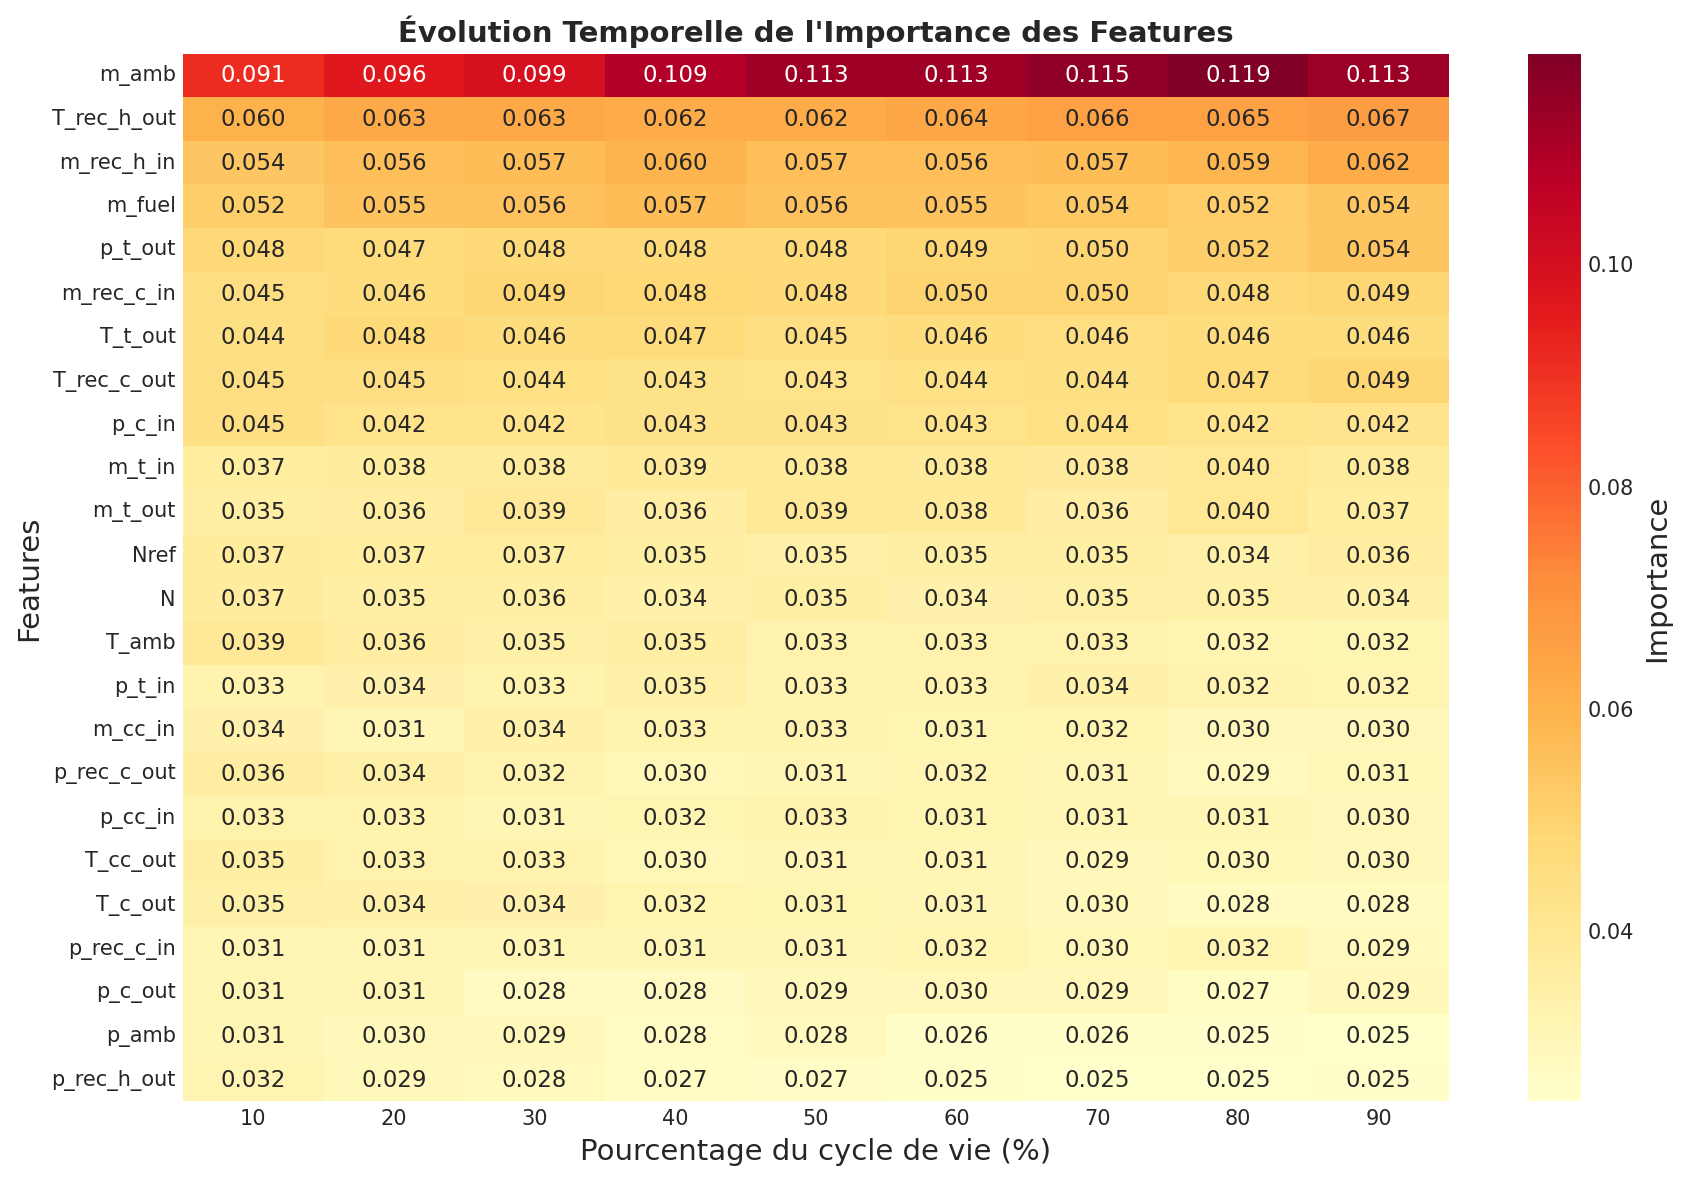


 Top 10 features les plus fréquemment importantes:
 1. m_cc_in: présente dans 9/9 pourcentages
 2. p_rec_h_out: présente dans 9/9 pourcentages
 3. N: présente dans 9/9 pourcentages
 4. T_c_out: présente dans 9/9 pourcentages
 5. T_cc_out: présente dans 9/9 pourcentages
 6. m_rec_c_in: présente dans 9/9 pourcentages
 7. p_c_out: présente dans 9/9 pourcentages
 8. T_rec_c_out: présente dans 9/9 pourcentages
 9. p_amb: présente dans 9/9 pourcentages
 10. Nref: présente dans 9/9 pourcentages


In [0]:
print("\n" + "="*60)
print(" PHASE 8: EXPLICABILITÉ - IMPORTANCE DES FEATURES")
print("="*60)

feature_importance_temporal = defaultdict(dict)

print(" Calcul de l'importance des features par pourcentage...")
for pct in tqdm([10,20, 30,40, 50, 60, 70,80, 90], desc="Calcul importance"):
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=N_JOBS) # Entraîner un RandomForest pour l'importance
    
    df_test = datasets_test[pct]
    X_test_full, y_test, _ = prepare_features(df_test)
    X_test_scaled = best_scaler.transform(X_test_full)
    
    if best_feature_method == "all":
        X_test_selected = X_test_scaled
        selected_feature_names = feature_names_full
    else:
        X_test_selected = X_test_scaled[:, selected_indices]
        selected_feature_names = [feature_names_full[i] for i in selected_indices]
    
    X_combined = np.vstack([X_train_selected, X_test_selected])
    y_combined = np.hstack([y_train, y_test])
    
    rf_temp.fit(X_combined, y_combined)
    
    for feat, imp in zip(selected_feature_names, rf_temp.feature_importances_):
        feature_importance_temporal[feat][pct] = imp

df_feat_importance = pd.DataFrame(feature_importance_temporal).T.fillna(0)

mean_importance = df_feat_importance.mean(axis=1).sort_values(ascending=False)
top_20_features = mean_importance.head(30).index

plt.figure(figsize=(12, 8))
sns.heatmap(df_feat_importance.loc[top_20_features], 
            cmap='YlOrRd', annot=True, fmt='.3f',
            cbar_kws={'label': 'Importance'})
plt.title('Évolution Temporelle de l\'Importance des Features', fontsize=14, fontweight='bold')
plt.xlabel('Pourcentage du cycle de vie (%)')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'feature_importance_temporal_heatmap.png'), dpi=300)
plt.show()

feature_frequency = (df_feat_importance > 0.01).sum(axis=1).sort_values(ascending=False) # Features qui apparaissent souvent
print("\n Top 10 features les plus fréquemment importantes:")
for i, (feat, freq) in enumerate(feature_frequency.head(10).items(), 1):
    print(f" {i}. {feat}: présente dans {freq}/{len(df_feat_importance.columns)} pourcentages")

17. Analyse SHAP du meilleur modèle sur le pourcentage où le F1_score est le plus élevé


 PHASE 8.5: ANALYSE SHAP - EXPLICABILITÉ AVANCÉE

 Erreurs détectées pour l'analyse SHAP:
 - Faux Positifs: 27
 - Faux Négatifs: 68

 Calcul des valeurs SHAP...


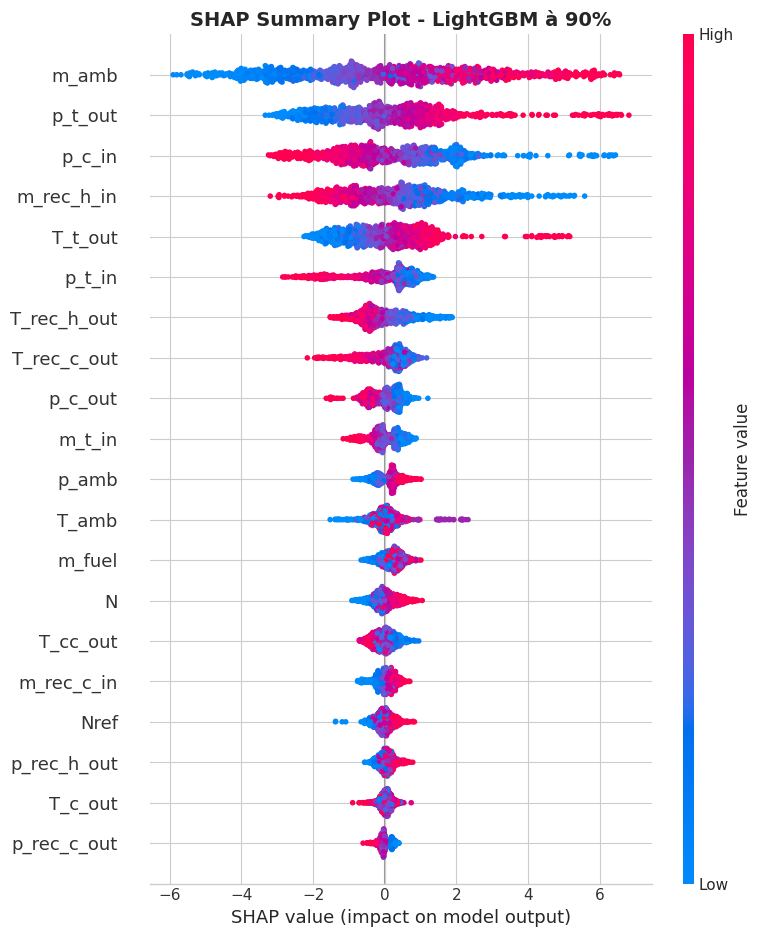


 Analyse SHAP des erreurs de classification...


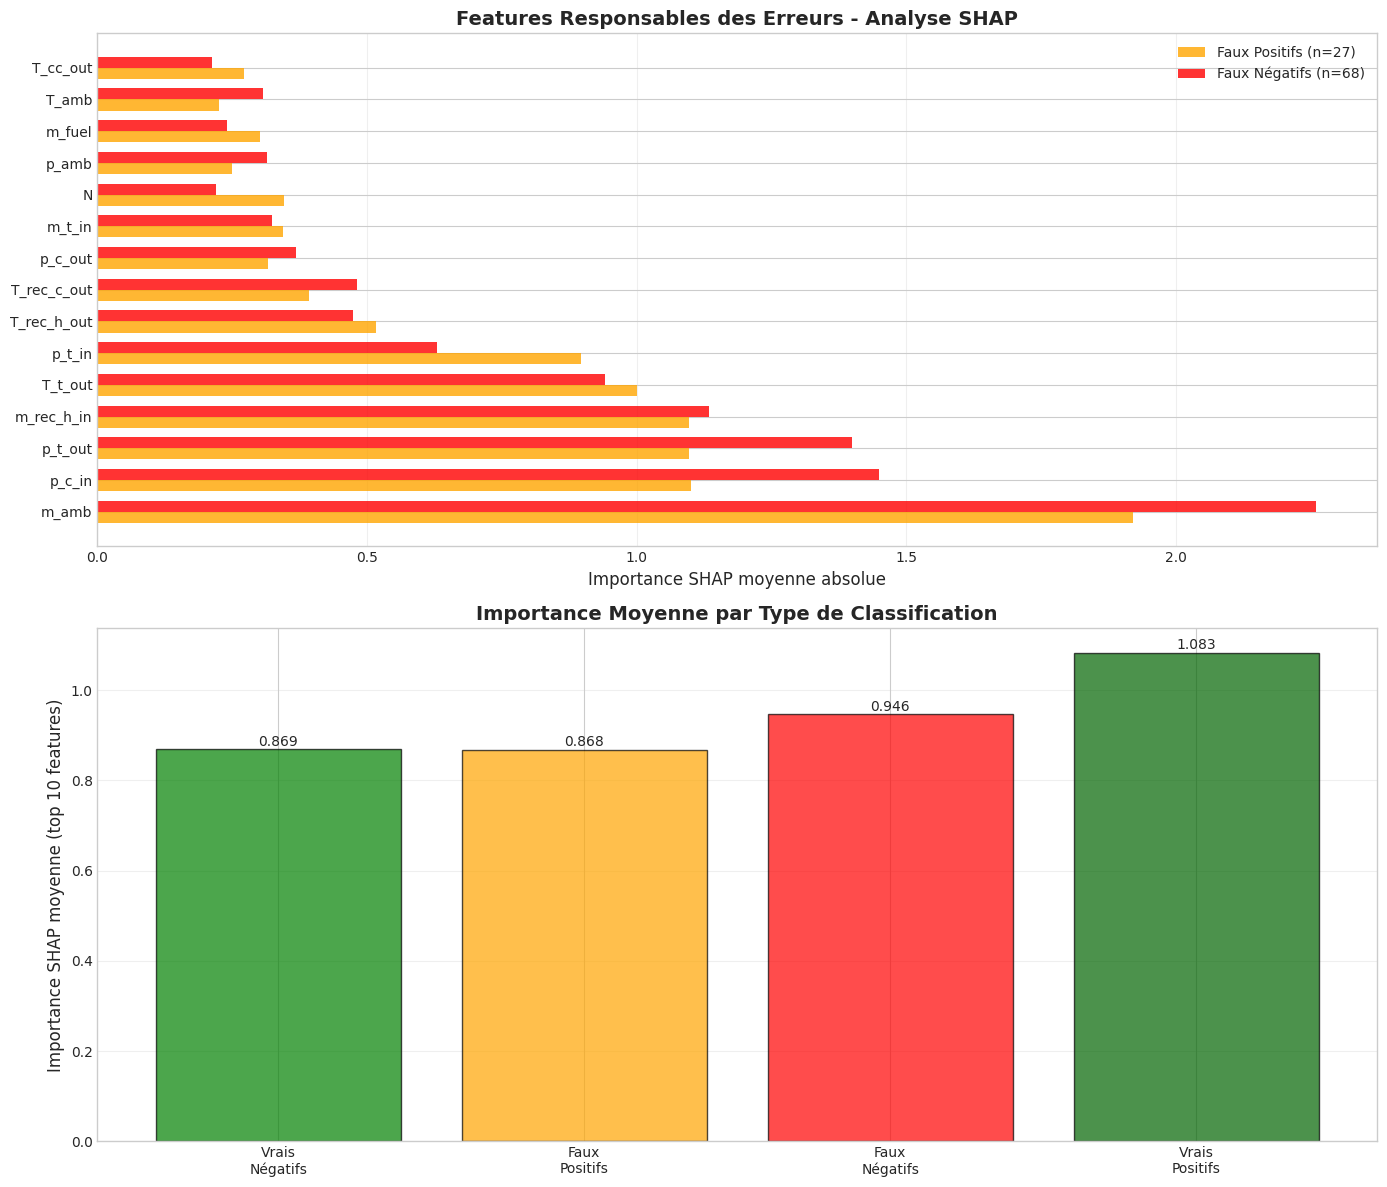

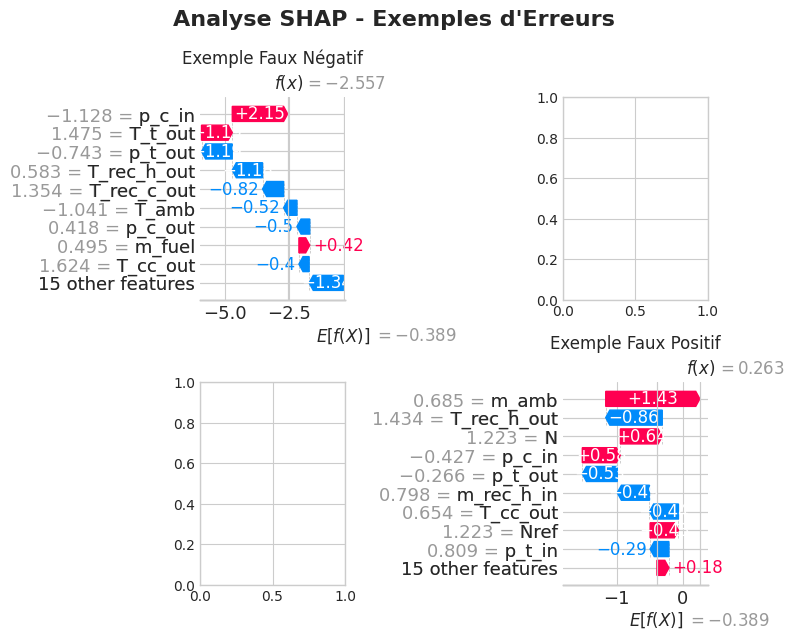


 Patterns identifiés dans les erreurs:

 Features principales causant des FAUX POSITIFS:
 1. m_amb: importance SHAP = 1.922
 2. p_c_in: importance SHAP = 1.102
 3. p_t_out: importance SHAP = 1.098
 4. m_rec_h_in: importance SHAP = 1.097
 5. T_t_out: importance SHAP = 1.001

 Features principales causant des FAUX NÉGATIFS:
 1. m_amb: importance SHAP = 2.260
 2. p_c_in: importance SHAP = 1.450
 3. p_t_out: importance SHAP = 1.399
 4. m_rec_h_in: importance SHAP = 1.135
 5. T_t_out: importance SHAP = 0.942


In [0]:
print("\n" + "="*60)
print(" PHASE 8.5: ANALYSE SHAP - EXPLICABILITÉ AVANCÉE")
print("="*60)

fp_mask = (y_test_best == 0) & (y_pred_final == 1)  # Faux Positifs
fn_mask = (y_test_best == 1) & (y_pred_final == 0)  # Faux Négatifs

print(f"\n Erreurs détectées pour l'analyse SHAP:")
print(f" - Faux Positifs: {fp_mask.sum()}")
print(f" - Faux Négatifs: {fn_mask.sum()}")

if best_model_name not in ['SVM', 'VotingClassifier']:  # SHAP marche mal avec SVM
    print("\n Calcul des valeurs SHAP...")
    
    if best_model_name in ['XGBoost', 'LightGBM', 'GradientBoosting']:
        explainer = shap.TreeExplainer(final_model) # Créer l'explainer
    else:
        sample_size = min(100, len(X_train_selected)) # Pour les autres modèles, utiliser un échantillon
        X_sample = shap.sample(X_train_selected, sample_size)
        explainer = shap.KernelExplainer(final_model.predict_proba, X_sample)
    
    shap_values = explainer.shap_values(X_test_best_selected)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # 1. Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_best_selected, 
                     feature_names=selected_feature_names,
                     show=False, max_display=20)
    plt.title(f'SHAP Summary Plot - {best_model_name} à {best_pct}%', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(EXPORT_DIR, 'shap_summary_plot.png'), dpi=300)
    plt.show()
    
    # 2. Analyse spécifique des erreurs
    print("\n Analyse SHAP des erreurs de classification...")
    
    shap_fp = shap_values[fp_mask]
    shap_fn = shap_values[fn_mask]
    shap_tp = shap_values[(y_test_best == 1) & (y_pred_final == 1)]
    shap_tn = shap_values[(y_test_best == 0) & (y_pred_final == 0)]

    if len(shap_fp) > 0 and len(shap_fn) > 0:
        importance_fp = np.abs(shap_fp).mean(axis=0)
        importance_fn = np.abs(shap_fn).mean(axis=0)
        importance_tp = np.abs(shap_tp).mean(axis=0) if len(shap_tp) > 0 else np.zeros_like(importance_fp)
        importance_tn = np.abs(shap_tn).mean(axis=0) if len(shap_tn) > 0 else np.zeros_like(importance_fp)
        
        top_features_idx = np.argsort(importance_fp + importance_fn)[-15:][::-1]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # Plot 1: Comparaison FP vs FN
        x = np.arange(len(top_features_idx))
        width = 0.35
        
        feature_names_top = [selected_feature_names[i] for i in top_features_idx]
        
        bars1 = ax1.barh(x - width/2, importance_fp[top_features_idx], width, 
                         label=f'Faux Positifs (n={len(shap_fp)})', alpha=0.8, color='orange')
        bars2 = ax1.barh(x + width/2, importance_fn[top_features_idx], width, 
                         label=f'Faux Négatifs (n={len(shap_fn)})', alpha=0.8, color='red')
        
        ax1.set_yticks(x)
        ax1.set_yticklabels(feature_names_top)
        ax1.set_xlabel('Importance SHAP moyenne absolue')
        ax1.set_title('Features Responsables des Erreurs - Analyse SHAP', 
                      fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, axis='x', alpha=0.3)
        
        # Plot 2: Toutes les catégories
        categories = ['Vrais\nNégatifs', 'Faux\nPositifs', 'Faux\nNégatifs', 'Vrais\nPositifs']
        importances = [importance_tn[top_features_idx[:10]].mean(),
                      importance_fp[top_features_idx[:10]].mean(),
                      importance_fn[top_features_idx[:10]].mean(),
                      importance_tp[top_features_idx[:10]].mean() if len(shap_tp) > 0 else 0]
        
        colors = ['green', 'orange', 'red', 'darkgreen']
        bars = ax2.bar(categories, importances, color=colors, alpha=0.7, edgecolor='black')
        ax2.set_ylabel('Importance SHAP moyenne (top 10 features)')
        ax2.set_title('Importance Moyenne par Type de Classification', 
                      fontsize=14, fontweight='bold')
        ax2.grid(True, axis='y', alpha=0.3)
        
        for bar, value in zip(bars, importances):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(EXPORT_DIR, 'shap_error_analysis.png'), dpi=300)
        plt.show()
        
        # 3. Waterfall plot pour un exemple de chaque type d'erreur
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # FP example
        if len(shap_fp) > 0:
            shap.waterfall_plot(shap.Explanation(values=shap_fp[0], 
                                               base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                                               data=X_test_best_selected[fp_mask][0],
                                               feature_names=selected_feature_names),
                               max_display=10, show=False)
            plt.title('Exemple Faux Positif', fontsize=12)
            plt.sca(axes[0, 0])
        
        # FN example  
        if len(shap_fn) > 0:
            shap.waterfall_plot(shap.Explanation(values=shap_fn[0],
                                               base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                                               data=X_test_best_selected[fn_mask][0],
                                               feature_names=selected_feature_names),
                               max_display=10, show=False)
            plt.title('Exemple Faux Négatif', fontsize=12)
            plt.sca(axes[0, 1])
        
        plt.suptitle('Analyse SHAP - Exemples d\'Erreurs', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(EXPORT_DIR, 'shap_waterfall_errors.png'), dpi=300)
        plt.show()
        
        print("\n Patterns identifiés dans les erreurs:")
        print(f"\n Features principales causant des FAUX POSITIFS:")
        for i, idx in enumerate(top_features_idx[:5]):
            feat_name = selected_feature_names[idx]
            print(f" {i+1}. {feat_name}: importance SHAP = {importance_fp[idx]:.3f}")
            
        print(f"\n Features principales causant des FAUX NÉGATIFS:")
        for i, idx in enumerate(np.argsort(importance_fn)[-5:][::-1]):
            feat_name = selected_feature_names[idx]
            print(f" {i+1}. {feat_name}: importance SHAP = {importance_fn[idx]:.3f}")

18. Analyse de sensibilité sur le seuil de décision


 PHASE 11: OPTIMISATION DU SEUIL DE DÉCISION
         BASÉE SUR LE F1-SCORE

📊 Collecte des données de tous les pourcentages...
✓ Total d'échantillons collectés: 9981

🎯 SEUILS OPTIMAUX TROUVÉS:
 - Pour maximiser F1-Score: 0.281
 - Pour maximiser Precision: 0.868
 - Pour maximiser Recall: 0.038


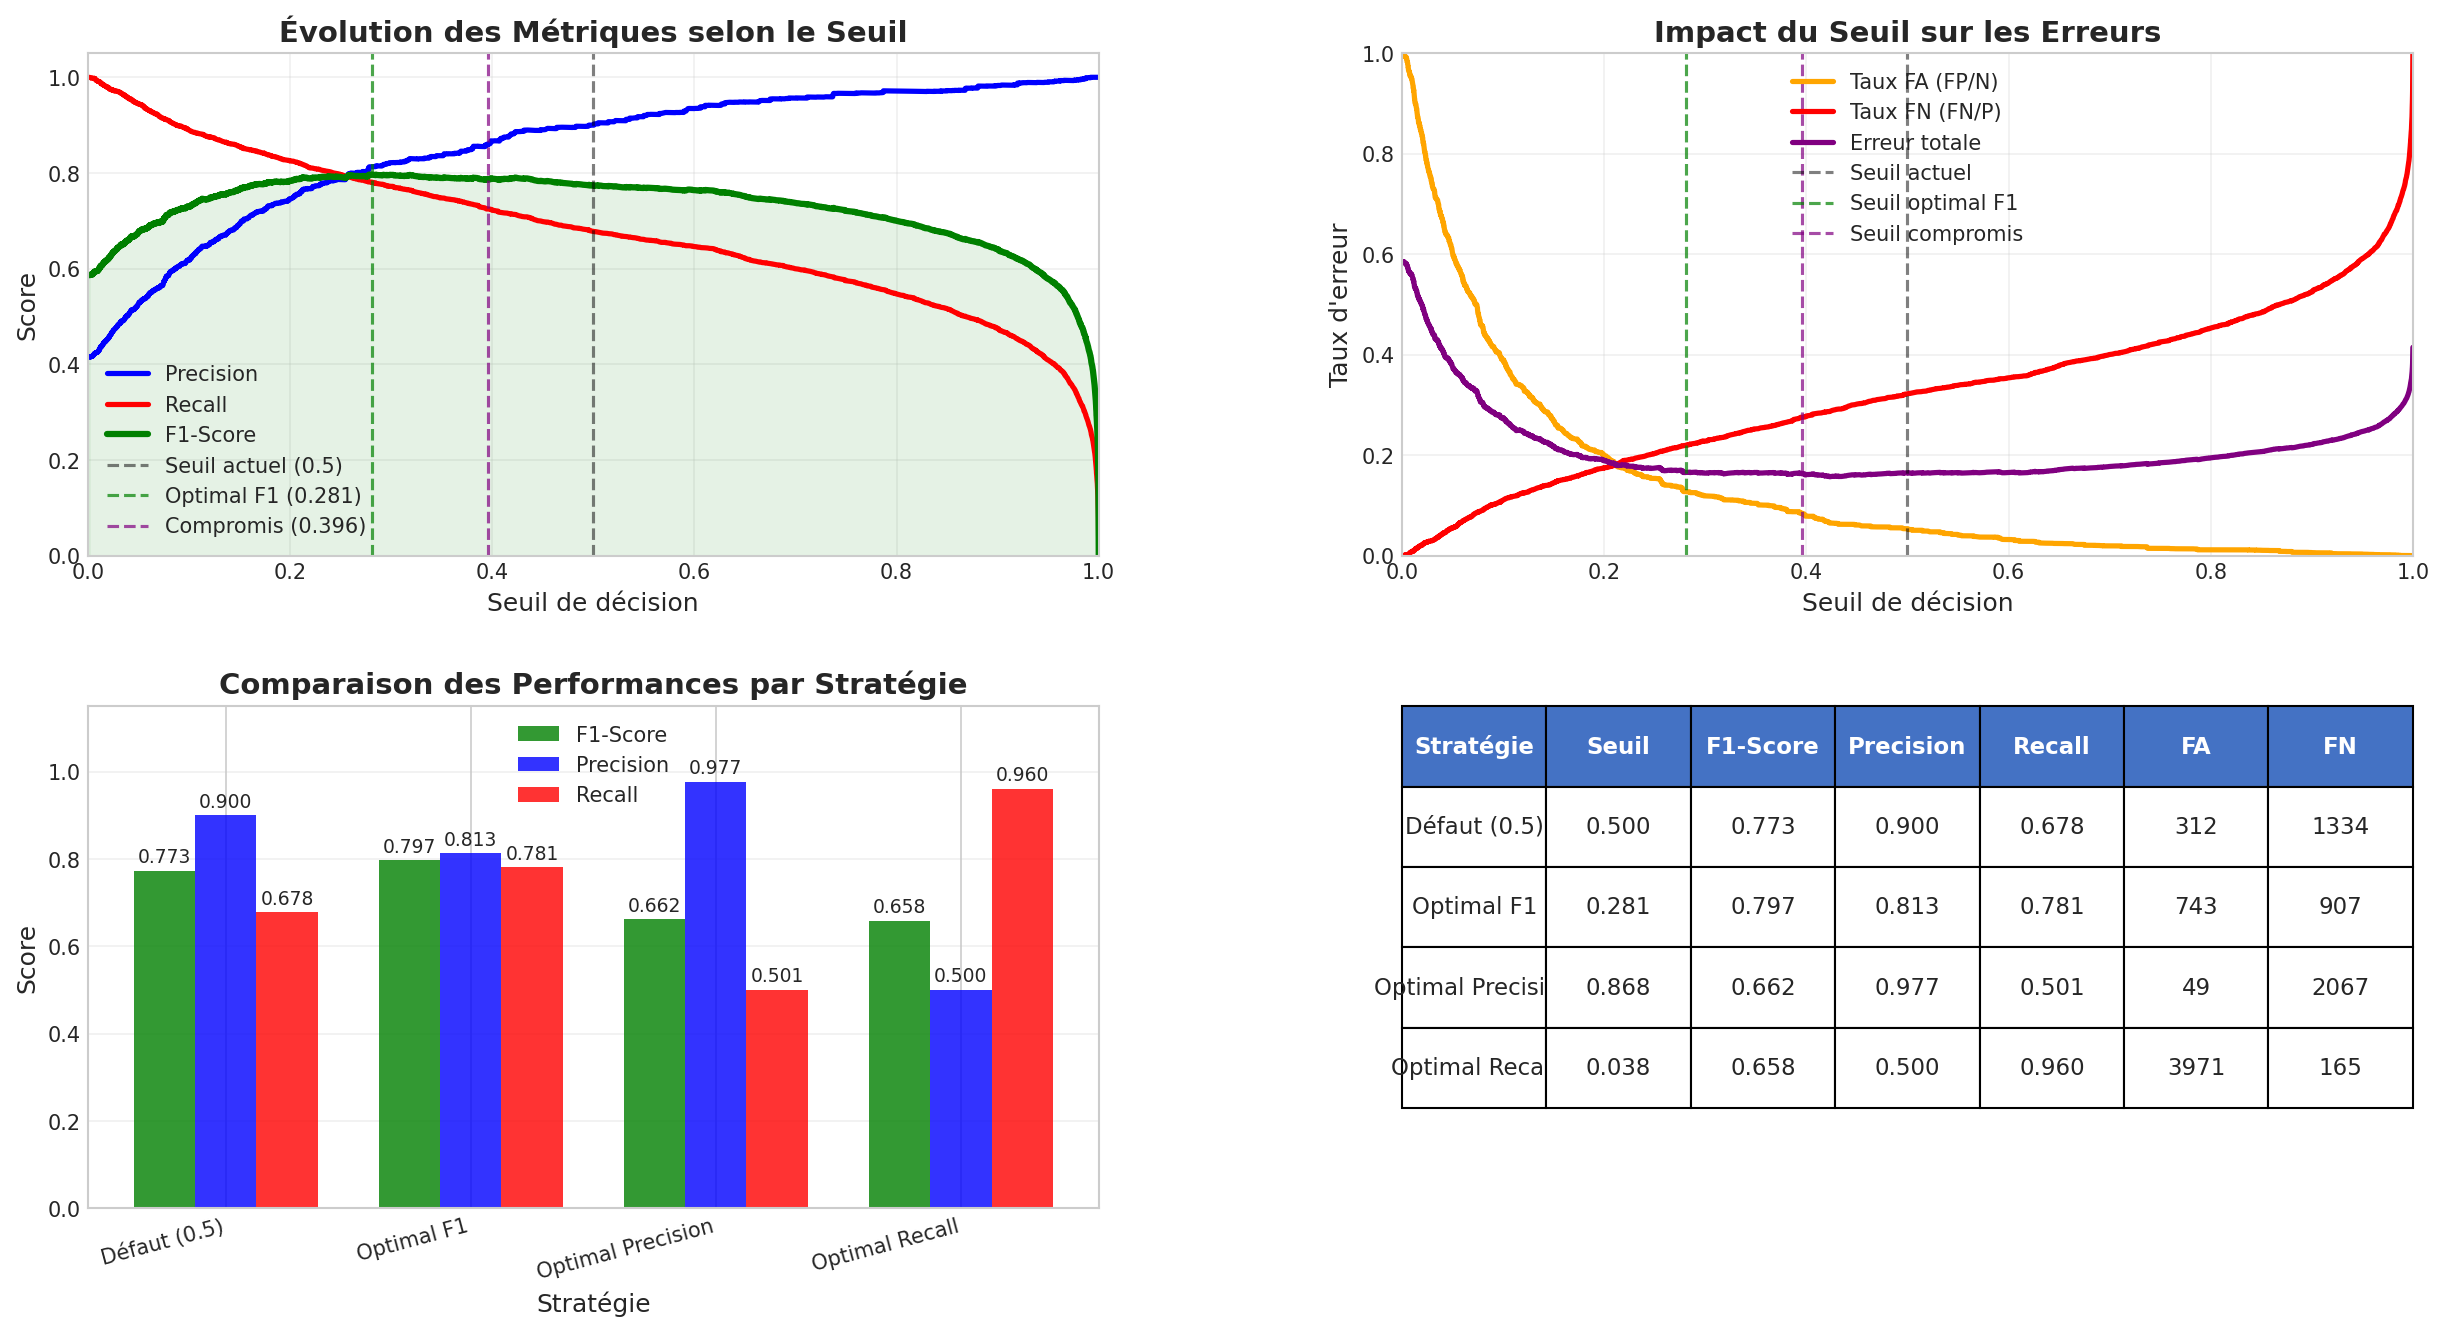

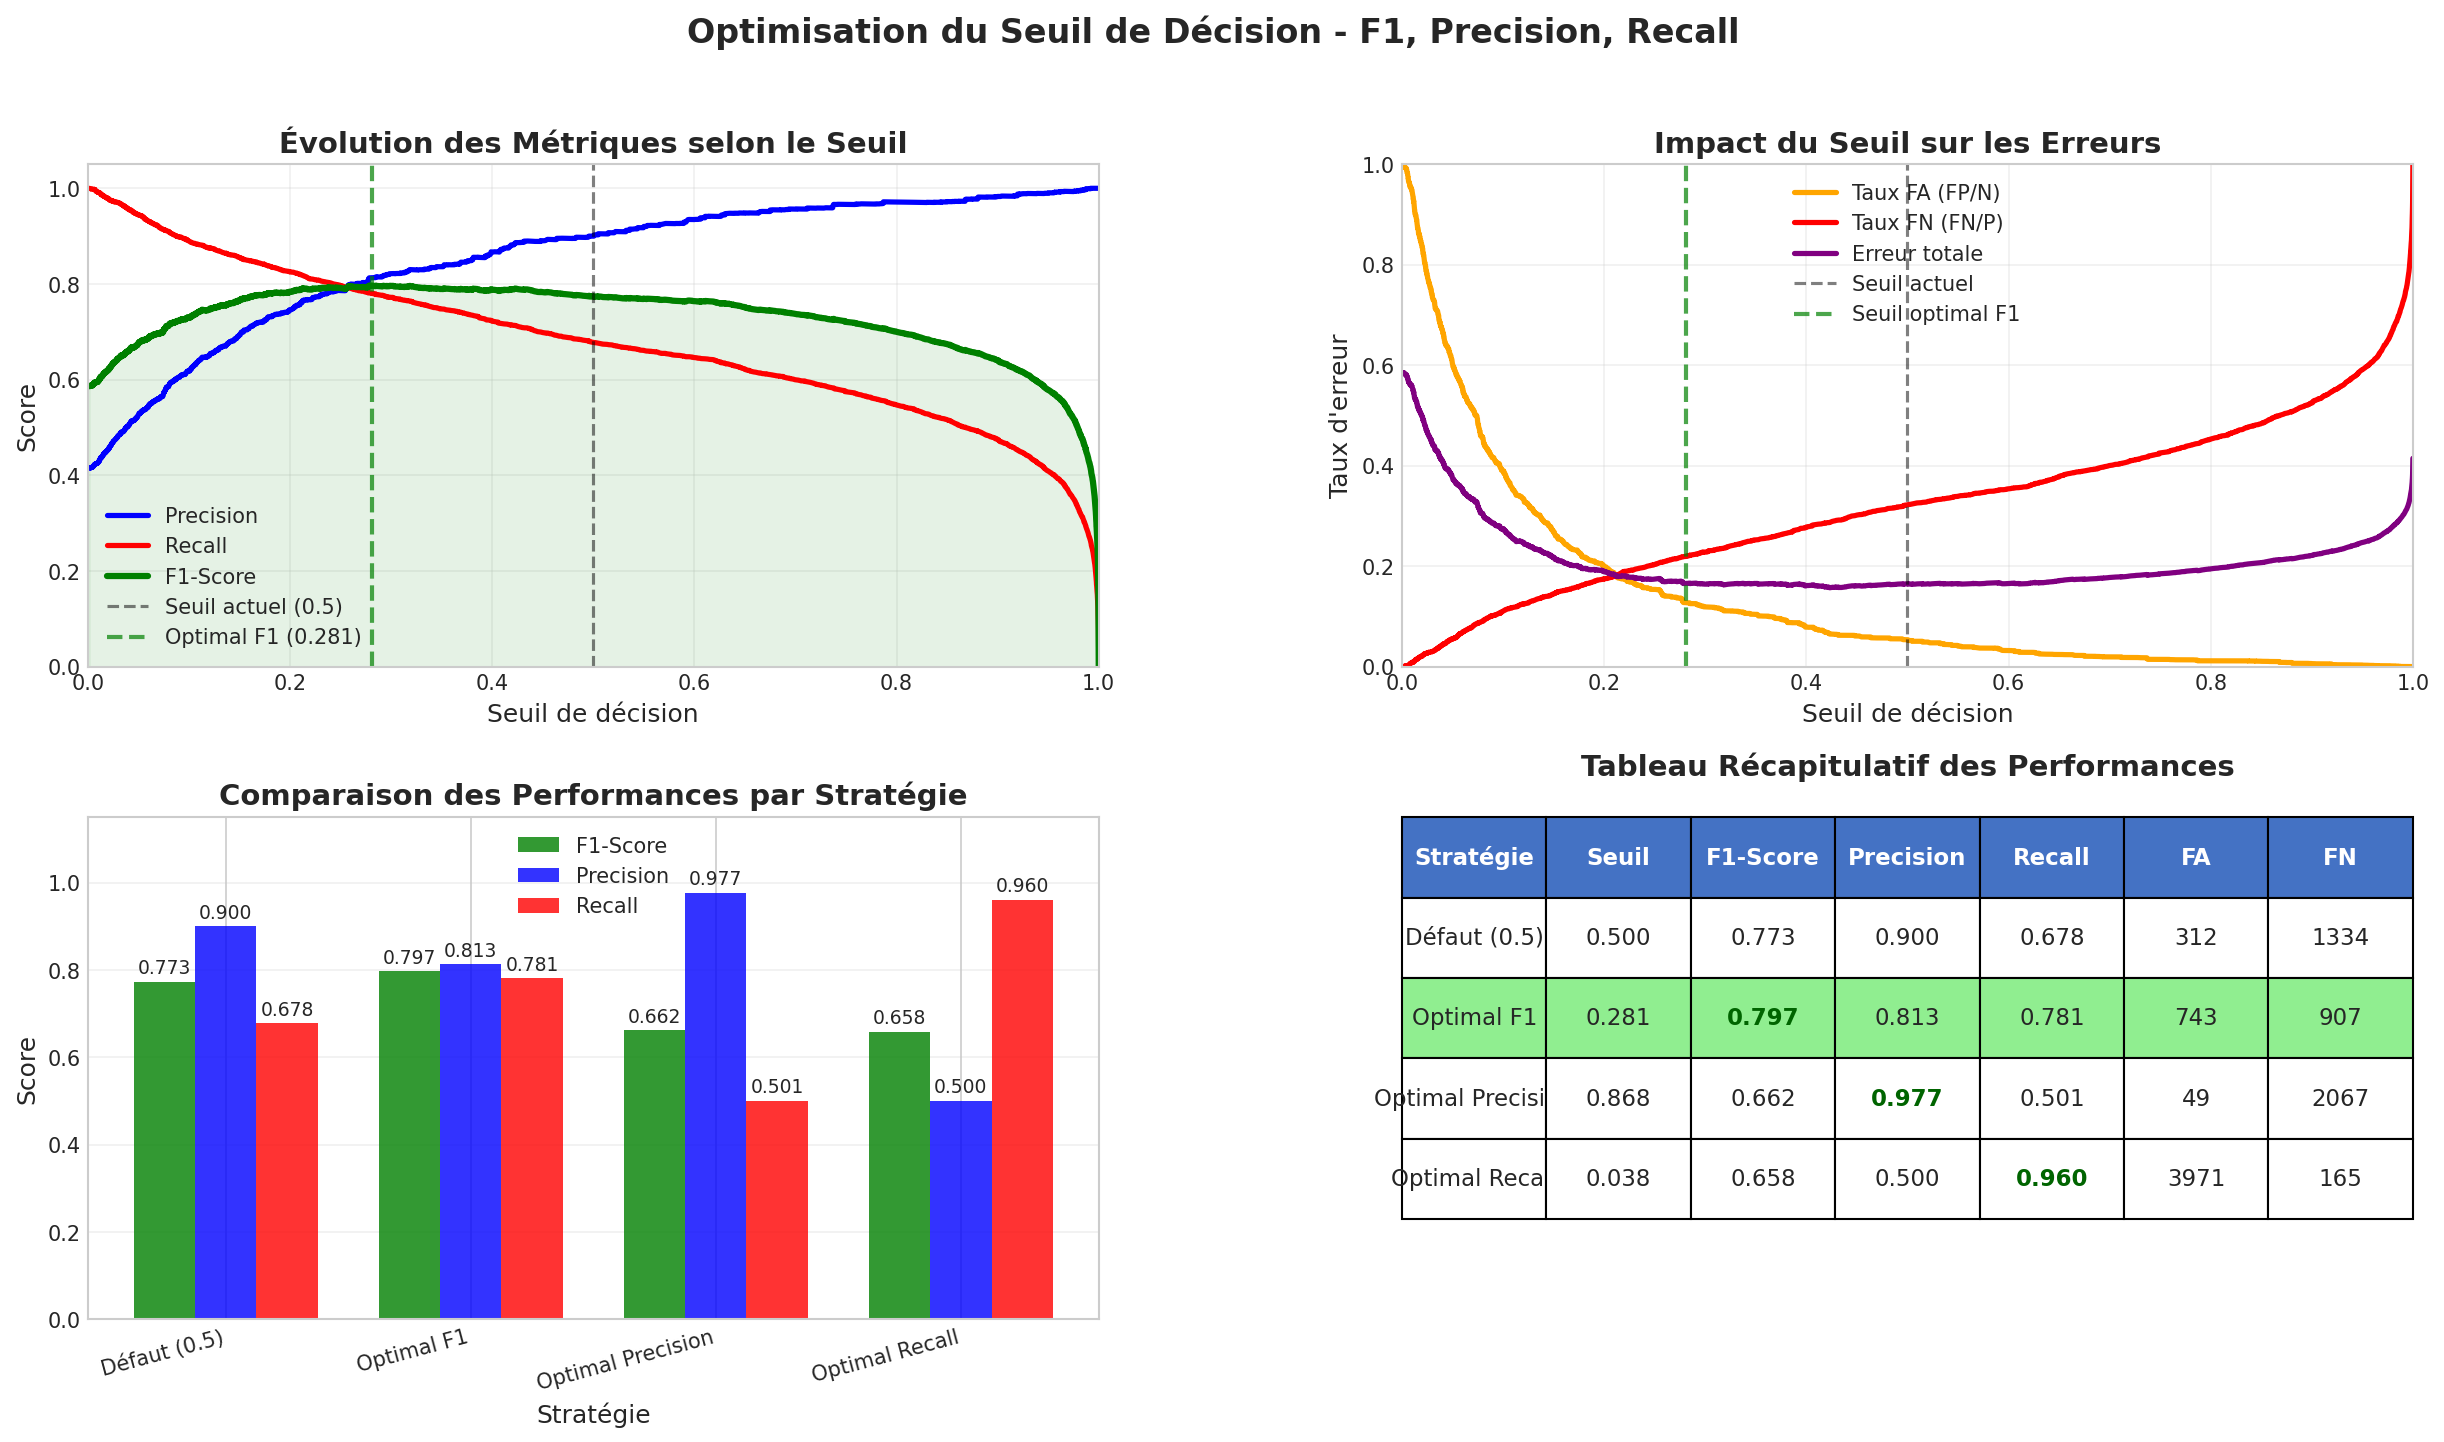


 RÉSUMÉ DES RÉSULTATS

📊 Tableau des performances:
        Stratégie    Seuil  F1-Score  Precision   Recall   FA   FN
     Défaut (0.5) 0.500000  0.773216   0.899936 0.677778  312 1334
       Optimal F1 0.280791  0.796698   0.813129 0.780918  743  907
Optimal Precision 0.867971  0.662089   0.976909 0.500725   49 2067
   Optimal Recall 0.038007  0.657786   0.500252 0.960145 3971  165

✅ RECOMMANDATION: Utiliser le seuil optimal F1 = 0.281

📈 Améliorations par rapport au seuil par défaut (0.5):
   → F1-Score: 0.773 → 0.797 (+0.023)
   → Precision: 0.900 → 0.813 (-0.087)
   → Recall: 0.678 → 0.781 (+0.103)

📊 Impact sur les erreurs:
   → Fausses Alarmes: 312 → 743 (+431)
   → Défauts Manqués: 1334 → 907 (-427)


In [0]:
print("\n" + "="*80)
print(" PHASE 11: OPTIMISATION DU SEUIL DE DÉCISION")
print("         BASÉE SUR LE F1-SCORE")
print("="*80)

from sklearn.metrics import precision_recall_curve, confusion_matrix
import pandas as pd

print("\n Collecte des données de tous les pourcentages...")
all_y_true = []
all_y_prob = []

for pct in PERCENTAGES_TO_TEST:
    df_test = datasets_test[pct]
    X_test_full, y_test, _ = prepare_features(df_test)
    X_test_scaled = best_scaler.transform(X_test_full)
    
    if best_feature_method == "all":
        X_test_selected = X_test_scaled
    else:
        X_test_selected = X_test_scaled[:, selected_indices]
    
    if hasattr(best_final_model, 'predict_proba'):
        y_prob = best_final_model.predict_proba(X_test_selected)[:, 1]
        all_y_true.extend(y_test)
        all_y_prob.extend(y_prob)

all_y_true = np.array(all_y_true)
all_y_prob = np.array(all_y_prob)

print(f"✓ Total d'échantillons collectés: {len(all_y_true)}")

if hasattr(best_final_model, 'predict_proba'):
    precision, recall, thresholds = precision_recall_curve(all_y_true, all_y_prob)
    
    # Calculer F1 pour chaque seuil
    f1_scores = np.where((precision + recall) == 0, 0, 
                        2 * (precision * recall) / (precision + recall))
    
    
    # 1. Seuil optimal pour F1
    optimal_idx_f1 = np.argmax(f1_scores[:-1])
    optimal_threshold_f1 = thresholds[optimal_idx_f1]
    
    # 2. Seuil optimal pour Precision (avec recall > 0.5)
    mask_recall = recall[:-1] > 0.5
    if np.any(mask_recall):
        valid_precision = precision[:-1][mask_recall]
        optimal_idx_precision = np.argmax(valid_precision)
        optimal_threshold_precision = thresholds[mask_recall][optimal_idx_precision]
    else:
        optimal_threshold_precision = 0.5
    
    # 3. Seuil optimal pour Recall (avec precision > 0.5)
    mask_precision = precision[:-1] > 0.5
    if np.any(mask_precision):
        valid_recall = recall[:-1][mask_precision]
        optimal_idx_recall = np.argmax(valid_recall)
        optimal_threshold_recall = thresholds[mask_precision][optimal_idx_recall]
    else:
        optimal_threshold_recall = 0.5
    
    print(f"\n SEUILS OPTIMAUX TROUVÉS:")
    print(f" - Pour maximiser F1-Score: {optimal_threshold_f1:.3f}")
    print(f" - Pour maximiser Precision: {optimal_threshold_precision:.3f}")
    print(f" - Pour maximiser Recall: {optimal_threshold_recall:.3f}")
    
    
    seuils_a_tester = [
        ('Défaut (0.5)', 0.5),
        ('Optimal F1', optimal_threshold_f1),
        ('Optimal Precision', optimal_threshold_precision),
        ('Optimal Recall', optimal_threshold_recall)
    ]
    
    resultats = []
    
    for nom, seuil in seuils_a_tester:
        y_pred = (all_y_prob >= seuil).astype(int)
        
        prec = precision_score(all_y_true, y_pred, zero_division=0)
        rec = recall_score(all_y_true, y_pred, zero_division=0)
        f1 = f1_score(all_y_true, y_pred, zero_division=0)
        
        # Calculer FA et FN
        tn, fp, fn, tp = confusion_matrix(all_y_true, y_pred).ravel()
        
        resultats.append({
            'Stratégie': nom,
            'Seuil': seuil,
            'F1-Score': f1,
            'Precision': prec,
            'Recall': rec,
            'FA': fp,
            'FN': fn
        })
    
    df_resultats = pd.DataFrame(resultats)
    
    
    fig = plt.figure(figsize=(20, 10))
    
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Courbes des 3 métriques vs Seuil (en haut à gauche)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2.5)
    ax1.plot(thresholds, recall[:-1], 'r-', label='Recall', linewidth=2.5)
    ax1.plot(thresholds, f1_scores[:-1], 'g-', label='F1-Score', linewidth=3)
    
    ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Seuil actuel (0.5)')
    ax1.axvline(x=optimal_threshold_f1, color='green', linestyle='--', alpha=0.7, 
                label=f'Optimal F1 ({optimal_threshold_f1:.3f})', linewidth=2)
    
    ax1.fill_between(thresholds, 0, f1_scores[:-1], alpha=0.1, color='green')
    ax1.set_xlabel('Seuil de décision', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Évolution des Métriques selon le Seuil', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1.05)
    
    # Plot 2: Impact sur les erreurs (en haut à droite)
    ax2 = fig.add_subplot(gs[0, 1])
    
    fa_rates = []
    fn_rates = []
    total_errors = []
    
    for thresh in thresholds:
        y_pred_thresh = (all_y_prob >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(all_y_true, y_pred_thresh).ravel()
        
        # Taux de fausses alarmes
        fa_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        # Taux de faux négatifs  
        fn_rate = fn / (tp + fn) if (tp + fn) > 0 else 0
        # Taux d'erreur total
        total_error = (fp + fn) / len(all_y_true)
        
        fa_rates.append(fa_rate)
        fn_rates.append(fn_rate)
        total_errors.append(total_error)
    
    ax2.plot(thresholds, fa_rates, 'orange', linewidth=2.5, label='Taux FA (FP/N)')
    ax2.plot(thresholds, fn_rates, 'red', linewidth=2.5, label='Taux FN (FN/P)')
    ax2.plot(thresholds, total_errors, 'purple', linewidth=2.5, label='Erreur totale')
    
    ax2.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Seuil actuel')
    ax2.axvline(x=optimal_threshold_f1, color='green', linestyle='--', alpha=0.7, 
                label='Seuil optimal F1', linewidth=2)
    
    ax2.set_xlabel('Seuil de décision', fontsize=12)
    ax2.set_ylabel('Taux d\'erreur', fontsize=12)
    ax2.set_title('Impact du Seuil sur les Erreurs', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    # Plot 3: Comparaison des métriques en barres (en bas à gauche)
    ax3 = fig.add_subplot(gs[1, 0])
    x = np.arange(len(df_resultats))
    width = 0.25
    
    bars1 = ax3.bar(x - width, df_resultats['F1-Score'], width, label='F1-Score', color='green', alpha=0.8)
    bars2 = ax3.bar(x, df_resultats['Precision'], width, label='Precision', color='blue', alpha=0.8)
    bars3 = ax3.bar(x + width, df_resultats['Recall'], width, label='Recall', color='red', alpha=0.8)
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax3.set_xlabel('Stratégie', fontsize=12)
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('Comparaison des Performances par Stratégie', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([r['Stratégie'] for r in resultats], rotation=15, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, 1.15)
    
    # Plot 4: Tableau des résultats (en bas à droite)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for _, row in df_resultats.iterrows():
        table_data.append([
            row['Stratégie'],
            f"{row['Seuil']:.3f}",
            f"{row['F1-Score']:.3f}",
            f"{row['Precision']:.3f}",
            f"{row['Recall']:.3f}",
            f"{row['FA']}",
            f"{row['FN']}"
        ])
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Stratégie', 'Seuil', 'F1-Score', 'Precision', 'Recall', 'FA', 'FN'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0.2, 1, 0.8])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)
    
    for i in range(7):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for j in range(7):
        table[(2, j)].set_facecolor('#90EE90')
    
    best_f1_idx = df_resultats['F1-Score'].idxmax() + 1
    best_prec_idx = df_resultats['Precision'].idxmax() + 1
    best_rec_idx = df_resultats['Recall'].idxmax() + 1
    
    table[(best_f1_idx, 2)].set_text_props(weight='bold', color='darkgreen')
    table[(best_prec_idx, 3)].set_text_props(weight='bold', color='darkgreen')
    table[(best_rec_idx, 4)].set_text_props(weight='bold', color='darkgreen')
    
    ax4.set_title('Tableau Récapitulatif des Performances', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('Optimisation du Seuil de Décision - F1, Precision, Recall', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(EXPORT_DIR, 'threshold_optimization_4plots.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*50)
    print(" RÉSUMÉ DES RÉSULTATS")
    print("="*50)
    
    print("\n Tableau des performances:")
    print(df_resultats.to_string(index=False))
    
    f1_default = df_resultats[df_resultats['Stratégie'] == 'Défaut (0.5)']['F1-Score'].values[0]
    f1_optimal = df_resultats[df_resultats['Stratégie'] == 'Optimal F1']['F1-Score'].values[0]
    
    prec_default = df_resultats[df_resultats['Stratégie'] == 'Défaut (0.5)']['Precision'].values[0]
    prec_optimal = df_resultats[df_resultats['Stratégie'] == 'Optimal F1']['Precision'].values[0]
    
    rec_default = df_resultats[df_resultats['Stratégie'] == 'Défaut (0.5)']['Recall'].values[0]
    rec_optimal = df_resultats[df_resultats['Stratégie'] == 'Optimal F1']['Recall'].values[0]
    
    fa_default = df_resultats[df_resultats['Stratégie'] == 'Défaut (0.5)']['FA'].values[0]
    fa_optimal = df_resultats[df_resultats['Stratégie'] == 'Optimal F1']['FA'].values[0]
    
    fn_default = df_resultats[df_resultats['Stratégie'] == 'Défaut (0.5)']['FN'].values[0]
    fn_optimal = df_resultats[df_resultats['Stratégie'] == 'Optimal F1']['FN'].values[0]
    
    print(f"\n RECOMMANDATION: Utiliser le seuil optimal F1 = {optimal_threshold_f1:.3f}")
    print(f"\n Améliorations par rapport au seuil par défaut (0.5):")
    print(f"   → F1-Score: {f1_default:.3f} → {f1_optimal:.3f} ({(f1_optimal-f1_default):+.3f})")
    print(f"   → Precision: {prec_default:.3f} → {prec_optimal:.3f} ({(prec_optimal-prec_default):+.3f})")
    print(f"   → Recall: {rec_default:.3f} → {rec_optimal:.3f} ({(rec_optimal-rec_default):+.3f})")
    print(f"\n Impact sur les erreurs:")
    print(f"   → Fausses Alarmes: {fa_default} → {fa_optimal} ({fa_optimal-fa_default:+d})")
    print(f"   → Défauts Manqués: {fn_default} → {fn_optimal} ({fn_optimal-fn_default:+d})")
    
else:
    print(" Le modèle ne supporte pas predict_proba, optimisation du seuil impossible")


 INFORMATIONS CONTEXTUELLES POUR L'INTERPRÉTATION

📊 DONNÉES TOTALES ANALYSÉES:
   - Nombre total d'échantillons: 9,981
   - Nombre de défauts réels: 4,140 (41.5%)
   - Nombre d'échantillons normaux: 5,841 (58.5%)

 TABLEAU DÉTAILLÉ AVEC CONTEXTE

--------------------------------------------------------------------------------------------------------------------------------------------
     Stratégie       |  Défauts détectés  |  Défauts manqués   |  Fausses alarmes   |    F1    | Économie FA 
--------------------------------------------------------------------------------------------------------------------------------------------
    Défaut (0.5)     |     2806/4140      |     1334/4140      |      312/5841      |  0.773   |      -      
     Optimal F1      |     3233/4140      |      907/4140      |      743/5841      |  0.797   |     +431    
 Optimal Precision   |     2073/4140      |     2067/4140      |      49/5841       |  0.662   |     -263    
   Optimal Recall    |     39

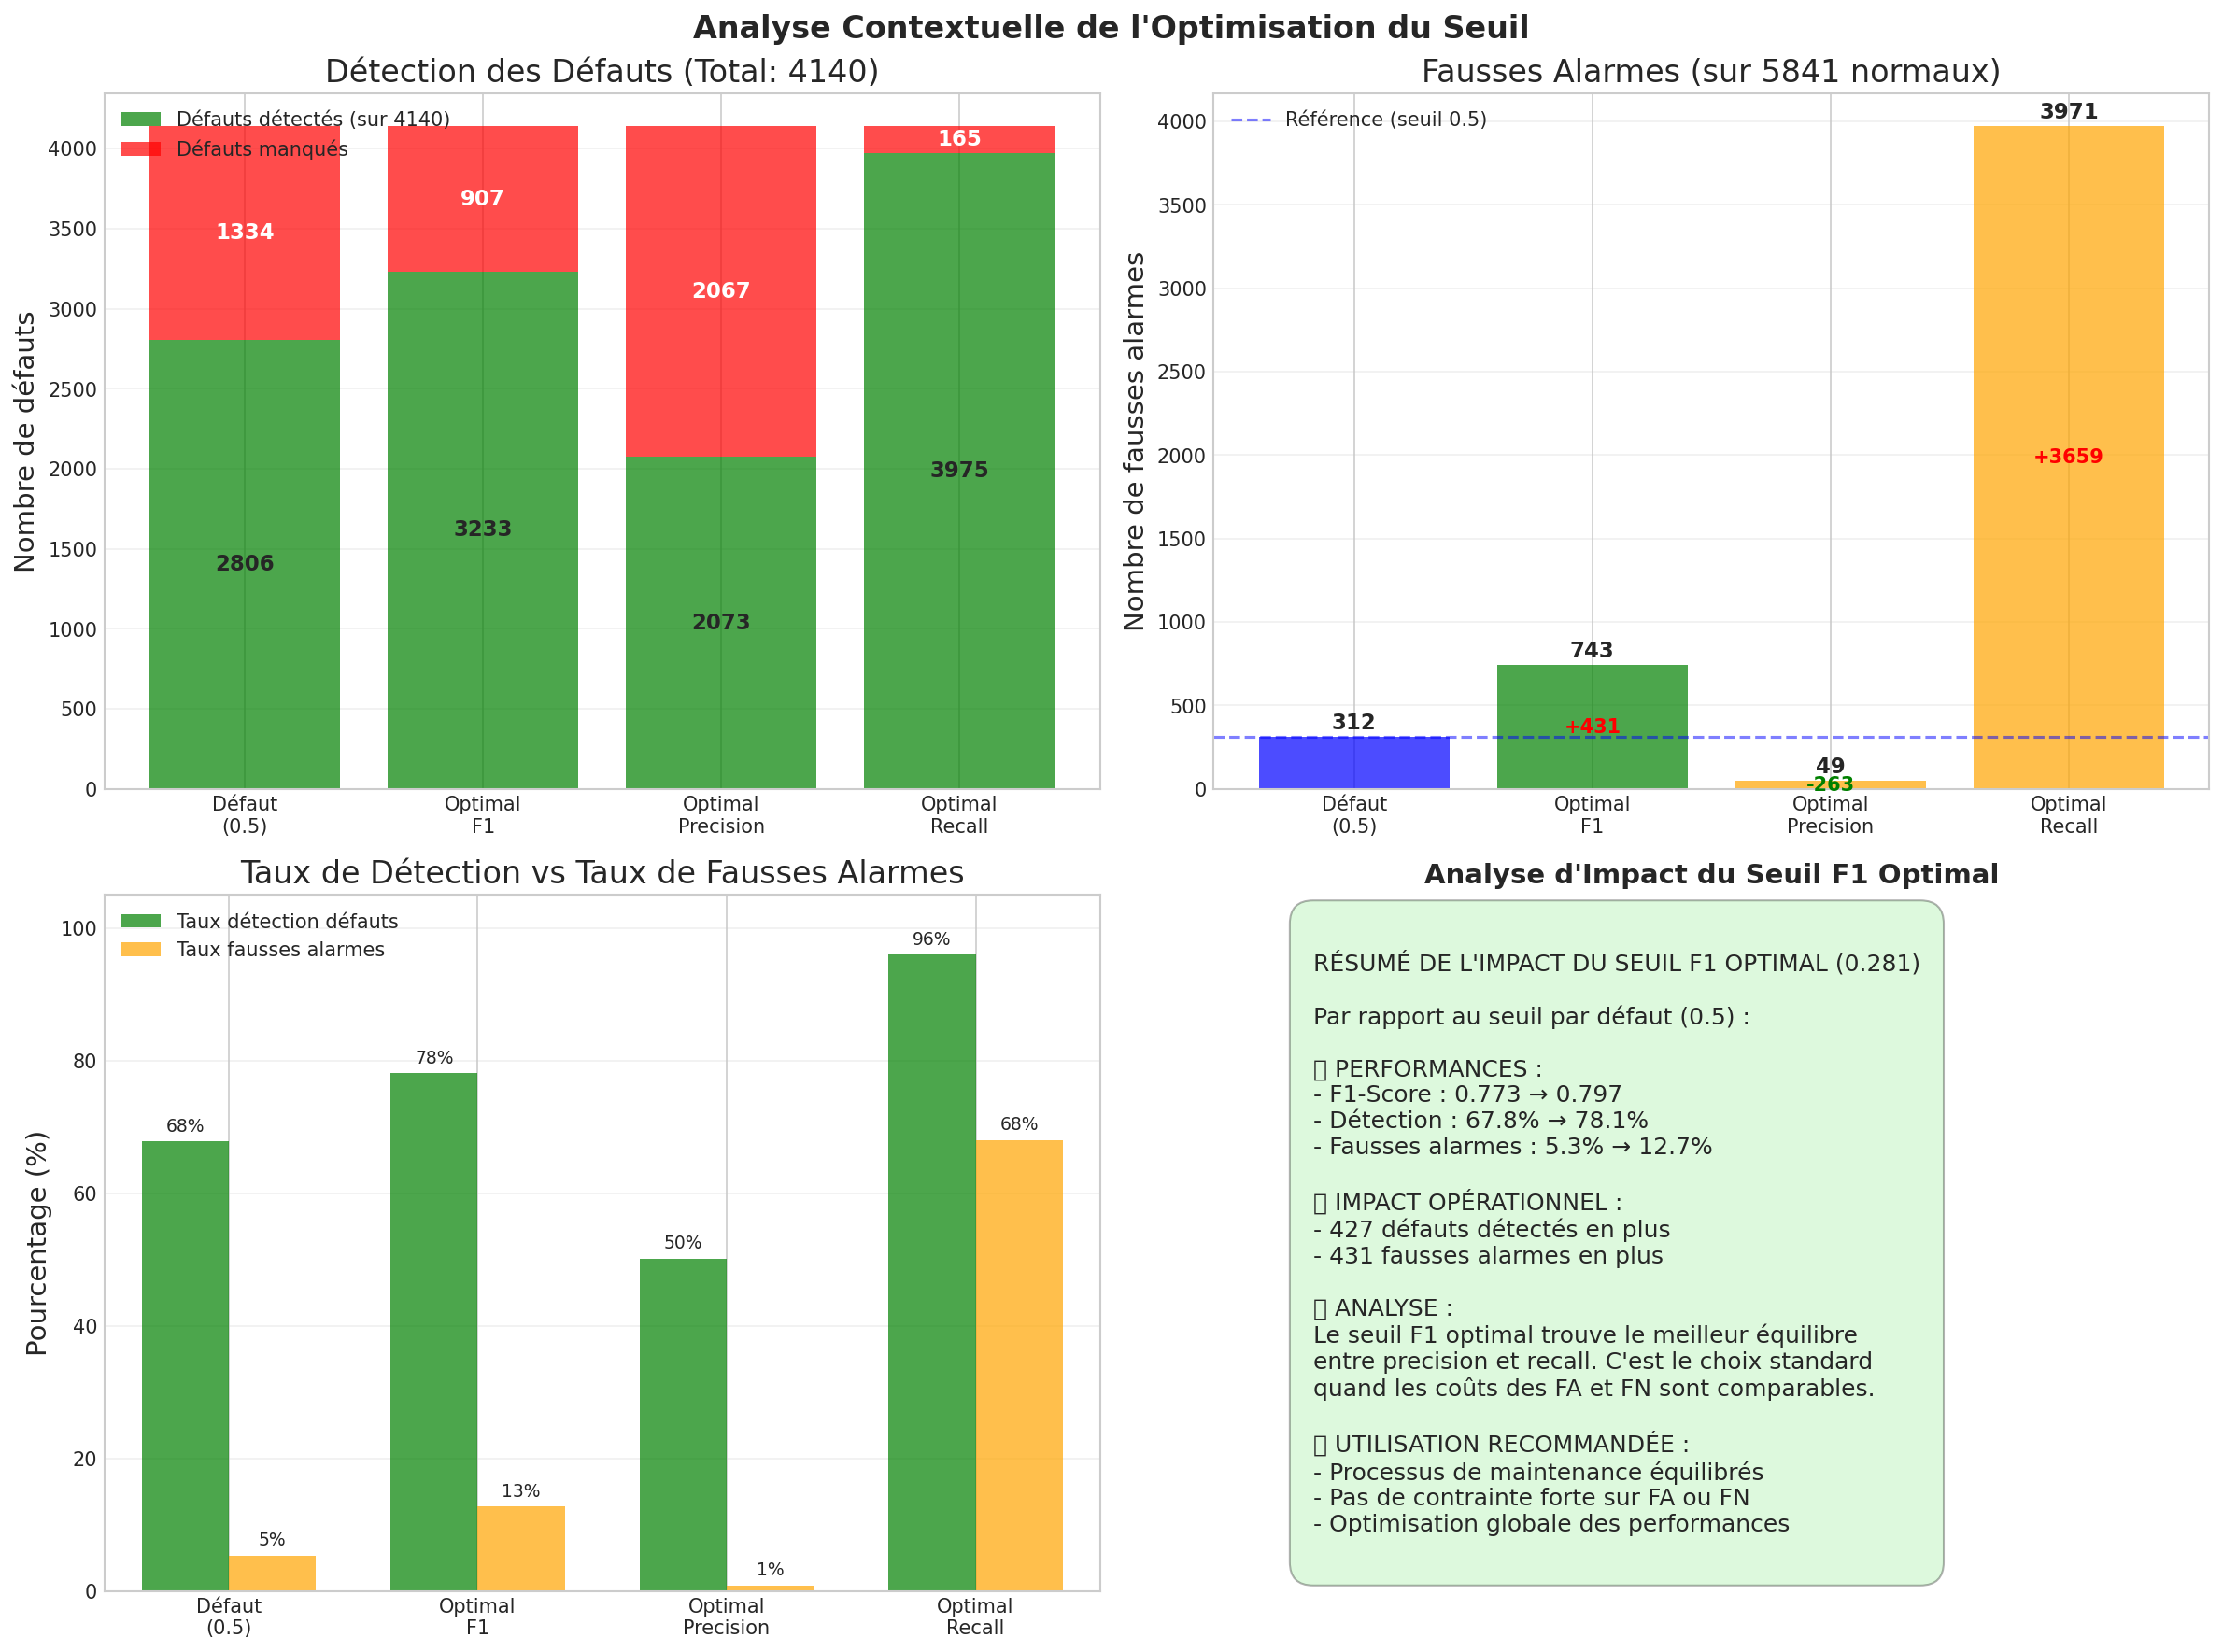


💡 SYNTHÈSE DES STRATÉGIES:

1. SEUIL F1 OPTIMAL (0.281) - RECOMMANDÉ
   ✅ Meilleur équilibre global (F1 = 0.797)
   → Détecte 78.1% des défauts
   → Génère 12.7% de fausses alarmes

2. SEUIL PRECISION (0.868)
   ✅ Minimise les fausses alarmes (0.8%)
   ⚠️ Mais détecte seulement 50.1% des défauts

3. SEUIL RECALL (0.038)
   ✅ Maximise la détection (96.0% des défauts)
   ⚠️ Mais génère 68.0% de fausses alarmes

🎯 RECOMMANDATION FINALE:
   Utilisez le seuil F1 optimal = 0.281
   Sauf si vous avez des contraintes spécifiques sur les FA ou FN


In [0]:
print("\n" + "="*80)
print(" INFORMATIONS CONTEXTUELLES POUR L'INTERPRÉTATION")
print("="*80)

total_samples = len(all_y_true)
total_defauts = int(all_y_true.sum())
total_normaux = total_samples - total_defauts

print(f"\n DONNÉES TOTALES ANALYSÉES:")
print(f"   - Nombre total d'échantillons: {total_samples:,}")
print(f"   - Nombre de défauts réels: {total_defauts:,} ({total_defauts/total_samples*100:.1f}%)")
print(f"   - Nombre d'échantillons normaux: {total_normaux:,} ({total_normaux/total_samples*100:.1f}%)")

print("\n" + "="*80)
print(" TABLEAU DÉTAILLÉ AVEC CONTEXTE")
print("="*80)

resultats_detailles = []

fa_default = None

for idx, (nom, seuil) in enumerate(seuils_a_tester):
    y_pred = (all_y_prob >= seuil).astype(int)
    tn, fp, fn, tp = confusion_matrix(all_y_true, y_pred).ravel()
    
    if nom == 'Défaut (0.5)':
        fa_default = fp
    
    taux_fa = fp / total_normaux * 100  # % de normaux mal classés
    taux_fn = fn / total_defauts * 100  # % de défauts manqués
    taux_detection = tp / total_defauts * 100  # % de défauts détectés
    taux_vn = tn / total_normaux * 100  # % de normaux bien classés
    
    resultats_detailles.append({
        'Stratégie': nom,
        'Seuil': seuil,
        'F1-Score': f1_score(all_y_true, y_pred),
        'Défauts détectés': f"{tp}/{total_defauts}",
        'Taux détection': f"{taux_detection:.1f}%",
        'Défauts manqués': f"{fn}/{total_defauts}",
        'Taux manqués': f"{taux_fn:.1f}%",
        'Fausses alarmes': f"{fp}/{total_normaux}",
        'Taux FA': f"{taux_fa:.1f}%",
        'Économie FA': fp - fa_default if fa_default is not None and nom != 'Défaut (0.5)' else 0
    })

df_resultats_detailles = pd.DataFrame(resultats_detailles)

print("\n" + "-"*140)
print(f"{'Stratégie':^20} | {'Défauts détectés':^18} | {'Défauts manqués':^18} | {'Fausses alarmes':^18} | {'F1':^8} | {'Économie FA':^12}")
print("-"*140)

for _, row in df_resultats_detailles.iterrows():
    economie = f"{row['Économie FA']:+d}" if row['Économie FA'] != 0 else "-"
    print(f"{row['Stratégie']:^20} | {row['Défauts détectés']:^18} | {row['Défauts manqués']:^18} | "
          f"{row['Fausses alarmes']:^18} | {row['F1-Score']:^8.3f} | {economie:^12}")
print("-"*140)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Impact en valeurs absolues
strategies = df_resultats_detailles['Stratégie'].values
x = np.arange(len(strategies))

defauts_detectes = [int(d.split('/')[0]) for d in df_resultats_detailles['Défauts détectés']]
defauts_manques = [int(d.split('/')[0]) for d in df_resultats_detailles['Défauts manqués']]
fausses_alarmes = [int(d.split('/')[0]) for d in df_resultats_detailles['Fausses alarmes']]

ax1.bar(x, defauts_detectes, label=f'Défauts détectés (sur {total_defauts})', color='green', alpha=0.7)
ax1.bar(x, defauts_manques, bottom=defauts_detectes, label=f'Défauts manqués', color='red', alpha=0.7)

for i, (det, manq) in enumerate(zip(defauts_detectes, defauts_manques)):
    ax1.text(i, det/2, f'{det}', ha='center', va='center', fontweight='bold')
    ax1.text(i, det + manq/2, f'{manq}', ha='center', va='center', fontweight='bold', color='white')

ax1.set_xticks(x)
ax1.set_xticklabels([s.replace(' ', '\n') for s in strategies], rotation=0)
ax1.set_ylabel('Nombre de défauts')
ax1.set_title(f'Détection des Défauts (Total: {total_defauts})')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Fausses alarmes
colors = []
for s in strategies:
    if s == 'Défaut (0.5)':
        colors.append('blue')
    elif s == 'Optimal F1':
        colors.append('green')
    else:
        colors.append('orange')

ax2.bar(x, fausses_alarmes, color=colors, alpha=0.7)
ax2.axhline(y=fausses_alarmes[0], color='blue', linestyle='--', alpha=0.5, label='Référence (seuil 0.5)')

for i, fa in enumerate(fausses_alarmes):
    ax2.text(i, fa + 20, f'{fa}', ha='center', va='bottom', fontweight='bold')
    if i > 0:
        diff = fa - fausses_alarmes[0]
        ax2.text(i, fa/2, f'{diff:+d}', ha='center', va='center', fontsize=10, 
                color='green' if diff < 0 else 'red', fontweight='bold')

ax2.set_xticks(x)
ax2.set_xticklabels([s.replace(' ', '\n') for s in strategies], rotation=0)
ax2.set_ylabel('Nombre de fausses alarmes')
ax2.set_title(f'Fausses Alarmes (sur {total_normaux} normaux)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Taux en pourcentage
ax3.set_xlim(-0.5, len(strategies) - 0.5)
ax3.set_ylim(0, 105)

taux_detection = [float(t.strip('%')) for t in df_resultats_detailles['Taux détection']]
taux_fa = [float(t.strip('%')) for t in df_resultats_detailles['Taux FA']]

width = 0.35
ax3.bar(x - width/2, taux_detection, width, label='Taux détection défauts', color='green', alpha=0.7)
ax3.bar(x + width/2, taux_fa, width, label='Taux fausses alarmes', color='orange', alpha=0.7)

for i, (td, tfa) in enumerate(zip(taux_detection, taux_fa)):
    ax3.text(i - width/2, td + 1, f'{td:.0f}%', ha='center', va='bottom', fontsize=9)
    ax3.text(i + width/2, tfa + 1, f'{tfa:.0f}%', ha='center', va='bottom', fontsize=9)

ax3.set_xticks(x)
ax3.set_xticklabels([s.replace(' ', '\n') for s in strategies], rotation=0)
ax3.set_ylabel('Pourcentage (%)')
ax3.set_title('Taux de Détection vs Taux de Fausses Alarmes')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Résumé textuel
ax4.axis('off')

idx_f1 = list(strategies).index('Optimal F1')
idx_default = list(strategies).index('Défaut (0.5)')

defauts_gagnes = defauts_detectes[idx_f1] - defauts_detectes[idx_default]
fa_difference = fausses_alarmes[idx_f1] - fausses_alarmes[idx_default]

summary_text = f"""
RÉSUMÉ DE L'IMPACT DU SEUIL F1 OPTIMAL ({optimal_threshold_f1:.3f})

Par rapport au seuil par défaut (0.5) :

 PERFORMANCES :
- F1-Score : {df_resultats_detailles.iloc[idx_default]['F1-Score']:.3f} → {df_resultats_detailles.iloc[idx_f1]['F1-Score']:.3f}
- Détection : {taux_detection[idx_default]:.1f}% → {taux_detection[idx_f1]:.1f}%
- Fausses alarmes : {taux_fa[idx_default]:.1f}% → {taux_fa[idx_f1]:.1f}%

 IMPACT OPÉRATIONNEL :
- {abs(defauts_gagnes)} défauts {'détectés en plus' if defauts_gagnes > 0 else 'détectés en moins'}
- {abs(fa_difference)} fausses alarmes {'en plus' if fa_difference > 0 else 'en moins'}

"""

ax4.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightgreen', alpha=0.3))
ax4.set_title('Analyse d\'Impact du Seuil F1 Optimal', fontsize=14, fontweight='bold')

plt.suptitle('Analyse Contextuelle de l\'Optimisation du Seuil', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'threshold_optimization_context_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n SYNTHÈSE DES STRATÉGIES:")
print(f"\n1. SEUIL F1 OPTIMAL ({optimal_threshold_f1:.3f}) - RECOMMANDÉ")
print(f"    Meilleur équilibre global (F1 = {df_resultats_detailles.iloc[idx_f1]['F1-Score']:.3f})")
print(f"   → Détecte {taux_detection[idx_f1]:.1f}% des défauts")
print(f"   → Génère {taux_fa[idx_f1]:.1f}% de fausses alarmes")

idx_precision = list(strategies).index('Optimal Precision')
idx_recall = list(strategies).index('Optimal Recall')

print(f"\n2. SEUIL PRECISION ({optimal_threshold_precision:.3f})")
print(f"    Minimise les fausses alarmes ({taux_fa[idx_precision]:.1f}%)")
print(f"    Mais détecte seulement {taux_detection[idx_precision]:.1f}% des défauts")

print(f"\n3. SEUIL RECALL ({optimal_threshold_recall:.3f})")
print(f"    Maximise la détection ({taux_detection[idx_recall]:.1f}% des défauts)")
print(f"    Mais génère {taux_fa[idx_recall]:.1f}% de fausses alarmes")

print(f"\n RECOMMANDATION FINALE:")
print(f"   Utilisez le seuil F1 optimal = {optimal_threshold_f1:.3f}")
print(f"   Sauf si vous avez des contraintes spécifiques sur les FA ou FN")

19. Test des seuils sur chaque pourcentage de test


 TEST DES SEUILS OPTIMISÉS SUR CHAQUE POURCENTAGE

📊 Application des seuils sur chaque pourcentage:
------------------------------------------------------------------------------------------------------------------------
    % | F1 (0.5) | F1 (opt) | F1 (comp) |   Δ opt |  Δ comp | Prec (comp) | Rec (comp) |     AUC
------------------------------------------------------------------------------------------------------------------------
   10% |    0.426 |    0.531 |     0.476 |  +0.104 |  +0.050 |       0.618 |      0.387 |   0.668
   20% |    0.525 |    0.647 |     0.579 |  +0.122 |  +0.054 |       0.779 |      0.461 |   0.789
   30% |    0.687 |    0.771 |     0.720 |  +0.084 |  +0.033 |       0.856 |      0.622 |   0.878
   40% |    0.793 |    0.834 |     0.829 |  +0.041 |  +0.036 |       0.886 |      0.778 |   0.922
   50% |    0.845 |    0.859 |     0.853 |  +0.014 |  +0.008 |       0.891 |      0.817 |   0.939
   60% |    0.879 |    0.865 |     0.874 |  -0.014 |  -0.005 |       0

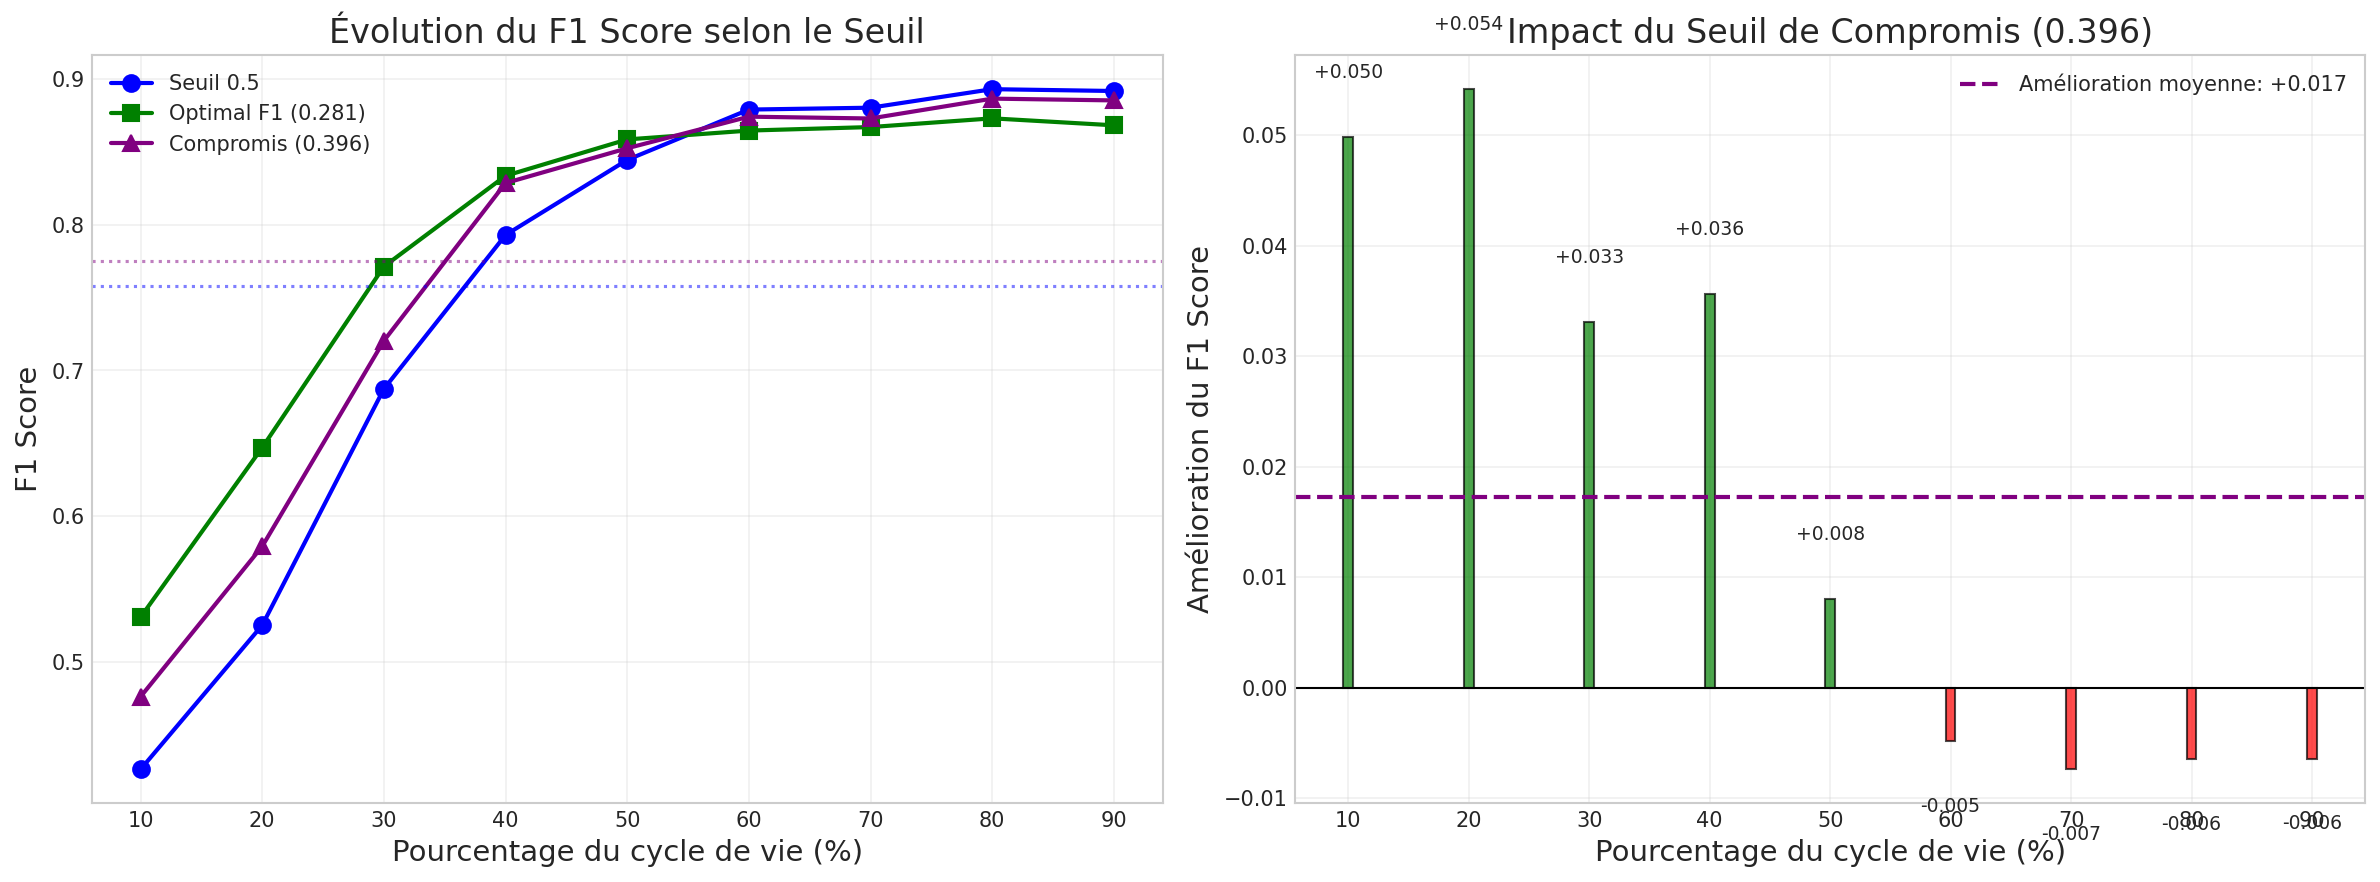


📋 TABLEAU RÉCAPITULATIF DÉTAILLÉ:

F1 Scores et améliorations:
Pourcentage  F1_Seuil_0.5  F1_Seuil_Compromis  Amélioration  Précision   Rappel
        10%      0.426087            0.475936      0.049849   0.618056 0.386957
        20%      0.525074            0.579235      0.054161   0.779412 0.460870
        30%      0.687332            0.720403      0.033071   0.856287 0.621739
        40%      0.793061            0.828704      0.035643   0.886139 0.778261
        50%      0.844603            0.852608      0.008005   0.890995 0.817391
        60%      0.879171            0.874305     -0.004867   0.895216 0.854348
        70%      0.880460            0.873051     -0.007409   0.894977 0.852174
        80%      0.893182            0.886689     -0.006493   0.897550 0.876087
        90%      0.891923            0.885463     -0.006460   0.897321 0.873913
    MOYENNE      0.757877            0.775155      0.017278   0.846217 0.724638

📊 ANALYSE DE L'IMPACT:
   Meilleure amélioration: 20.0%

In [0]:
print("\n" + "="*80)
print(" TEST DES SEUILS OPTIMISÉS SUR CHAQUE POURCENTAGE")
print("="*80)

results_by_percentage = []

print("\n Application des seuils sur chaque pourcentage:")
print("-" * 120)
print(f"{'%':>5} | {'F1 (0.5)':>8} | {'F1 (opt)':>8} | {'F1 (comp)':>9} | {'Δ opt':>7} | {'Δ comp':>7} | {'Prec (comp)':>11} | {'Rec (comp)':>10} | {'AUC':>7}")
print("-" * 120)

for pct in PERCENTAGES_TO_TEST:
    df_test = datasets_test[pct]
    X_test_full, y_test, _ = prepare_features(df_test)
    X_test_scaled = best_scaler.transform(X_test_full)
    
    if best_feature_method == "all":
        X_test_selected = X_test_scaled
    else:
        X_test_selected = X_test_scaled[:, selected_indices]
    
    y_prob = best_final_model.predict_proba(X_test_selected)[:, 1]
    
    # Seuil par défaut (0.5)
    y_pred_default = (y_prob >= 0.5).astype(int)
    f1_default = f1_score(y_test, y_pred_default)
    prec_default = precision_score(y_test, y_pred_default, zero_division=0)
    rec_default = recall_score(y_test, y_pred_default, zero_division=0)
    
    # Seuil optimal F1
    y_pred_opt = (y_prob >= optimal_threshold_f1).astype(int)
    f1_opt = f1_score(y_test, y_pred_opt)
    prec_opt = precision_score(y_test, y_pred_opt, zero_division=0)
    rec_opt = recall_score(y_test, y_pred_opt, zero_division=0)
    
    # Seuil compromis
    y_pred_comp = (y_prob >= optimal_threshold_compromis).astype(int)
    f1_comp = f1_score(y_test, y_pred_comp)
    prec_comp = precision_score(y_test, y_pred_comp, zero_division=0)
    rec_comp = recall_score(y_test, y_pred_comp, zero_division=0)
    
    # AUC
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"{pct:>5}% | {f1_default:>8.3f} | {f1_opt:>8.3f} | {f1_comp:>9.3f} | "
          f"{f1_opt-f1_default:>+7.3f} | {f1_comp-f1_default:>+7.3f} | "
          f"{prec_comp:>11.3f} | {rec_comp:>10.3f} | {auc:>7.3f}")
    
    results_by_percentage.append({
        'percentage': pct,
        'f1_default': f1_default,
        'f1_optimal': f1_opt,
        'f1_compromis': f1_comp,
        'precision_default': prec_default,
        'precision_compromis': prec_comp,
        'recall_default': rec_default,
        'recall_compromis': rec_comp,
        'auc': auc,
        'improvement_optimal': f1_opt - f1_default,
        'improvement_compromis': f1_comp - f1_default
    })

df_results = pd.DataFrame(results_by_percentage)
f1_mean_default = df_results['f1_default'].mean()
f1_mean_optimal = df_results['f1_optimal'].mean()
f1_mean_compromis = df_results['f1_compromis'].mean()
prec_mean_comp = df_results['precision_compromis'].mean()
rec_mean_comp = df_results['recall_compromis'].mean()
auc_mean = df_results['auc'].mean()

print("-" * 120)
print(f"{'MOY':>5}  | {f1_mean_default:>8.3f} | {f1_mean_optimal:>8.3f} | {f1_mean_compromis:>9.3f} | "
      f"{f1_mean_optimal-f1_mean_default:>+7.3f} | {f1_mean_compromis-f1_mean_default:>+7.3f} | "
      f"{prec_mean_comp:>11.3f} | {rec_mean_comp:>10.3f} | {auc_mean:>7.3f}")
print("-" * 120)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Évolution du F1 Score
percentages = df_results['percentage'].values
ax1.plot(percentages, df_results['f1_default'], 'o-', label='Seuil 0.5', 
         linewidth=2, markersize=8, color='blue')
ax1.plot(percentages, df_results['f1_optimal'], 's-', label=f'Optimal F1 ({optimal_threshold_f1:.3f})', 
         linewidth=2, markersize=8, color='green')
ax1.plot(percentages, df_results['f1_compromis'], '^-', label=f'Compromis ({optimal_threshold_compromis:.3f})', 
         linewidth=2, markersize=8, color='purple')

ax1.axhline(y=f1_mean_default, color='blue', linestyle=':', alpha=0.5)
ax1.axhline(y=f1_mean_compromis, color='purple', linestyle=':', alpha=0.5)

ax1.set_xlabel('Pourcentage du cycle de vie (%)')
ax1.set_ylabel('F1 Score')
ax1.set_title('Évolution du F1 Score selon le Seuil')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Amélioration par pourcentage
ax2.bar(percentages, df_results['improvement_compromis'], 
        color=['green' if x > 0 else 'red' for x in df_results['improvement_compromis']], 
        alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.axhline(y=df_results['improvement_compromis'].mean(), color='purple', 
           linestyle='--', linewidth=2, label=f'Amélioration moyenne: {df_results["improvement_compromis"].mean():+.3f}')
ax2.set_xlabel('Pourcentage du cycle de vie (%)')
ax2.set_ylabel('Amélioration du F1 Score')
ax2.set_title(f'Impact du Seuil de Compromis ({optimal_threshold_compromis:.3f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

for i, (pct, imp) in enumerate(zip(percentages, df_results['improvement_compromis'])):
    y_pos = imp + 0.005 if imp >= 0 else imp - 0.005
    ax2.text(pct, y_pos, f'{imp:+.3f}', ha='center', 
            va='bottom' if imp >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, 'threshold_impact_by_percentage.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n TABLEAU RÉCAPITULATIF DÉTAILLÉ:")
print("\nF1 Scores et améliorations:")
summary_df = pd.DataFrame({
    'Pourcentage': [f"{p}%" for p in percentages] + ['MOYENNE'],
    'F1_Seuil_0.5': list(df_results['f1_default']) + [f1_mean_default],
    'F1_Seuil_Compromis': list(df_results['f1_compromis']) + [f1_mean_compromis],
    'Amélioration': list(df_results['improvement_compromis']) + [f1_mean_compromis - f1_mean_default],
    'Précision': list(df_results['precision_compromis']) + [prec_mean_comp],
    'Rappel': list(df_results['recall_compromis']) + [rec_mean_comp]
})

print(summary_df.to_string(index=False))

best_improvement_idx = df_results['improvement_compromis'].idxmax()
worst_improvement_idx = df_results['improvement_compromis'].idxmin()

print(f"\n ANALYSE DE L'IMPACT:")
print(f"   Meilleure amélioration: {df_results.iloc[best_improvement_idx]['percentage']}% "
      f"(+{df_results.iloc[best_improvement_idx]['improvement_compromis']:.3f})")
print(f"   Pire performance: {df_results.iloc[worst_improvement_idx]['percentage']}% "
      f"({df_results.iloc[worst_improvement_idx]['improvement_compromis']:+.3f})")

if f1_mean_compromis > f1_mean_default:
    print(f"\n Le seuil de compromis AMÉLIORE le F1 moyen de {(f1_mean_compromis/f1_mean_default - 1)*100:+.1f}%")
else:
    print(f"\n Le seuil de compromis DIMINUE le F1 moyen de {(f1_mean_compromis/f1_mean_default - 1)*100:.1f}%")
    print("   → Le seuil optimisé sur toutes les données peut ne pas être idéal pour tous les pourcentages")